In [14]:
import numpy as np
import scipy
import torch
import random

from functools import partial
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.linear_model import LinearRegression
import seaborn as sns
from tqdm import tqdm

plt.rcParams['figure.figsize'] = (11, 7)
plt.rcParams['font.size'] = 15

### 1. Write a program that generates ideal polymer chains of n monomers on this lattice via a Markov process

### 5. Making the chains self-avoiding

One class for both types of chains

In [15]:
class PolymerChain(object):
    def __init__(self, x0=0, y0=0, z0=0, bond=1, coord_number=6, avoid=False):
        self.zero_point = np.array([[x0, y0, z0]])
        self.bond = bond
        self.coord_number = coord_number
        self.avoid = avoid

        self.CreateMoves(self.coord_number)
        self.chain = self.zero_point
        
        self.AddBeads = self.AddBeadsAvoidReps if self.avoid else self.AddBeadsWithReps
        return
    
    def CreateMoves(self, coord_number):
        '''Define moves for random walk in cubic lattice.'''
        assert coord_number in {6, 8, 26}, 'Wrong coordination number for a cubbic lattice.'
        
        if coord_number == 6:
            self.moves_for_coord = {
                0: np.array([0, 0, self.bond]),
                1: np.array([0, 0, -self.bond]),
                2: np.array([0, self.bond, 0]),
                3: np.array([0, -self.bond, 0]),
                4: np.array([self.bond, 0, 0]),
                5: np.array([-self.bond, 0, 0])
            }                
        elif coord_number == 8:
            raise ValueError('Not implemented.')
        else:
            raise ValueError('Not implemented.')
        return
    
    def AddBeadsWithReps(self, length, restart=True):
        '''Add beads without avoiding existing ones.'''
        moves = np.random.randint(0, self.coord_number, size=length-1)
        moves = [self.moves_for_coord[m] for m in moves]
        moves = np.cumsum(moves, axis=0)
        self.chain = np.vstack([self.zero_point, moves+self.zero_point]) if restart else np.vstack([self.chain, moves+self.chain[-1, :]])
        return
    
    def AddBeadsAvoidReps(self, length, restart=True, deadend_verbose=False):
        '''Add beads avoiding existing ones.'''
        if restart:
            self.chain = self.zero_point
        
        # flag = True       # Got-into-a-dead-end flag
        # while flag:
        flag = False

        for _ in np.arange(length-1):
            poss_moves = np.array([0, 1, 2, 3, 4, 5])
            np.random.shuffle(poss_moves)

            occur_count = 1
            while occur_count != 0:
                move = self.moves_for_coord[poss_moves[0]]
                new_bead = self.chain[-1, :] + move
                occur_count = np.count_nonzero(np.all(self.chain == new_bead, axis=1) == True)
                poss_moves = np.delete(poss_moves, 0)

                if poss_moves.shape[0] == 0:
                    flag = True
                    break

            if flag:
                if deadend_verbose:
                    print(f'Dead end! Beads generated {self.chain.shape[0]} out of {length}.\n')
                break
            self.chain = np.vstack([self.chain, new_bead])
        return
    
    def Plot3D(self, title=None, fig_size=(20, 20)):
        '''Plot a generated polymer.'''
        fig = plt.figure(figsize=fig_size)
        ax = Axes3D(fig)
        x = self.chain[:, 0]
        y = self.chain[:, 1]
        z = self.chain[:, 2]

        rep_number = self._count_reps()
        for xi, yi, zi, i in zip(x, y, z, np.arange(self.chain.shape[0])):
            marker = f'${i}$' if rep_number[i] == 1 else f'{"  "*rep_number[i]},${i}$'
            ax.text(xi, yi, zi, s=marker, fontsize=25)
        ax.scatter(x, y, z, c='skyblue', marker='o', s=800, alpha=0.5)
        
        ax.plot(x, y, z, linewidth=5)
        if title:
            ax.set_title(title)
        plt.show();
        return
    
    def RealRadius(self, ):
        x0_y0_z0 = self.chain[0, :]
        xk_yk_zk = self.chain[-1, :]
        self.real_R = np.sqrt(np.sum(np.power(xk_yk_zk - x0_y0_z0, 2)))
        return
    
    def ApproxRadius(self, ):
        N = self.chain.shape[0]
        l = self.bond
        R = np.sqrt(N) * l
        self.approx_R = R
        return
    
    def _count_reps(self, ):
        '''Counts the number of repeating points in a chain consecuently throughout the chain.'''
        rep_number = []
        xyz = []
        for i in np.arange(self.chain.shape[0]):
            xyz.append(self.chain[i])
            rep_number.append(np.count_nonzero(np.all(xyz == self.chain[i, :], axis=1) == True))
        return rep_number

/tmp/ipykernel_18219/1123815551.py:75: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


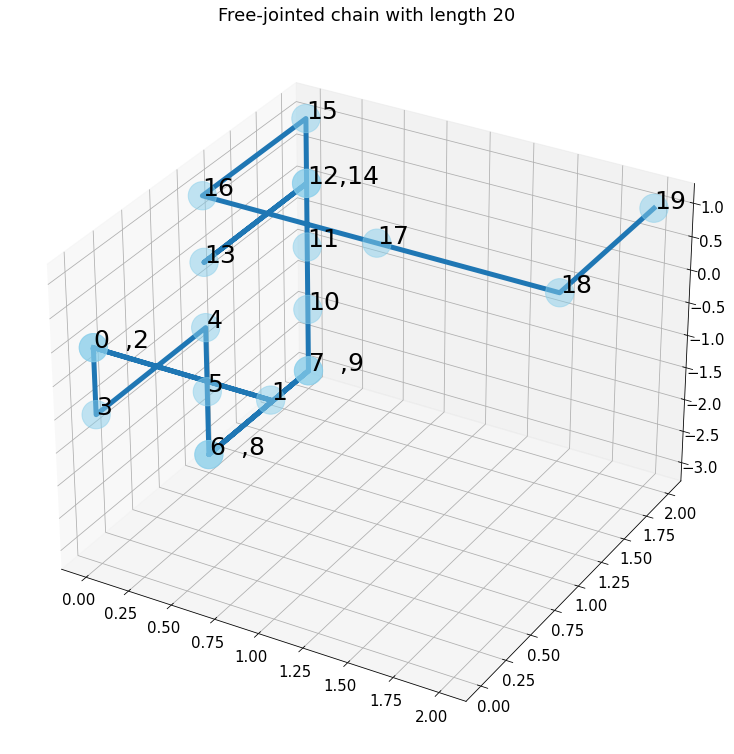

In [105]:
chain = PolymerChain(avoid=False)
chain.AddBeads(20)
ax_1 = chain.Plot3D(title='Free-jointed chain with length 20', fig_size=(10,10));

/tmp/ipykernel_18219/1123815551.py:75: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


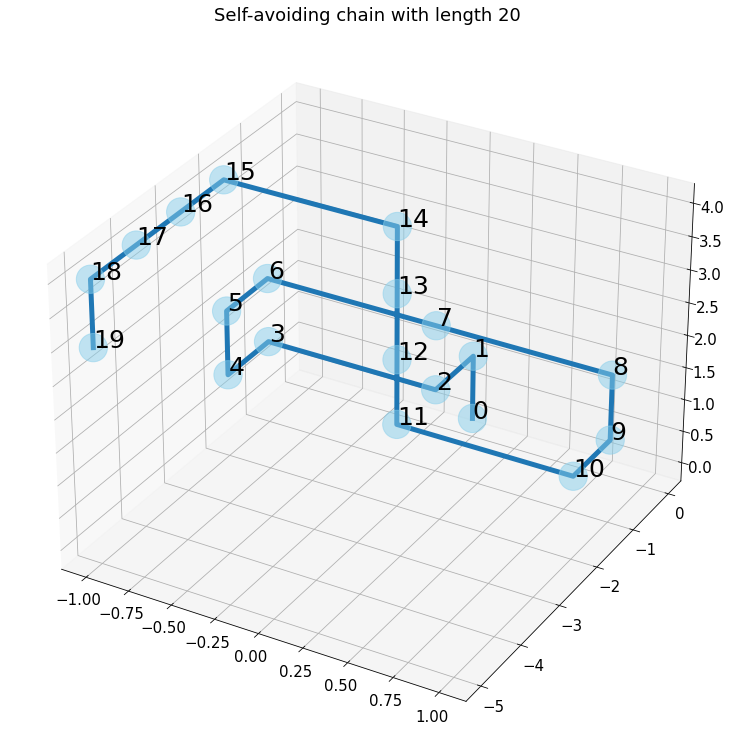

In [106]:
chain = PolymerChain(avoid=True)
chain.AddBeads(20)
chain.Plot3D(title='Self-avoiding chain with length 20', fig_size=(10,10));

### 2. Write a code generating chains of various lengths below $10^{3}$ bonds

In [88]:
def Generate_Polymers(num=20, min_length=20, max_length=1000, avoid=False, verbose=False):
    polymer = PolymerChain(avoid=avoid)
    ls = []
    lengths_ls = []
    
    for i in np.arange(int(num)):
    # for i in tqdm(np.arange(int(num))):
        l = max_length if min_length == max_length else np.random.randint(min_length, max_length)
        polymer.AddBeads(l, restart=True)
        polymer.RealRadius()
        
        ls.append(polymer.real_R)
        lengths_ls.append(polymer.chain.shape[0])
        
        if verbose:
            polymer.ApproxRadius()
            print(f'Chain #{i};   length = {l};   real R = {polymer.real_R:.3f},   R~N^(1/2)l = {polymer.approx_R:.3f}')
    return np.array(ls), np.array(lengths_ls)

In [19]:
_, _ = Generate_Polymers(num=20, min_length=2, max_length=1000, avoid=False, verbose=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 788.66it/s]

Chain #0;   length = 997;   real R = 22.716,   R~N^(1/2)l = 31.575
Chain #1;   length = 633;   real R = 35.525,   R~N^(1/2)l = 25.159
Chain #2;   length = 281;   real R = 8.246,   R~N^(1/2)l = 16.763
Chain #3;   length = 741;   real R = 13.491,   R~N^(1/2)l = 27.221
Chain #4;   length = 839;   real R = 37.497,   R~N^(1/2)l = 28.965
Chain #5;   length = 763;   real R = 37.656,   R~N^(1/2)l = 27.622
Chain #6;   length = 673;   real R = 14.900,   R~N^(1/2)l = 25.942
Chain #7;   length = 600;   real R = 23.259,   R~N^(1/2)l = 24.495
Chain #8;   length = 472;   real R = 27.586,   R~N^(1/2)l = 21.726
Chain #9;   length = 354;   real R = 31.257,   R~N^(1/2)l = 18.815
Chain #10;   length = 19;   real R = 3.162,   R~N^(1/2)l = 4.359
Chain #11;   length = 460;   real R = 9.434,   R~N^(1/2)l = 21.448
Chain #12;   length = 721;   real R = 27.857,   R~N^(1/2)l = 26.851
Chain #13;   length = 626;   real R = 34.366,   R~N^(1/2)l = 25.020
Chain #14;   length = 246;   real R = 13.675,   R~N^(1/2)l = 15

### 3. Can you demonstrate that $R_{0-N}$ is normally distributed?

In [41]:
r_, _ = Generate_Polymers(num=1e3, min_length=1000, max_length=1000, avoid=False, verbose=False)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1481.07it/s]


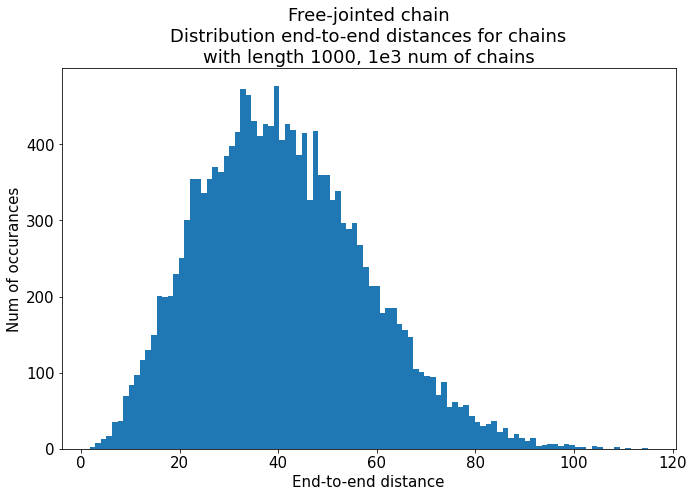

In [107]:
plt.hist(r_, bins=100)
plt.ylabel('Num of occurances')
plt.xlabel('End-to-end distance')
plt.title('Free-jointed chain\nDistribution end-to-end distances for chains\nwith length 1000, 1e3 num of chains');

A null hypothesis is that the distribution is normal. I will use Shapiro test as it suggested in the task, and significance level $0.05$ (as far as I understood it's used quite a lot).

In [34]:
_, p_val = scipy.stats.shapiro(r_)
print(f'p-value = {p_val}')

p-value = 8.016289712031721e-07


Null hypothesis (normality) surprisingly is not accepted.

**Theoretical derivation**

the a sum of N random variables converges in distribution to a normal distribution as N tends to infinity

1. According to a central limit theorem the a sum of N random variables converges in distribution to a normal distribution as N tends to infinity and variables are independent and diturbed identically. Each direction on each step has equal probability and no constraints (free-jointed chain). So, one dimensional chain is normal distributed.

2. 3D chain is a sum of three 1D chains. Sum of distributions is a convolution. Convolution of normal distributions is normal distribution. Hence, 3D free-jointed chain is normal.

*I am confused why the shapiro test shows it is not. May be, it converges really slow and size of dataste has to be huge.*

### 4.Find the dependence of $R_{0-N}(N)$ for the free-jointed chain

In [35]:
num_of_chains = int(1e4)
radiuses_no_avoid, lengths_no_avoid = [], np.arange(50, 1001, 50)
all_r = []

for l in np.arange(50, 1001, 50):
    r_, _ = Generate_Polymers(num=num_of_chains, min_length=l, max_length=l, avoid=False, verbose=False)
    radiuses_no_avoid.append(r_.mean())
    all_r.append(r_)
all_r = np.hstack(all_r)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:06<00:00, 1562.61it/s]


Power = 0.5024929973131776, R^2 score = 0.9997837096450474


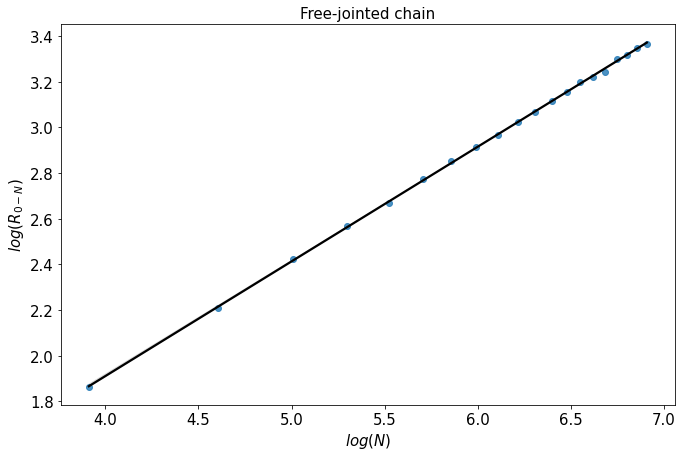

In [108]:
model = LinearRegression(n_jobs=-1)
x = np.log(np.array(lengths_no_avoid).reshape(-1, 1) + 1e-10)
y = np.log(np.array(radiuses_no_avoid) + 1e-10)
model.fit(x, y)

print(f'Power = {model.coef_[0]}, R^2 score = {model.score(x, y)}')
# print(f'ci = 0.95: {stats.norm.interval(0.95, loc=mean, scale=std)}')

sns.regplot(x=x, y=y, ci=95, line_kws={'color': 'k'}, scatter=True);
plt.title('Free-jointed chain', fontsize=15)
plt.ylabel('$log(R_{0-N})$', fontsize=15)
plt.xlabel('$log(N)$', fontsize=15);

In [109]:
slope, _, _, _, std = scipy.stats.linregress(x.ravel(), y)
#compute the CI from a T-distribution
CI = scipy.stats.t.interval(.95, 20-2, loc=slope, scale=std / np.sqrt(y.shape[0]))
print(f'CI = {CI}, {-np.subtract(*CI)}')

CI = (0.5016746187416777, 0.5033113758846776), 0.0016367571429998229


### 6. Can you demonstrate that $R_{0-N}$ is normally distributed (self-avoiding chains)?

In [46]:
r_avoid, l_avoid = Generate_Polymers(num=2e3, min_length=1000, max_length=1000, avoid=True, verbose=False)

idx_to_drop = np.where(l_avoid != 1000)
r_avoid = np.delete(r_avoid, idx_to_drop)
l_avoid = np.delete(l_avoid, idx_to_drop)

print(f'l = {1000}, lengths {l_avoid.shape[0] * 100 / 2e3:.4f} %, end-to-end dist {r_avoid.shape[0] * 100 / 2e3:.4f} %')
print(r_avoid.shape)

100%|███████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:32<00:00, 21.74it/s]

l = 1000, lengths 55.6500 %, end-to-end dist 55.6500 %
(1113,)


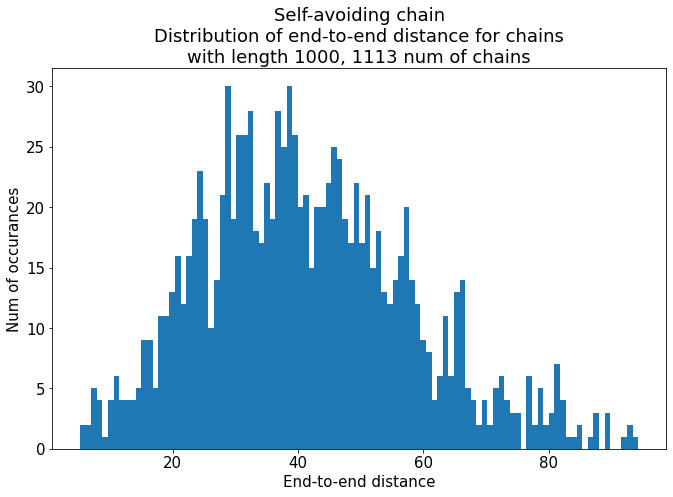

In [110]:
plt.hist(r_avoid, bins=100)
plt.ylabel('Num of occurances')
plt.xlabel('End-to-end distance')
plt.title('Self-avoiding chain\nDistribution of end-to-end distance for chains\nwith length 1000, 1113 num of chains');

In [111]:
_, p_val_avoid = scipy.stats.shapiro(r_avoid)
print(f'p-value = {p_val_avoid}')

p-value = 1.1214110751112116e-09


This distribution is not normal neither.

### 7. Can you convincingly demonstrate that $\beta$ is greater than $1/2$ $(R \sim N^{\beta}$)

In [51]:
num_of_chains_ = int(3e4)
radiuses_avoid, lengths_avoid = [], np.arange(50, 1001, 50)
all_r_avoid = []

for l in np.arange(50, 1001, 50):
    r_, l_ = Generate_Polymers(num=num_of_chains_, min_length=l, max_length=l, avoid=True, verbose=False)
    
    idx_to_drop = np.where(l_ != l)
    r_ = np.delete(r_, idx_to_drop)
    l_ = np.delete(l_, idx_to_drop)
    
    radiuses_avoid.append(r_.mean())
    print(f'l = {l}, lengths {l_.shape[0] * 100 / num_of_chains_:.4f} %, radiuses {r_.shape[0] * 100 / num_of_chains_:.4f} %')
    
    all_r_avoid.append(r_)
all_r_avoid = np.hstack(all_r_avoid)

100%|████████████████████████████████████████████████████████████████████████████| 30000/30000 [01:12<00:00, 416.29it/s]


l = 50, lengths 99.0967 %, radiuses 99.0967 %


100%|████████████████████████████████████████████████████████████████████████████| 30000/30000 [02:30<00:00, 199.74it/s]


l = 100, lengths 97.2300 %, radiuses 97.2300 %


100%|████████████████████████████████████████████████████████████████████████████| 30000/30000 [03:46<00:00, 132.34it/s]


l = 150, lengths 94.6933 %, radiuses 94.6933 %


100%|████████████████████████████████████████████████████████████████████████████| 30000/30000 [04:33<00:00, 109.83it/s]


l = 200, lengths 92.0100 %, radiuses 92.0100 %


100%|█████████████████████████████████████████████████████████████████████████████| 30000/30000 [05:36<00:00, 89.08it/s]


l = 250, lengths 89.7233 %, radiuses 89.7233 %


100%|█████████████████████████████████████████████████████████████████████████████| 30000/30000 [06:44<00:00, 74.10it/s]


l = 300, lengths 87.0667 %, radiuses 87.0667 %


100%|█████████████████████████████████████████████████████████████████████████████| 30000/30000 [07:56<00:00, 63.02it/s]


l = 350, lengths 84.2667 %, radiuses 84.2667 %


100%|█████████████████████████████████████████████████████████████████████████████| 30000/30000 [09:05<00:00, 55.02it/s]


l = 400, lengths 81.8233 %, radiuses 81.8233 %


100%|█████████████████████████████████████████████████████████████████████████████| 30000/30000 [10:18<00:00, 48.51it/s]


l = 450, lengths 79.8733 %, radiuses 79.8733 %


100%|█████████████████████████████████████████████████████████████████████████████| 30000/30000 [11:29<00:00, 43.49it/s]


l = 500, lengths 76.9700 %, radiuses 76.9700 %


100%|█████████████████████████████████████████████████████████████████████████████| 30000/30000 [12:36<00:00, 39.67it/s]


l = 550, lengths 74.4867 %, radiuses 74.4867 %


100%|█████████████████████████████████████████████████████████████████████████████| 30000/30000 [13:55<00:00, 35.90it/s]


l = 600, lengths 72.3933 %, radiuses 72.3933 %


100%|█████████████████████████████████████████████████████████████████████████████| 30000/30000 [14:53<00:00, 33.59it/s]


l = 650, lengths 70.3533 %, radiuses 70.3533 %


100%|█████████████████████████████████████████████████████████████████████████████| 30000/30000 [16:08<00:00, 30.98it/s]


l = 700, lengths 67.9467 %, radiuses 67.9467 %


100%|█████████████████████████████████████████████████████████████████████████████| 30000/30000 [17:19<00:00, 28.87it/s]


l = 750, lengths 65.8433 %, radiuses 65.8433 %


100%|█████████████████████████████████████████████████████████████████████████████| 30000/30000 [18:27<00:00, 27.08it/s]


l = 800, lengths 64.1267 %, radiuses 64.1267 %


100%|█████████████████████████████████████████████████████████████████████████████| 30000/30000 [19:41<00:00, 25.39it/s]


l = 850, lengths 62.0100 %, radiuses 62.0100 %


100%|█████████████████████████████████████████████████████████████████████████████| 30000/30000 [20:42<00:00, 24.14it/s]


l = 900, lengths 59.8533 %, radiuses 59.8533 %


100%|█████████████████████████████████████████████████████████████████████████████| 30000/30000 [21:39<00:00, 23.08it/s]


l = 950, lengths 57.6167 %, radiuses 57.6167 %


100%|█████████████████████████████████████████████████████████████████████████████| 30000/30000 [22:46<00:00, 21.96it/s]

l = 1000, lengths 55.7333 %, radiuses 55.7333 %


Power = 0.5190781623956108, R^2 score = 0.9999481978466439


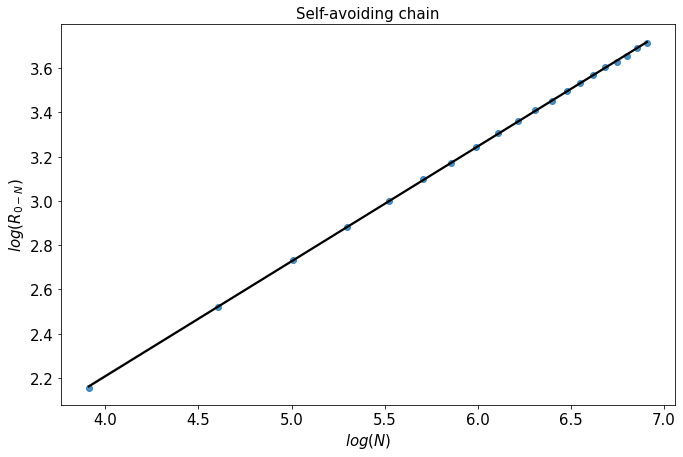

In [112]:
model_ = LinearRegression(n_jobs=-1)
x_ = np.log(np.array(lengths_avoid).reshape(-1, 1) + 1e-10)
y_ = np.log(np.array(radiuses_avoid) + 1e-10)
model_.fit(x_, y_)

print(f'Power = {model_.coef_[0]}, R^2 score = {model_.score(x_, y_)}')
# print(f'ci = 0.95: {stats.norm.interval(0.95, loc=mean, scale=std)}')

sns.regplot(x=x_, y=y_, ci=95, line_kws={'color': 'k'}, scatter=True);
plt.title('Self-avoiding chain', fontsize=15)
plt.ylabel('$log(R_{0-N})$', fontsize=15)
plt.xlabel('$log(N)$', fontsize=15);

The power is greater than $1/2$ but is far away from theoretical value $3/5$. I believe, the sample size is too small (and the step of chain lengths is too big).

In [57]:
slope_, _, _, _, std_ = scipy.stats.linregress(x_.ravel(), y_)
#compute the CI from a T-distribution
CI = scipy.stats.t.interval(.95, 20-2, loc=slope_, scale=std_ / np.sqrt(y_.shape[0]))
print(f'CI = {CI}, {-np.subtract(*CI)}')

CI = (0.5186644708925302, 0.5194918538986911), 0.00082738300616092


## 8. Roughly estimate the size of the dataset sufficient to conclude that the excluded volume interactions lead to a different chain geometry.

I can suggest this logic.

If we assume different geometry, then the one metrics we use to describe it -- end-to-end distance -- has to be different for diffferent chain types. Hence, the distribution of end-to-end distances has to be different. So, the thing one needs to do is to find the size of the dataset, on which distributions of end-to-end distance start to differ one from each other. Threshold is 0.05.

In [93]:
d_sizes = np.arange(5, 1000, 1)

# I will average 1000 initializations
enough_size = []

for _ in tqdm(np.arange(1000)):
    for dataset_size in d_sizes:        
        r_check_sim, _ = Generate_Polymers(num=dataset_size, min_length=2, max_length=1000, avoid=False, verbose=False)
        r_check_sim_avoid, _ = Generate_Polymers(num=dataset_size, min_length=2, max_length=1000, avoid=True, verbose=False)
        
        _, p_val_check_sim = scipy.stats.kstest(r_check_sim, r_check_sim_avoid)
        if p_val_check_sim < 0.05:
            print(f'p_value = {p_val_check_sim}, size = {dataset_size} is enough to distingusih distributions.')
            enough_size.append(dataset_size)
            break

  0%|                                                                                  | 1/1000 [00:02<43:23,  2.61s/it]

p_value = 0.007655808318750842, size = 15 is enough to distingusih distributions.


  0%|▏                                                                               | 2/1000 [00:07<1:10:00,  4.21s/it]

p_value = 0.007289903434428559, size = 22 is enough to distingusih distributions.


  0%|▏                                                                               | 3/1000 [00:16<1:43:07,  6.21s/it]

p_value = 0.025624647770069564, size = 28 is enough to distingusih distributions.


  0%|▎                                                                               | 4/1000 [00:20<1:25:28,  5.15s/it]

p_value = 0.020747520755971537, size = 18 is enough to distingusih distributions.


  0%|▍                                                                               | 5/1000 [00:25<1:30:03,  5.43s/it]

p_value = 0.0032406377456433077, size = 23 is enough to distingusih distributions.


  1%|▍                                                                               | 6/1000 [00:29<1:19:26,  4.80s/it]

p_value = 0.015560640732265447, size = 17 is enough to distingusih distributions.


  1%|▌                                                                               | 7/1000 [00:33<1:14:44,  4.52s/it]

p_value = 0.006668846028113762, size = 18 is enough to distingusih distributions.


  1%|▋                                                                               | 8/1000 [00:45<1:55:10,  6.97s/it]

p_value = 0.024674332703421464, size = 33 is enough to distingusih distributions.


  1%|▋                                                                               | 9/1000 [00:48<1:32:57,  5.63s/it]

p_value = 0.026248485664288602, size = 15 is enough to distingusih distributions.


  1%|▊                                                                              | 10/1000 [00:50<1:16:03,  4.61s/it]

p_value = 0.018782249742002058, size = 14 is enough to distingusih distributions.


  1%|▊                                                                              | 11/1000 [00:55<1:17:56,  4.73s/it]

p_value = 0.005467427576534314, size = 21 is enough to distingusih distributions.


  1%|▉                                                                                | 12/1000 [00:56<56:45,  3.45s/it]

p_value = 0.0005827505827505828, size = 7 is enough to distingusih distributions.


  1%|█                                                                                | 13/1000 [00:58<51:34,  3.14s/it]

p_value = 0.026248485664288602, size = 15 is enough to distingusih distributions.


  1%|█                                                                              | 14/1000 [01:04<1:03:15,  3.85s/it]

p_value = 0.04934690960468394, size = 22 is enough to distingusih distributions.


  2%|█▏                                                                             | 15/1000 [01:13<1:32:12,  5.62s/it]

p_value = 0.034580084963334506, size = 30 is enough to distingusih distributions.


  2%|█▎                                                                             | 16/1000 [01:18<1:29:12,  5.44s/it]

p_value = 0.020047233548095234, size = 22 is enough to distingusih distributions.


  2%|█▍                                                                               | 18/1000 [01:21<51:44,  3.16s/it]

p_value = 0.007655808318750842, size = 15 is enough to distingusih distributions.
p_value = 0.007936507936507936, size = 5 is enough to distingusih distributions.


  2%|█▌                                                                               | 19/1000 [01:21<38:33,  2.36s/it]

p_value = 0.008158508158508158, size = 7 is enough to distingusih distributions.


  2%|█▌                                                                               | 20/1000 [01:22<32:06,  1.97s/it]

p_value = 0.012340600575894691, size = 10 is enough to distingusih distributions.


  2%|█▋                                                                               | 21/1000 [01:25<36:53,  2.26s/it]

p_value = 0.026248485664288602, size = 15 is enough to distingusih distributions.


  2%|█▊                                                                               | 22/1000 [01:27<34:46,  2.13s/it]

p_value = 0.012649270234409551, size = 13 is enough to distingusih distributions.


  2%|█▊                                                                               | 23/1000 [01:29<32:43,  2.01s/it]

p_value = 0.031436056203858066, size = 12 is enough to distingusih distributions.


  2%|█▉                                                                               | 24/1000 [01:34<48:48,  3.00s/it]

p_value = 0.041088503979639056, size = 21 is enough to distingusih distributions.


  2%|██                                                                               | 25/1000 [01:35<36:36,  2.25s/it]

p_value = 0.008158508158508158, size = 7 is enough to distingusih distributions.


  3%|██                                                                             | 26/1000 [01:44<1:13:33,  4.53s/it]

p_value = 0.034580084963334506, size = 30 is enough to distingusih distributions.


  3%|██▏                                                                            | 27/1000 [01:46<1:00:44,  3.75s/it]

p_value = 0.04427244582043343, size = 13 is enough to distingusih distributions.


  3%|██▏                                                                            | 28/1000 [01:51<1:06:17,  4.09s/it]

p_value = 0.012298612583953778, size = 20 is enough to distingusih distributions.


  3%|██▎                                                                              | 29/1000 [01:52<50:11,  3.10s/it]

p_value = 0.03356643356643356, size = 9 is enough to distingusih distributions.


  3%|██▍                                                                              | 30/1000 [01:55<50:00,  3.09s/it]

p_value = 0.04495293297598427, size = 17 is enough to distingusih distributions.


  3%|██▌                                                                              | 31/1000 [01:59<54:01,  3.35s/it]

p_value = 0.009223959448847003, size = 19 is enough to distingusih distributions.


  3%|██▌                                                                            | 32/1000 [02:07<1:15:24,  4.67s/it]

p_value = 0.02166982723648196, size = 27 is enough to distingusih distributions.


  3%|██▋                                                                              | 33/1000 [02:08<59:08,  3.67s/it]

p_value = 0.004366118917202508, size = 11 is enough to distingusih distributions.


  3%|██▋                                                                            | 34/1000 [02:13<1:07:17,  4.18s/it]

p_value = 0.020047233548095234, size = 22 is enough to distingusih distributions.


  4%|██▊                                                                            | 35/1000 [02:27<1:52:19,  6.98s/it]

p_value = 0.0008952478999561411, size = 34 is enough to distingusih distributions.


  4%|██▊                                                                            | 36/1000 [02:32<1:40:29,  6.25s/it]

p_value = 0.041088503979639056, size = 21 is enough to distingusih distributions.


  4%|██▉                                                                            | 37/1000 [02:34<1:20:57,  5.04s/it]

p_value = 0.026248485664288602, size = 15 is enough to distingusih distributions.


  4%|███                                                                            | 38/1000 [02:37<1:11:53,  4.48s/it]

p_value = 0.011199353883429802, size = 16 is enough to distingusih distributions.


  4%|███                                                                            | 39/1000 [02:39<1:00:03,  3.75s/it]

p_value = 0.018782249742002058, size = 14 is enough to distingusih distributions.


  4%|███▏                                                                           | 40/1000 [02:46<1:16:47,  4.80s/it]

p_value = 0.041793857075631685, size = 26 is enough to distingusih distributions.


  4%|███▎                                                                             | 41/1000 [02:47<58:23,  3.65s/it]

p_value = 0.006293706293706292, size = 9 is enough to distingusih distributions.


  4%|███▍                                                                             | 42/1000 [02:49<47:21,  2.97s/it]

p_value = 0.020739064856711915, size = 11 is enough to distingusih distributions.


  4%|███▍                                                                             | 43/1000 [02:53<54:23,  3.41s/it]

p_value = 0.0335416594061465, size = 20 is enough to distingusih distributions.


  4%|███▍                                                                           | 44/1000 [03:03<1:26:24,  5.42s/it]

p_value = 0.005318753054702164, size = 29 is enough to distingusih distributions.


  4%|███▌                                                                           | 45/1000 [03:03<1:01:52,  3.89s/it]

p_value = 0.025974025974025972, size = 6 is enough to distingusih distributions.


  5%|███▋                                                                             | 46/1000 [03:05<49:25,  3.11s/it]

p_value = 0.020739064856711915, size = 11 is enough to distingusih distributions.


  5%|███▋                                                                           | 47/1000 [03:11<1:04:15,  4.05s/it]

p_value = 0.0032406377456433077, size = 23 is enough to distingusih distributions.


  5%|███▊                                                                           | 48/1000 [03:15<1:04:07,  4.04s/it]

p_value = 0.006668846028113762, size = 18 is enough to distingusih distributions.


  5%|███▊                                                                           | 49/1000 [03:27<1:42:13,  6.45s/it]

p_value = 0.04486227643337436, size = 32 is enough to distingusih distributions.


  5%|███▉                                                                           | 50/1000 [03:46<2:40:18, 10.12s/it]

p_value = 0.03180009083874479, size = 41 is enough to distingusih distributions.


  5%|████                                                                           | 51/1000 [03:49<2:06:04,  7.97s/it]

p_value = 0.011199353883429802, size = 16 is enough to distingusih distributions.


  5%|████                                                                           | 52/1000 [03:54<1:51:05,  7.03s/it]

p_value = 0.005467427576534314, size = 21 is enough to distingusih distributions.


  5%|████▏                                                                          | 53/1000 [03:58<1:40:10,  6.35s/it]

p_value = 0.041088503979639056, size = 21 is enough to distingusih distributions.


  5%|████▎                                                                          | 54/1000 [04:00<1:19:43,  5.06s/it]

p_value = 0.018782249742002058, size = 14 is enough to distingusih distributions.


  6%|████▎                                                                          | 55/1000 [04:04<1:10:40,  4.49s/it]

p_value = 3.9746208766961545e-05, size = 17 is enough to distingusih distributions.


  6%|████▍                                                                          | 56/1000 [04:13<1:33:25,  5.94s/it]

p_value = 0.025624647770069564, size = 28 is enough to distingusih distributions.


  6%|████▌                                                                          | 57/1000 [04:16<1:20:29,  5.12s/it]

p_value = 0.001152640054241885, size = 17 is enough to distingusih distributions.


  6%|████▌                                                                          | 58/1000 [04:18<1:04:03,  4.08s/it]

p_value = 0.04427244582043343, size = 13 is enough to distingusih distributions.


  6%|████▊                                                                            | 59/1000 [04:18<48:24,  3.09s/it]

p_value = 0.002486402486402486, size = 8 is enough to distingusih distributions.


  6%|████▊                                                                            | 60/1000 [04:19<38:20,  2.45s/it]

p_value = 0.0007404360345536814, size = 9 is enough to distingusih distributions.


  6%|████▉                                                                            | 61/1000 [04:24<48:07,  3.08s/it]

p_value = 0.0335416594061465, size = 20 is enough to distingusih distributions.


  6%|████▉                                                                          | 62/1000 [04:31<1:06:27,  4.25s/it]

p_value = 0.00432085032746239, size = 24 is enough to distingusih distributions.


  6%|████▉                                                                          | 63/1000 [04:34<1:00:17,  3.86s/it]

p_value = 0.011199353883429802, size = 16 is enough to distingusih distributions.


  6%|█████▏                                                                           | 64/1000 [04:36<51:45,  3.32s/it]

p_value = 0.018782249742002058, size = 14 is enough to distingusih distributions.


  6%|█████▎                                                                           | 65/1000 [04:39<52:43,  3.38s/it]

p_value = 0.006668846028113762, size = 18 is enough to distingusih distributions.


  7%|█████▏                                                                         | 66/1000 [04:46<1:08:03,  4.37s/it]

p_value = 0.011965431606262756, size = 24 is enough to distingusih distributions.


  7%|█████▍                                                                           | 67/1000 [04:47<52:49,  3.40s/it]

p_value = 0.002056766762649115, size = 10 is enough to distingusih distributions.


  7%|█████▎                                                                         | 68/1000 [04:54<1:06:41,  4.29s/it]

p_value = 0.000990194866724344, size = 23 is enough to distingusih distributions.


  7%|█████▌                                                                           | 69/1000 [04:55<50:57,  3.28s/it]

p_value = 0.03356643356643356, size = 9 is enough to distingusih distributions.


  7%|█████▋                                                                           | 70/1000 [04:59<57:34,  3.71s/it]

p_value = 0.00396729438660086, size = 20 is enough to distingusih distributions.


  7%|█████▊                                                                           | 71/1000 [05:01<48:05,  3.11s/it]

p_value = 0.000499971155510259, size = 13 is enough to distingusih distributions.


  7%|█████▊                                                                           | 72/1000 [05:04<47:38,  3.08s/it]

p_value = 0.03499797755837617, size = 16 is enough to distingusih distributions.


  7%|█████▉                                                                           | 73/1000 [05:06<40:25,  2.62s/it]

p_value = 0.031436056203858066, size = 12 is enough to distingusih distributions.


  7%|█████▉                                                                           | 74/1000 [05:07<36:17,  2.35s/it]

p_value = 0.031436056203858066, size = 12 is enough to distingusih distributions.


  8%|██████                                                                           | 75/1000 [05:08<26:40,  1.73s/it]

p_value = 0.025974025974025972, size = 6 is enough to distingusih distributions.


  8%|██████                                                                         | 76/1000 [05:17<1:01:57,  4.02s/it]

p_value = 0.02993100210360296, size = 29 is enough to distingusih distributions.


  8%|██████                                                                         | 77/1000 [05:22<1:08:09,  4.43s/it]

p_value = 0.04934690960468394, size = 22 is enough to distingusih distributions.


  8%|██████▏                                                                        | 78/1000 [05:33<1:37:42,  6.36s/it]

p_value = 0.018400608756955844, size = 31 is enough to distingusih distributions.


  8%|██████▏                                                                        | 79/1000 [05:35<1:17:17,  5.03s/it]

p_value = 0.04427244582043343, size = 13 is enough to distingusih distributions.


  8%|██████▎                                                                        | 80/1000 [05:43<1:29:38,  5.85s/it]

p_value = 0.041793857075631685, size = 26 is enough to distingusih distributions.


  8%|██████▍                                                                        | 81/1000 [05:43<1:04:55,  4.24s/it]

p_value = 0.008158508158508158, size = 7 is enough to distingusih distributions.


  8%|██████▍                                                                        | 82/1000 [05:47<1:01:21,  4.01s/it]

p_value = 0.020747520755971537, size = 18 is enough to distingusih distributions.


  8%|██████▌                                                                        | 83/1000 [05:51<1:01:05,  4.00s/it]

p_value = 0.020747520755971537, size = 18 is enough to distingusih distributions.


  8%|██████▊                                                                          | 84/1000 [05:51<44:47,  2.93s/it]

p_value = 0.018648018648018645, size = 8 is enough to distingusih distributions.


  8%|██████▉                                                                          | 85/1000 [05:57<55:46,  3.66s/it]

p_value = 0.015905243702949885, size = 21 is enough to distingusih distributions.


  9%|██████▊                                                                        | 86/1000 [06:08<1:30:56,  5.97s/it]

p_value = 0.0015053497817310642, size = 32 is enough to distingusih distributions.


  9%|██████▊                                                                        | 87/1000 [06:11<1:16:39,  5.04s/it]

p_value = 0.04495293297598427, size = 17 is enough to distingusih distributions.


  9%|██████▉                                                                        | 88/1000 [06:16<1:19:13,  5.21s/it]

p_value = 0.04934690960468394, size = 22 is enough to distingusih distributions.


  9%|███████                                                                        | 89/1000 [06:37<2:30:43,  9.93s/it]

p_value = 0.004834114654932304, size = 43 is enough to distingusih distributions.


  9%|███████                                                                        | 90/1000 [06:41<2:00:17,  7.93s/it]

p_value = 0.0006700468135385351, size = 16 is enough to distingusih distributions.


  9%|███████▏                                                                       | 91/1000 [06:42<1:32:12,  6.09s/it]

p_value = 0.002874834144183989, size = 13 is enough to distingusih distributions.


  9%|███████▎                                                                       | 92/1000 [06:49<1:33:57,  6.21s/it]

p_value = 0.029913567122680163, size = 24 is enough to distingusih distributions.


  9%|███████▎                                                                       | 93/1000 [06:52<1:20:57,  5.36s/it]

p_value = 0.04495293297598427, size = 17 is enough to distingusih distributions.


  9%|███████▍                                                                       | 94/1000 [06:56<1:15:10,  4.98s/it]

p_value = 0.026749480251438945, size = 19 is enough to distingusih distributions.


 10%|███████▋                                                                         | 95/1000 [06:57<57:18,  3.80s/it]

p_value = 0.020739064856711915, size = 11 is enough to distingusih distributions.


 10%|███████▌                                                                       | 96/1000 [07:07<1:21:49,  5.43s/it]

p_value = 0.0019790709048350735, size = 29 is enough to distingusih distributions.


 10%|███████▋                                                                       | 97/1000 [07:12<1:23:05,  5.52s/it]

p_value = 0.04934690960468394, size = 22 is enough to distingusih distributions.


 10%|███████▋                                                                       | 98/1000 [07:21<1:35:38,  6.36s/it]

p_value = 0.04843826268679447, size = 27 is enough to distingusih distributions.


 10%|███████▊                                                                       | 99/1000 [07:21<1:09:50,  4.65s/it]

p_value = 0.018648018648018645, size = 8 is enough to distingusih distributions.


 10%|███████▊                                                                      | 100/1000 [07:33<1:41:04,  6.74s/it]

p_value = 0.009516275438959759, size = 32 is enough to distingusih distributions.


 10%|███████▉                                                                      | 101/1000 [07:38<1:32:55,  6.20s/it]

p_value = 0.005467427576534314, size = 21 is enough to distingusih distributions.


 10%|███████▉                                                                      | 102/1000 [07:42<1:24:05,  5.62s/it]

p_value = 0.026749480251438945, size = 19 is enough to distingusih distributions.


 10%|████████                                                                      | 103/1000 [07:47<1:20:01,  5.35s/it]

p_value = 0.0335416594061465, size = 20 is enough to distingusih distributions.


 10%|████████                                                                      | 104/1000 [07:49<1:04:13,  4.30s/it]

p_value = 0.012649270234409551, size = 13 is enough to distingusih distributions.


 10%|████████▏                                                                     | 105/1000 [07:53<1:02:12,  4.17s/it]

p_value = 0.002767187834654101, size = 19 is enough to distingusih distributions.


 11%|████████▎                                                                     | 106/1000 [08:00<1:15:39,  5.08s/it]

p_value = 0.005614410507946465, size = 25 is enough to distingusih distributions.


 11%|████████▎                                                                     | 107/1000 [08:05<1:17:49,  5.23s/it]

p_value = 0.04934690960468394, size = 22 is enough to distingusih distributions.


 11%|████████▋                                                                       | 108/1000 [08:06<56:08,  3.78s/it]

p_value = 0.008158508158508158, size = 7 is enough to distingusih distributions.


 11%|████████▋                                                                       | 109/1000 [08:08<50:00,  3.37s/it]

p_value = 0.026248485664288602, size = 15 is enough to distingusih distributions.


 11%|████████▌                                                                     | 110/1000 [08:15<1:04:30,  4.35s/it]

p_value = 0.029913567122680163, size = 24 is enough to distingusih distributions.


 11%|████████▋                                                                     | 111/1000 [08:25<1:30:56,  6.14s/it]

p_value = 0.015643390496754332, size = 30 is enough to distingusih distributions.


 11%|████████▋                                                                     | 112/1000 [08:26<1:09:03,  4.67s/it]

p_value = 0.012340600575894691, size = 10 is enough to distingusih distributions.


 11%|█████████                                                                       | 113/1000 [08:27<50:57,  3.45s/it]

p_value = 0.018648018648018645, size = 8 is enough to distingusih distributions.


 11%|█████████                                                                       | 114/1000 [08:29<43:16,  2.93s/it]

p_value = 0.04427244582043343, size = 13 is enough to distingusih distributions.


 12%|████████▉                                                                     | 115/1000 [08:42<1:26:43,  5.88s/it]

p_value = 0.0057719930314983296, size = 34 is enough to distingusih distributions.


 12%|█████████                                                                     | 116/1000 [08:42<1:04:41,  4.39s/it]

p_value = 0.03356643356643356, size = 9 is enough to distingusih distributions.


 12%|█████████▎                                                                      | 117/1000 [08:43<47:51,  3.25s/it]

p_value = 0.018648018648018645, size = 8 is enough to distingusih distributions.


 12%|█████████▍                                                                      | 118/1000 [08:48<53:49,  3.66s/it]

p_value = 0.026749480251438945, size = 19 is enough to distingusih distributions.


 12%|█████████▌                                                                      | 119/1000 [08:50<49:11,  3.35s/it]

p_value = 0.0018373939965002021, size = 15 is enough to distingusih distributions.


 12%|█████████▌                                                                      | 120/1000 [08:52<40:20,  2.75s/it]

p_value = 0.020739064856711915, size = 11 is enough to distingusih distributions.


 12%|█████████▍                                                                    | 121/1000 [08:59<1:00:05,  4.10s/it]

p_value = 0.041793857075631685, size = 26 is enough to distingusih distributions.


 12%|█████████▌                                                                    | 122/1000 [09:06<1:13:17,  5.01s/it]

p_value = 0.03561137027640743, size = 25 is enough to distingusih distributions.


 12%|█████████▌                                                                    | 123/1000 [09:09<1:02:43,  4.29s/it]

p_value = 0.03499797755837617, size = 16 is enough to distingusih distributions.


 12%|█████████▉                                                                      | 124/1000 [09:10<50:50,  3.48s/it]

p_value = 0.031436056203858066, size = 12 is enough to distingusih distributions.


 12%|█████████▊                                                                    | 125/1000 [09:18<1:09:28,  4.76s/it]

p_value = 0.02166982723648196, size = 27 is enough to distingusih distributions.


 13%|█████████▊                                                                    | 126/1000 [09:24<1:15:03,  5.15s/it]

p_value = 0.02472024578256561, size = 23 is enough to distingusih distributions.


 13%|█████████▉                                                                    | 127/1000 [09:28<1:10:46,  4.86s/it]

p_value = 0.0335416594061465, size = 20 is enough to distingusih distributions.


 13%|█████████▉                                                                    | 128/1000 [09:33<1:10:43,  4.87s/it]

p_value = 1.94917204154521e-05, size = 21 is enough to distingusih distributions.


 13%|██████████▎                                                                     | 129/1000 [09:35<56:45,  3.91s/it]

p_value = 0.031436056203858066, size = 12 is enough to distingusih distributions.


 13%|██████████▍                                                                     | 130/1000 [09:39<57:46,  3.98s/it]

p_value = 0.026749480251438945, size = 19 is enough to distingusih distributions.


 13%|██████████▏                                                                   | 131/1000 [09:47<1:16:13,  5.26s/it]

p_value = 0.004249942989061184, size = 28 is enough to distingusih distributions.


 13%|██████████▎                                                                   | 132/1000 [09:49<1:01:08,  4.23s/it]

p_value = 0.0014969550573265746, size = 12 is enough to distingusih distributions.


 13%|██████████▋                                                                     | 133/1000 [09:50<48:14,  3.34s/it]

p_value = 0.012340600575894691, size = 10 is enough to distingusih distributions.


 13%|██████████▋                                                                     | 134/1000 [09:52<40:33,  2.81s/it]

p_value = 0.031436056203858066, size = 12 is enough to distingusih distributions.


 14%|██████████▊                                                                     | 135/1000 [09:54<39:36,  2.75s/it]

p_value = 0.011199353883429802, size = 16 is enough to distingusih distributions.


 14%|██████████▉                                                                     | 136/1000 [09:57<39:58,  2.78s/it]

p_value = 0.0030152106609234084, size = 16 is enough to distingusih distributions.


 14%|██████████▉                                                                     | 137/1000 [10:02<46:34,  3.24s/it]

p_value = 0.026749480251438945, size = 19 is enough to distingusih distributions.


 14%|██████████▊                                                                   | 138/1000 [10:11<1:14:16,  5.17s/it]

p_value = 0.02993100210360296, size = 29 is enough to distingusih distributions.


 14%|███████████                                                                     | 139/1000 [10:13<58:08,  4.05s/it]

p_value = 0.007859014050964517, size = 12 is enough to distingusih distributions.


 14%|███████████▏                                                                    | 140/1000 [10:15<51:44,  3.61s/it]

p_value = 0.026248485664288602, size = 15 is enough to distingusih distributions.


 14%|███████████▎                                                                    | 141/1000 [10:18<45:57,  3.21s/it]

p_value = 0.026248485664288602, size = 15 is enough to distingusih distributions.


 14%|███████████▎                                                                    | 142/1000 [10:18<35:56,  2.51s/it]

p_value = 0.03356643356643356, size = 9 is enough to distingusih distributions.


 14%|███████████▍                                                                    | 143/1000 [10:21<35:04,  2.46s/it]

p_value = 0.004899717324000537, size = 14 is enough to distingusih distributions.


 14%|███████████▌                                                                    | 144/1000 [10:22<31:45,  2.23s/it]

p_value = 0.031436056203858066, size = 12 is enough to distingusih distributions.


 14%|███████████▌                                                                    | 145/1000 [10:31<59:08,  4.15s/it]

p_value = 0.010890478814461192, size = 28 is enough to distingusih distributions.


 15%|███████████▋                                                                    | 146/1000 [10:32<45:06,  3.17s/it]

p_value = 0.012340600575894691, size = 10 is enough to distingusih distributions.


 15%|███████████▍                                                                  | 147/1000 [10:42<1:16:00,  5.35s/it]

p_value = 0.034580084963334506, size = 30 is enough to distingusih distributions.


 15%|███████████▌                                                                  | 148/1000 [10:50<1:24:10,  5.93s/it]

p_value = 0.007134100565905311, size = 26 is enough to distingusih distributions.


 15%|███████████▌                                                                  | 149/1000 [10:51<1:04:27,  4.54s/it]

p_value = 0.020739064856711915, size = 11 is enough to distingusih distributions.


 15%|████████████                                                                    | 150/1000 [10:53<53:56,  3.81s/it]

p_value = 0.026248485664288602, size = 15 is enough to distingusih distributions.


 15%|████████████                                                                    | 151/1000 [10:53<39:03,  2.76s/it]

p_value = 0.025974025974025972, size = 6 is enough to distingusih distributions.


 15%|████████████▏                                                                   | 152/1000 [10:56<40:01,  2.83s/it]

p_value = 0.03499797755837617, size = 16 is enough to distingusih distributions.


 15%|███████████▉                                                                  | 153/1000 [11:11<1:29:06,  6.31s/it]

p_value = 0.00018725837572722094, size = 36 is enough to distingusih distributions.


 15%|████████████                                                                  | 154/1000 [11:14<1:15:49,  5.38s/it]

p_value = 0.015560640732265447, size = 17 is enough to distingusih distributions.


 16%|████████████▍                                                                   | 155/1000 [11:15<58:43,  4.17s/it]

p_value = 0.020739064856711915, size = 11 is enough to distingusih distributions.


 16%|████████████▏                                                                 | 156/1000 [11:28<1:32:30,  6.58s/it]

p_value = 0.024674332703421464, size = 33 is enough to distingusih distributions.


 16%|████████████▏                                                                 | 157/1000 [11:35<1:34:36,  6.73s/it]

p_value = 0.03561137027640743, size = 25 is enough to distingusih distributions.


 16%|████████████▎                                                                 | 158/1000 [11:40<1:29:33,  6.38s/it]

p_value = 0.007289903434428559, size = 22 is enough to distingusih distributions.


 16%|████████████▍                                                                 | 159/1000 [11:46<1:26:22,  6.16s/it]

p_value = 0.000990194866724344, size = 23 is enough to distingusih distributions.


 16%|████████████▍                                                                 | 160/1000 [11:47<1:05:06,  4.65s/it]

p_value = 0.002056766762649115, size = 10 is enough to distingusih distributions.


 16%|████████████▉                                                                   | 161/1000 [11:48<51:40,  3.70s/it]

p_value = 0.020739064856711915, size = 11 is enough to distingusih distributions.


 16%|████████████▋                                                                 | 162/1000 [11:55<1:02:39,  4.49s/it]

p_value = 0.011965431606262756, size = 24 is enough to distingusih distributions.


 16%|████████████▋                                                                 | 163/1000 [12:05<1:25:13,  6.11s/it]

p_value = 0.015643390496754332, size = 30 is enough to distingusih distributions.


 16%|████████████▊                                                                 | 164/1000 [12:06<1:04:09,  4.60s/it]

p_value = 0.002056766762649115, size = 10 is enough to distingusih distributions.


 16%|████████████▊                                                                 | 165/1000 [12:14<1:19:47,  5.73s/it]

p_value = 0.04843826268679447, size = 27 is enough to distingusih distributions.


 17%|█████████████▎                                                                  | 166/1000 [12:15<58:03,  4.18s/it]

p_value = 0.002486402486402486, size = 8 is enough to distingusih distributions.


 17%|█████████████▍                                                                  | 168/1000 [12:18<38:24,  2.77s/it]

p_value = 0.015560640732265447, size = 17 is enough to distingusih distributions.
p_value = 0.007936507936507936, size = 5 is enough to distingusih distributions.


 17%|█████████████▌                                                                  | 169/1000 [12:21<37:30,  2.71s/it]

p_value = 0.007655808318750842, size = 15 is enough to distingusih distributions.


 17%|█████████████▌                                                                  | 170/1000 [12:26<49:04,  3.55s/it]

p_value = 0.04934690960468394, size = 22 is enough to distingusih distributions.


 17%|█████████████▋                                                                  | 171/1000 [12:28<43:02,  3.11s/it]

p_value = 0.004899717324000537, size = 14 is enough to distingusih distributions.


 17%|█████████████▊                                                                  | 172/1000 [12:33<48:44,  3.53s/it]

p_value = 0.041088503979639056, size = 21 is enough to distingusih distributions.


 17%|█████████████▊                                                                  | 173/1000 [12:37<52:23,  3.80s/it]

p_value = 0.012298612583953778, size = 20 is enough to distingusih distributions.


 17%|█████████████▉                                                                  | 174/1000 [12:39<44:16,  3.22s/it]

p_value = 0.018782249742002058, size = 14 is enough to distingusih distributions.


 18%|█████████████▋                                                                | 175/1000 [12:50<1:17:43,  5.65s/it]

p_value = 0.03956122619720958, size = 31 is enough to distingusih distributions.


 18%|█████████████▋                                                                | 176/1000 [12:59<1:31:10,  6.64s/it]

p_value = 0.004249942989061184, size = 28 is enough to distingusih distributions.


 18%|█████████████▊                                                                | 177/1000 [13:07<1:35:34,  6.97s/it]

p_value = 0.04843826268679447, size = 27 is enough to distingusih distributions.


 18%|█████████████▉                                                                | 178/1000 [13:14<1:36:35,  7.05s/it]

p_value = 0.03561137027640743, size = 25 is enough to distingusih distributions.


 18%|█████████████▉                                                                | 179/1000 [13:27<1:58:48,  8.68s/it]

p_value = 0.024674332703421464, size = 33 is enough to distingusih distributions.


 18%|██████████████                                                                | 180/1000 [13:28<1:29:09,  6.52s/it]

p_value = 0.031436056203858066, size = 12 is enough to distingusih distributions.


 18%|██████████████                                                                | 181/1000 [13:36<1:33:47,  6.87s/it]

p_value = 0.041793857075631685, size = 26 is enough to distingusih distributions.


 18%|██████████████▏                                                               | 182/1000 [13:37<1:08:50,  5.05s/it]

p_value = 0.006293706293706292, size = 9 is enough to distingusih distributions.


 18%|██████████████▋                                                                 | 183/1000 [13:37<50:28,  3.71s/it]

p_value = 0.002486402486402486, size = 8 is enough to distingusih distributions.


 18%|██████████████▋                                                                 | 184/1000 [13:39<42:11,  3.10s/it]

p_value = 0.031436056203858066, size = 12 is enough to distingusih distributions.


 18%|██████████████▊                                                                 | 185/1000 [13:40<32:34,  2.40s/it]

p_value = 0.03356643356643356, size = 9 is enough to distingusih distributions.


 19%|██████████████▉                                                                 | 186/1000 [13:44<38:37,  2.85s/it]

p_value = 0.002767187834654101, size = 19 is enough to distingusih distributions.


 19%|██████████████▌                                                               | 187/1000 [14:00<1:34:42,  6.99s/it]

p_value = 0.002108561736317839, size = 38 is enough to distingusih distributions.


 19%|██████████████▋                                                               | 188/1000 [14:01<1:09:56,  5.17s/it]

p_value = 0.03356643356643356, size = 9 is enough to distingusih distributions.


 19%|███████████████                                                                 | 189/1000 [14:03<54:11,  4.01s/it]

p_value = 0.020739064856711915, size = 11 is enough to distingusih distributions.


 19%|██████████████▊                                                               | 190/1000 [14:22<1:58:40,  8.79s/it]

p_value = 0.0182128023952375, size = 42 is enough to distingusih distributions.


 19%|██████████████▉                                                               | 191/1000 [14:23<1:26:04,  6.38s/it]

p_value = 0.03356643356643356, size = 9 is enough to distingusih distributions.


 19%|██████████████▉                                                               | 192/1000 [14:31<1:31:02,  6.76s/it]

p_value = 0.002560959179420108, size = 26 is enough to distingusih distributions.


 19%|███████████████                                                               | 193/1000 [14:38<1:31:38,  6.81s/it]

p_value = 0.00432085032746239, size = 24 is enough to distingusih distributions.


 19%|███████████████▏                                                              | 194/1000 [14:44<1:28:28,  6.59s/it]

p_value = 0.0002676202342498227, size = 23 is enough to distingusih distributions.


 20%|███████████████▏                                                              | 195/1000 [14:45<1:06:16,  4.94s/it]

p_value = 0.012340600575894691, size = 10 is enough to distingusih distributions.


 20%|███████████████▋                                                                | 196/1000 [14:47<54:50,  4.09s/it]

p_value = 0.004899717324000537, size = 14 is enough to distingusih distributions.


 20%|███████████████▊                                                                | 197/1000 [14:51<53:10,  3.97s/it]

p_value = 0.026749480251438945, size = 19 is enough to distingusih distributions.


 20%|███████████████▊                                                                | 198/1000 [14:53<44:51,  3.36s/it]

p_value = 0.018782249742002058, size = 14 is enough to distingusih distributions.


 20%|███████████████▉                                                                | 199/1000 [14:55<39:52,  2.99s/it]

p_value = 0.012649270234409551, size = 13 is enough to distingusih distributions.


 20%|███████████████▌                                                              | 200/1000 [15:14<1:46:29,  7.99s/it]

p_value = 0.004834114654932304, size = 43 is enough to distingusih distributions.


 20%|███████████████▋                                                              | 201/1000 [15:15<1:16:28,  5.74s/it]

p_value = 0.008158508158508158, size = 7 is enough to distingusih distributions.


 20%|███████████████▊                                                              | 202/1000 [15:20<1:12:27,  5.45s/it]

p_value = 0.00396729438660086, size = 20 is enough to distingusih distributions.


 20%|████████████████▏                                                               | 203/1000 [15:21<54:33,  4.11s/it]

p_value = 0.012340600575894691, size = 10 is enough to distingusih distributions.


 20%|████████████████▎                                                               | 204/1000 [15:22<45:02,  3.39s/it]

p_value = 0.007859014050964517, size = 12 is enough to distingusih distributions.


 20%|████████████████▍                                                               | 205/1000 [15:23<33:05,  2.50s/it]

p_value = 0.008158508158508158, size = 7 is enough to distingusih distributions.


 21%|████████████████▍                                                               | 206/1000 [15:25<30:45,  2.32s/it]

p_value = 0.04427244582043343, size = 13 is enough to distingusih distributions.


 21%|████████████████▌                                                               | 207/1000 [15:29<38:35,  2.92s/it]

p_value = 0.026749480251438945, size = 19 is enough to distingusih distributions.


 21%|████████████████▋                                                               | 208/1000 [15:33<43:38,  3.31s/it]

p_value = 0.0335416594061465, size = 20 is enough to distingusih distributions.


 21%|████████████████▎                                                             | 209/1000 [15:45<1:16:25,  5.80s/it]

p_value = 0.04486227643337436, size = 32 is enough to distingusih distributions.


 21%|████████████████▍                                                             | 210/1000 [15:49<1:07:38,  5.14s/it]

p_value = 0.006668846028113762, size = 18 is enough to distingusih distributions.


 21%|████████████████▍                                                             | 211/1000 [15:56<1:17:04,  5.86s/it]

p_value = 0.007134100565905311, size = 26 is enough to distingusih distributions.


 21%|████████████████▌                                                             | 212/1000 [15:58<1:01:05,  4.65s/it]

p_value = 0.04427244582043343, size = 13 is enough to distingusih distributions.


 21%|████████████████▌                                                             | 213/1000 [16:03<1:03:50,  4.87s/it]

p_value = 0.04934690960468394, size = 22 is enough to distingusih distributions.


 21%|████████████████▋                                                             | 214/1000 [16:11<1:16:37,  5.85s/it]

p_value = 0.04843826268679447, size = 27 is enough to distingusih distributions.


 22%|████████████████▊                                                             | 215/1000 [16:17<1:13:43,  5.64s/it]

p_value = 0.041088503979639056, size = 21 is enough to distingusih distributions.


 22%|████████████████▊                                                             | 216/1000 [16:26<1:30:20,  6.91s/it]

p_value = 0.013140448423661619, size = 29 is enough to distingusih distributions.


 22%|████████████████▉                                                             | 217/1000 [16:33<1:26:55,  6.66s/it]

p_value = 0.00945186008028569, size = 23 is enough to distingusih distributions.


 22%|█████████████████                                                             | 218/1000 [16:34<1:06:23,  5.09s/it]

p_value = 0.031436056203858066, size = 12 is enough to distingusih distributions.


 22%|█████████████████                                                             | 219/1000 [16:43<1:22:43,  6.36s/it]

p_value = 0.02993100210360296, size = 29 is enough to distingusih distributions.


 22%|█████████████████▏                                                            | 220/1000 [16:44<1:00:01,  4.62s/it]

p_value = 0.0005827505827505828, size = 7 is enough to distingusih distributions.


 22%|█████████████████▏                                                            | 221/1000 [17:04<2:00:19,  9.27s/it]

p_value = 0.008946641495685958, size = 42 is enough to distingusih distributions.


 22%|█████████████████▎                                                            | 222/1000 [17:09<1:44:37,  8.07s/it]

p_value = 0.04934690960468394, size = 22 is enough to distingusih distributions.


 22%|█████████████████▍                                                            | 223/1000 [17:16<1:38:35,  7.61s/it]

p_value = 0.029913567122680163, size = 24 is enough to distingusih distributions.


 22%|█████████████████▍                                                            | 224/1000 [17:17<1:15:17,  5.82s/it]

p_value = 0.031436056203858066, size = 12 is enough to distingusih distributions.


 22%|█████████████████▌                                                            | 225/1000 [17:21<1:05:01,  5.03s/it]

p_value = 0.0004292590546831847, size = 18 is enough to distingusih distributions.


 23%|██████████████████                                                              | 226/1000 [17:22<52:29,  4.07s/it]

p_value = 0.000499971155510259, size = 13 is enough to distingusih distributions.


 23%|██████████████████▏                                                             | 227/1000 [17:24<44:30,  3.45s/it]

p_value = 0.018782249742002058, size = 14 is enough to distingusih distributions.


 23%|██████████████████▏                                                             | 228/1000 [17:26<36:29,  2.84s/it]

p_value = 0.031436056203858066, size = 12 is enough to distingusih distributions.


 23%|██████████████████▎                                                             | 229/1000 [17:30<40:47,  3.18s/it]

p_value = 0.020747520755971537, size = 18 is enough to distingusih distributions.


 23%|██████████████████▍                                                             | 230/1000 [17:30<29:35,  2.31s/it]

p_value = 0.025974025974025972, size = 6 is enough to distingusih distributions.


 23%|██████████████████▍                                                             | 231/1000 [17:33<30:05,  2.35s/it]

p_value = 0.026248485664288602, size = 15 is enough to distingusih distributions.


 23%|██████████████████▌                                                             | 232/1000 [17:42<57:10,  4.47s/it]

p_value = 0.0019790709048350735, size = 29 is enough to distingusih distributions.


 23%|██████████████████▋                                                             | 233/1000 [17:45<50:03,  3.92s/it]

p_value = 0.03499797755837617, size = 16 is enough to distingusih distributions.


 23%|██████████████████▋                                                             | 234/1000 [17:45<36:58,  2.90s/it]

p_value = 0.008158508158508158, size = 7 is enough to distingusih distributions.


 24%|██████████████████▊                                                             | 235/1000 [17:49<40:07,  3.15s/it]

p_value = 0.020747520755971537, size = 18 is enough to distingusih distributions.


 24%|██████████████████▉                                                             | 236/1000 [17:54<47:04,  3.70s/it]

p_value = 0.04934690960468394, size = 22 is enough to distingusih distributions.


 24%|██████████████████▍                                                           | 237/1000 [18:09<1:29:16,  7.02s/it]

p_value = 0.00018725837572722094, size = 36 is enough to distingusih distributions.


 24%|██████████████████▌                                                           | 238/1000 [18:15<1:26:36,  6.82s/it]

p_value = 0.02472024578256561, size = 23 is enough to distingusih distributions.


 24%|██████████████████▋                                                           | 239/1000 [18:15<1:02:06,  4.90s/it]

p_value = 0.008158508158508158, size = 7 is enough to distingusih distributions.


 24%|███████████████████▏                                                            | 240/1000 [18:19<57:27,  4.54s/it]

p_value = 0.0018396816629279345, size = 18 is enough to distingusih distributions.


 24%|███████████████████▎                                                            | 241/1000 [18:22<49:54,  3.94s/it]

p_value = 0.011199353883429802, size = 16 is enough to distingusih distributions.


 24%|███████████████████▎                                                            | 242/1000 [18:23<42:06,  3.33s/it]

p_value = 0.04427244582043343, size = 13 is enough to distingusih distributions.


 24%|███████████████████▍                                                            | 243/1000 [18:26<38:25,  3.05s/it]

p_value = 0.018782249742002058, size = 14 is enough to distingusih distributions.


 24%|███████████████████▌                                                            | 244/1000 [18:26<28:29,  2.26s/it]

p_value = 0.008158508158508158, size = 7 is enough to distingusih distributions.


 24%|███████████████████▌                                                            | 245/1000 [18:29<30:23,  2.41s/it]

p_value = 0.03499797755837617, size = 16 is enough to distingusih distributions.


 25%|███████████████████▋                                                            | 246/1000 [18:35<44:48,  3.57s/it]

p_value = 0.0014013568629808897, size = 24 is enough to distingusih distributions.


 25%|███████████████████▎                                                          | 247/1000 [18:50<1:27:47,  7.00s/it]

p_value = 0.04015613435465163, size = 37 is enough to distingusih distributions.


 25%|███████████████████▎                                                          | 248/1000 [19:09<2:09:53, 10.36s/it]

p_value = 0.01430154804770646, size = 40 is enough to distingusih distributions.


 25%|███████████████████▍                                                          | 249/1000 [19:17<2:01:27,  9.70s/it]

p_value = 0.02166982723648196, size = 27 is enough to distingusih distributions.


 25%|███████████████████▌                                                          | 250/1000 [19:22<1:43:24,  8.27s/it]

p_value = 0.041088503979639056, size = 21 is enough to distingusih distributions.


 25%|███████████████████▌                                                          | 251/1000 [19:23<1:19:06,  6.34s/it]

p_value = 0.002874834144183989, size = 13 is enough to distingusih distributions.


 25%|███████████████████▋                                                          | 252/1000 [19:26<1:05:50,  5.28s/it]

p_value = 0.03499797755837617, size = 16 is enough to distingusih distributions.


 25%|████████████████████▏                                                           | 253/1000 [19:27<49:09,  3.95s/it]

p_value = 0.006293706293706292, size = 9 is enough to distingusih distributions.


 25%|███████████████████▊                                                          | 254/1000 [19:35<1:02:39,  5.04s/it]

p_value = 0.018073053688695113, size = 26 is enough to distingusih distributions.


 26%|████████████████████▍                                                           | 255/1000 [19:36<49:50,  4.01s/it]

p_value = 0.002874834144183989, size = 13 is enough to distingusih distributions.


 26%|████████████████████▍                                                           | 256/1000 [19:37<38:34,  3.11s/it]

p_value = 0.020739064856711915, size = 11 is enough to distingusih distributions.


 26%|████████████████████▌                                                           | 257/1000 [19:45<53:55,  4.35s/it]

p_value = 0.018073053688695113, size = 26 is enough to distingusih distributions.


 26%|████████████████████▋                                                           | 258/1000 [19:45<38:35,  3.12s/it]

p_value = 0.0021645021645021645, size = 6 is enough to distingusih distributions.


 26%|████████████████████▋                                                           | 259/1000 [19:45<27:55,  2.26s/it]

p_value = 0.025974025974025972, size = 6 is enough to distingusih distributions.


 26%|████████████████████▊                                                           | 260/1000 [19:52<45:52,  3.72s/it]

p_value = 0.005614410507946465, size = 25 is enough to distingusih distributions.


 26%|████████████████████▉                                                           | 261/1000 [19:56<46:36,  3.78s/it]

p_value = 0.026749480251438945, size = 19 is enough to distingusih distributions.


 26%|████████████████████▉                                                           | 262/1000 [20:01<51:14,  4.17s/it]

p_value = 0.0016567962353134283, size = 21 is enough to distingusih distributions.


 26%|█████████████████████                                                           | 263/1000 [20:02<39:18,  3.20s/it]

p_value = 0.03356643356643356, size = 9 is enough to distingusih distributions.


 26%|█████████████████████                                                           | 264/1000 [20:07<44:36,  3.64s/it]

p_value = 0.0335416594061465, size = 20 is enough to distingusih distributions.


 26%|█████████████████████▏                                                          | 265/1000 [20:09<39:58,  3.26s/it]

p_value = 0.026248485664288602, size = 15 is enough to distingusih distributions.


 27%|█████████████████████▎                                                          | 266/1000 [20:15<50:20,  4.11s/it]

p_value = 0.02472024578256561, size = 23 is enough to distingusih distributions.


 27%|█████████████████████▎                                                          | 267/1000 [20:18<45:37,  3.73s/it]

p_value = 0.03499797755837617, size = 16 is enough to distingusih distributions.


 27%|████████████████████▉                                                         | 268/1000 [20:27<1:03:03,  5.17s/it]

p_value = 0.02166982723648196, size = 27 is enough to distingusih distributions.


 27%|█████████████████████▌                                                          | 269/1000 [20:28<49:37,  4.07s/it]

p_value = 0.031436056203858066, size = 12 is enough to distingusih distributions.


 27%|█████████████████████▌                                                          | 270/1000 [20:29<38:34,  3.17s/it]

p_value = 0.012340600575894691, size = 10 is enough to distingusih distributions.


 27%|█████████████████████▋                                                          | 271/1000 [20:31<32:53,  2.71s/it]

p_value = 0.031436056203858066, size = 12 is enough to distingusih distributions.


 27%|█████████████████████▊                                                          | 272/1000 [20:37<45:32,  3.75s/it]

p_value = 0.02472024578256561, size = 23 is enough to distingusih distributions.


 27%|█████████████████████▊                                                          | 273/1000 [20:38<35:44,  2.95s/it]

p_value = 0.012340600575894691, size = 10 is enough to distingusih distributions.


 27%|█████████████████████▉                                                          | 274/1000 [20:41<35:37,  2.94s/it]

p_value = 0.03499797755837617, size = 16 is enough to distingusih distributions.


 28%|█████████████████████▍                                                        | 275/1000 [20:55<1:14:23,  6.16s/it]

p_value = 0.03193984385441931, size = 35 is enough to distingusih distributions.


 28%|█████████████████████▌                                                        | 276/1000 [21:01<1:14:29,  6.17s/it]

p_value = 0.04934690960468394, size = 22 is enough to distingusih distributions.


 28%|█████████████████████▌                                                        | 277/1000 [21:11<1:28:58,  7.38s/it]

p_value = 0.034580084963334506, size = 30 is enough to distingusih distributions.


 28%|█████████████████████▋                                                        | 278/1000 [21:19<1:32:21,  7.68s/it]

p_value = 0.02166982723648196, size = 27 is enough to distingusih distributions.


 28%|█████████████████████▊                                                        | 279/1000 [21:28<1:33:57,  7.82s/it]

p_value = 0.04843826268679447, size = 27 is enough to distingusih distributions.


 28%|█████████████████████▊                                                        | 280/1000 [21:31<1:19:29,  6.62s/it]

p_value = 0.026749480251438945, size = 19 is enough to distingusih distributions.


 28%|█████████████████████▉                                                        | 281/1000 [21:37<1:15:08,  6.27s/it]

p_value = 0.04934690960468394, size = 22 is enough to distingusih distributions.


 28%|█████████████████████▉                                                        | 282/1000 [21:41<1:07:03,  5.60s/it]

p_value = 0.020747520755971537, size = 18 is enough to distingusih distributions.


 28%|██████████████████████▋                                                         | 283/1000 [21:43<53:39,  4.49s/it]

p_value = 0.04427244582043343, size = 13 is enough to distingusih distributions.


 28%|██████████████████████▋                                                         | 284/1000 [21:43<38:34,  3.23s/it]

p_value = 0.025974025974025972, size = 6 is enough to distingusih distributions.


 28%|██████████████████████▊                                                         | 285/1000 [21:43<27:47,  2.33s/it]

p_value = 0.025974025974025972, size = 6 is enough to distingusih distributions.


 29%|██████████████████████▉                                                         | 286/1000 [21:44<22:35,  1.90s/it]

p_value = 0.03356643356643356, size = 9 is enough to distingusih distributions.


 29%|██████████████████████▉                                                         | 287/1000 [21:45<17:34,  1.48s/it]

p_value = 0.008158508158508158, size = 7 is enough to distingusih distributions.


 29%|███████████████████████                                                         | 288/1000 [21:52<37:04,  3.12s/it]

p_value = 0.03561137027640743, size = 25 is enough to distingusih distributions.


 29%|███████████████████████                                                         | 289/1000 [21:54<35:14,  2.97s/it]

p_value = 0.03499797755837617, size = 16 is enough to distingusih distributions.


 29%|███████████████████████▏                                                        | 290/1000 [21:55<26:39,  2.25s/it]

p_value = 0.018648018648018645, size = 8 is enough to distingusih distributions.


 29%|███████████████████████▎                                                        | 291/1000 [22:03<45:57,  3.89s/it]

p_value = 0.018073053688695113, size = 26 is enough to distingusih distributions.


 29%|███████████████████████▎                                                        | 292/1000 [22:03<34:35,  2.93s/it]

p_value = 0.03356643356643356, size = 9 is enough to distingusih distributions.


 29%|███████████████████████▍                                                        | 293/1000 [22:07<36:09,  3.07s/it]

p_value = 0.020747520755971537, size = 18 is enough to distingusih distributions.


 29%|███████████████████████▌                                                        | 294/1000 [22:09<34:40,  2.95s/it]

p_value = 0.026248485664288602, size = 15 is enough to distingusih distributions.


 30%|███████████████████████▌                                                        | 295/1000 [22:12<34:17,  2.92s/it]

p_value = 0.0006700468135385351, size = 16 is enough to distingusih distributions.


 30%|███████████████████████▋                                                        | 296/1000 [22:17<42:09,  3.59s/it]

p_value = 0.007289903434428559, size = 22 is enough to distingusih distributions.


 30%|███████████████████████▊                                                        | 297/1000 [22:19<36:44,  3.14s/it]

p_value = 0.04427244582043343, size = 13 is enough to distingusih distributions.


 30%|███████████████████████▊                                                        | 298/1000 [22:24<41:47,  3.57s/it]

p_value = 0.00396729438660086, size = 20 is enough to distingusih distributions.


 30%|███████████████████████▎                                                      | 299/1000 [22:35<1:08:11,  5.84s/it]

p_value = 0.0015053497817310642, size = 32 is enough to distingusih distributions.


 30%|████████████████████████                                                        | 300/1000 [22:37<53:50,  4.62s/it]

p_value = 0.04427244582043343, size = 13 is enough to distingusih distributions.


 30%|████████████████████████                                                        | 301/1000 [22:42<55:38,  4.78s/it]

p_value = 0.005467427576534314, size = 21 is enough to distingusih distributions.


 30%|████████████████████████▏                                                       | 302/1000 [22:43<41:08,  3.54s/it]

p_value = 0.018648018648018645, size = 8 is enough to distingusih distributions.


 30%|████████████████████████▏                                                       | 303/1000 [22:50<55:12,  4.75s/it]

p_value = 0.018073053688695113, size = 26 is enough to distingusih distributions.


 30%|████████████████████████▎                                                       | 304/1000 [22:54<51:59,  4.48s/it]

p_value = 0.006668846028113762, size = 18 is enough to distingusih distributions.


 30%|███████████████████████▊                                                      | 305/1000 [23:03<1:05:14,  5.63s/it]

p_value = 0.04843826268679447, size = 27 is enough to distingusih distributions.


 31%|████████████████████████▍                                                       | 306/1000 [23:04<50:05,  4.33s/it]

p_value = 0.020739064856711915, size = 11 is enough to distingusih distributions.


 31%|███████████████████████▉                                                      | 307/1000 [23:23<1:42:37,  8.89s/it]

p_value = 0.008946641495685958, size = 42 is enough to distingusih distributions.


 31%|████████████████████████                                                      | 308/1000 [23:27<1:25:53,  7.45s/it]

p_value = 2.8402221176801622e-05, size = 19 is enough to distingusih distributions.


 31%|████████████████████████                                                      | 309/1000 [23:28<1:02:29,  5.43s/it]

p_value = 0.03356643356643356, size = 9 is enough to distingusih distributions.


 31%|████████████████████████▏                                                     | 310/1000 [23:33<1:02:04,  5.40s/it]

p_value = 0.020047233548095234, size = 22 is enough to distingusih distributions.


 31%|████████████████████████▉                                                       | 311/1000 [23:35<47:47,  4.16s/it]

p_value = 0.031436056203858066, size = 12 is enough to distingusih distributions.


 31%|████████████████████████▉                                                       | 312/1000 [23:37<41:33,  3.62s/it]

p_value = 0.018782249742002058, size = 14 is enough to distingusih distributions.


 31%|█████████████████████████                                                       | 313/1000 [23:42<46:03,  4.02s/it]

p_value = 0.041088503979639056, size = 21 is enough to distingusih distributions.


 31%|█████████████████████████                                                       | 314/1000 [23:47<50:47,  4.44s/it]

p_value = 0.04934690960468394, size = 22 is enough to distingusih distributions.


 32%|█████████████████████████▏                                                      | 315/1000 [23:50<43:02,  3.77s/it]

p_value = 0.004899717324000537, size = 14 is enough to distingusih distributions.


 32%|█████████████████████████▎                                                      | 316/1000 [23:51<35:15,  3.09s/it]

p_value = 0.0014969550573265746, size = 12 is enough to distingusih distributions.


 32%|█████████████████████████▎                                                      | 317/1000 [23:51<25:29,  2.24s/it]

p_value = 0.025974025974025972, size = 6 is enough to distingusih distributions.


 32%|█████████████████████████▍                                                      | 318/1000 [23:54<27:54,  2.46s/it]

p_value = 0.011199353883429802, size = 16 is enough to distingusih distributions.


 32%|█████████████████████████▌                                                      | 319/1000 [23:56<24:57,  2.20s/it]

p_value = 0.007859014050964517, size = 12 is enough to distingusih distributions.
p_value = 0.007936507936507936, size = 5 is enough to distingusih distributions.


 32%|█████████████████████████▋                                                      | 321/1000 [24:01<25:14,  2.23s/it]

p_value = 0.015905243702949885, size = 21 is enough to distingusih distributions.


 32%|█████████████████████████▊                                                      | 322/1000 [24:04<28:08,  2.49s/it]

p_value = 0.015560640732265447, size = 17 is enough to distingusih distributions.


 32%|█████████████████████████▊                                                      | 323/1000 [24:05<23:37,  2.09s/it]

p_value = 0.03356643356643356, size = 9 is enough to distingusih distributions.


 32%|█████████████████████████▉                                                      | 324/1000 [24:11<36:47,  3.27s/it]

p_value = 0.029913567122680163, size = 24 is enough to distingusih distributions.


 32%|██████████████████████████                                                      | 325/1000 [24:14<36:44,  3.27s/it]

p_value = 0.04495293297598427, size = 17 is enough to distingusih distributions.


 33%|██████████████████████████                                                      | 326/1000 [24:16<31:18,  2.79s/it]

p_value = 0.031436056203858066, size = 12 is enough to distingusih distributions.


 33%|██████████████████████████▏                                                     | 327/1000 [24:17<24:17,  2.17s/it]

p_value = 0.018648018648018645, size = 8 is enough to distingusih distributions.


 33%|██████████████████████████▏                                                     | 328/1000 [24:19<23:36,  2.11s/it]

p_value = 0.04427244582043343, size = 13 is enough to distingusih distributions.


 33%|██████████████████████████▎                                                     | 329/1000 [24:20<20:47,  1.86s/it]

p_value = 0.012340600575894691, size = 10 is enough to distingusih distributions.


 33%|██████████████████████████▍                                                     | 330/1000 [24:30<48:02,  4.30s/it]

p_value = 0.0002933405491362055, size = 30 is enough to distingusih distributions.


 33%|██████████████████████████▍                                                     | 331/1000 [24:30<34:35,  3.10s/it]

p_value = 0.025974025974025972, size = 6 is enough to distingusih distributions.


 33%|██████████████████████████▌                                                     | 332/1000 [24:32<30:15,  2.72s/it]

p_value = 0.04427244582043343, size = 13 is enough to distingusih distributions.


 33%|██████████████████████████▋                                                     | 333/1000 [24:35<30:49,  2.77s/it]

p_value = 0.03499797755837617, size = 16 is enough to distingusih distributions.


 33%|██████████████████████████▋                                                     | 334/1000 [24:38<32:06,  2.89s/it]

p_value = 0.03499797755837617, size = 16 is enough to distingusih distributions.


 34%|██████████████████████████▊                                                     | 335/1000 [24:40<28:07,  2.54s/it]

p_value = 0.000499971155510259, size = 13 is enough to distingusih distributions.


 34%|██████████████████████████▉                                                     | 336/1000 [24:44<32:03,  2.90s/it]

p_value = 0.006668846028113762, size = 18 is enough to distingusih distributions.


 34%|██████████████████████████▉                                                     | 337/1000 [24:47<33:37,  3.04s/it]

p_value = 8.30823976806164e-05, size = 18 is enough to distingusih distributions.


 34%|███████████████████████████                                                     | 338/1000 [24:49<31:42,  2.87s/it]

p_value = 0.026248485664288602, size = 15 is enough to distingusih distributions.


 34%|███████████████████████████                                                     | 339/1000 [24:53<34:47,  3.16s/it]

p_value = 2.8402221176801622e-05, size = 19 is enough to distingusih distributions.


 34%|███████████████████████████▏                                                    | 340/1000 [24:56<32:26,  2.95s/it]

p_value = 0.007655808318750842, size = 15 is enough to distingusih distributions.


 34%|███████████████████████████▎                                                    | 341/1000 [25:03<47:07,  4.29s/it]

p_value = 0.014838084605848645, size = 25 is enough to distingusih distributions.


 34%|██████████████████████████▋                                                   | 342/1000 [25:14<1:09:02,  6.30s/it]

p_value = 0.018400608756955844, size = 31 is enough to distingusih distributions.


 34%|██████████████████████████▊                                                   | 343/1000 [25:18<1:01:14,  5.59s/it]

p_value = 0.0018396816629279345, size = 18 is enough to distingusih distributions.


 34%|███████████████████████████▌                                                    | 344/1000 [25:22<54:32,  4.99s/it]

p_value = 0.0018396816629279345, size = 18 is enough to distingusih distributions.


 34%|██████████████████████████▉                                                   | 345/1000 [25:29<1:03:07,  5.78s/it]

p_value = 0.041793857075631685, size = 26 is enough to distingusih distributions.


 35%|███████████████████████████▋                                                    | 346/1000 [25:31<48:15,  4.43s/it]

p_value = 0.007859014050964517, size = 12 is enough to distingusih distributions.


 35%|███████████████████████████▊                                                    | 347/1000 [25:34<45:29,  4.18s/it]

p_value = 0.006668846028113762, size = 18 is enough to distingusih distributions.


 35%|███████████████████████████▊                                                    | 348/1000 [25:38<42:54,  3.95s/it]

p_value = 0.015560640732265447, size = 17 is enough to distingusih distributions.


 35%|███████████████████████████▏                                                  | 349/1000 [25:51<1:12:15,  6.66s/it]

p_value = 0.0057719930314983296, size = 34 is enough to distingusih distributions.


 35%|███████████████████████████▎                                                  | 350/1000 [25:56<1:07:51,  6.26s/it]

p_value = 0.002358498170269704, size = 22 is enough to distingusih distributions.


 35%|███████████████████████████▍                                                  | 351/1000 [26:13<1:43:59,  9.61s/it]

p_value = 0.012549608823753706, size = 39 is enough to distingusih distributions.


 35%|███████████████████████████▍                                                  | 352/1000 [26:19<1:30:48,  8.41s/it]

p_value = 0.04934690960468394, size = 22 is enough to distingusih distributions.


 35%|███████████████████████████▌                                                  | 353/1000 [26:22<1:13:02,  6.77s/it]

p_value = 0.03499797755837617, size = 16 is enough to distingusih distributions.


 35%|███████████████████████████▌                                                  | 354/1000 [26:26<1:04:14,  5.97s/it]

p_value = 0.002767187834654101, size = 19 is enough to distingusih distributions.


 36%|███████████████████████████▋                                                  | 355/1000 [26:40<1:29:24,  8.32s/it]

p_value = 0.015304525838472695, size = 35 is enough to distingusih distributions.


 36%|███████████████████████████▊                                                  | 356/1000 [26:42<1:08:42,  6.40s/it]

p_value = 0.04427244582043343, size = 13 is enough to distingusih distributions.


 36%|███████████████████████████▊                                                  | 357/1000 [26:47<1:04:23,  6.01s/it]

p_value = 0.041088503979639056, size = 21 is enough to distingusih distributions.


 36%|████████████████████████████▋                                                   | 358/1000 [26:51<57:36,  5.38s/it]

p_value = 0.026749480251438945, size = 19 is enough to distingusih distributions.


 36%|████████████████████████████▋                                                   | 359/1000 [26:56<58:38,  5.49s/it]

p_value = 0.0006738566200770582, size = 22 is enough to distingusih distributions.


 36%|████████████████████████████▊                                                   | 360/1000 [26:57<43:33,  4.08s/it]

p_value = 0.03356643356643356, size = 9 is enough to distingusih distributions.


 36%|████████████████████████████▏                                                 | 361/1000 [27:12<1:16:51,  7.22s/it]

p_value = 0.0034922983087209143, size = 36 is enough to distingusih distributions.


 36%|████████████████████████████▏                                                 | 362/1000 [27:19<1:15:29,  7.10s/it]

p_value = 0.03561137027640743, size = 25 is enough to distingusih distributions.


 36%|█████████████████████████████                                                   | 363/1000 [27:20<57:06,  5.38s/it]

p_value = 0.020739064856711915, size = 11 is enough to distingusih distributions.


 36%|████████████████████████████▍                                                 | 364/1000 [27:35<1:27:35,  8.26s/it]

p_value = 0.020078122325936924, size = 37 is enough to distingusih distributions.


 36%|████████████████████████████▍                                                 | 365/1000 [27:43<1:25:21,  8.06s/it]

p_value = 0.041793857075631685, size = 26 is enough to distingusih distributions.


 37%|████████████████████████████▌                                                 | 366/1000 [27:45<1:08:51,  6.52s/it]

p_value = 0.04495293297598427, size = 17 is enough to distingusih distributions.


 37%|████████████████████████████▋                                                 | 367/1000 [27:53<1:11:28,  6.77s/it]

p_value = 0.03561137027640743, size = 25 is enough to distingusih distributions.


 37%|█████████████████████████████▍                                                  | 368/1000 [27:54<52:01,  4.94s/it]

p_value = 0.018648018648018645, size = 8 is enough to distingusih distributions.


 37%|████████████████████████████▊                                                 | 369/1000 [28:02<1:01:33,  5.85s/it]

p_value = 0.00333382007458774, size = 27 is enough to distingusih distributions.


 37%|████████████████████████████▊                                                 | 370/1000 [28:19<1:37:07,  9.25s/it]

p_value = 0.04926851591609082, size = 39 is enough to distingusih distributions.


 37%|████████████████████████████▉                                                 | 371/1000 [28:20<1:13:31,  7.01s/it]

p_value = 0.04427244582043343, size = 13 is enough to distingusih distributions.


 37%|█████████████████████████████                                                 | 372/1000 [28:28<1:16:11,  7.28s/it]

p_value = 0.007134100565905311, size = 26 is enough to distingusih distributions.


 37%|█████████████████████████████                                                 | 373/1000 [28:43<1:40:07,  9.58s/it]

p_value = 0.04015613435465163, size = 37 is enough to distingusih distributions.


 37%|█████████████████████████████▏                                                | 374/1000 [29:00<2:03:30, 11.84s/it]

p_value = 0.0058100043363019695, size = 39 is enough to distingusih distributions.


 38%|█████████████████████████████▎                                                | 375/1000 [29:02<1:32:20,  8.87s/it]

p_value = 0.04427244582043343, size = 13 is enough to distingusih distributions.


 38%|█████████████████████████████▎                                                | 376/1000 [29:15<1:43:03,  9.91s/it]

p_value = 0.024674332703421464, size = 33 is enough to distingusih distributions.


 38%|█████████████████████████████▍                                                | 377/1000 [29:16<1:17:01,  7.42s/it]

p_value = 0.020739064856711915, size = 11 is enough to distingusih distributions.


 38%|█████████████████████████████▍                                                | 378/1000 [29:22<1:10:58,  6.85s/it]

p_value = 0.020047233548095234, size = 22 is enough to distingusih distributions.


 38%|██████████████████████████████▎                                                 | 379/1000 [29:23<52:00,  5.02s/it]

p_value = 0.018648018648018645, size = 8 is enough to distingusih distributions.


 38%|█████████████████████████████▋                                                | 380/1000 [29:33<1:07:49,  6.56s/it]

p_value = 0.015643390496754332, size = 30 is enough to distingusih distributions.


 38%|█████████████████████████████▋                                                | 381/1000 [29:38<1:03:12,  6.13s/it]

p_value = 0.041088503979639056, size = 21 is enough to distingusih distributions.


 38%|██████████████████████████████▌                                                 | 382/1000 [29:42<57:27,  5.58s/it]

p_value = 0.0335416594061465, size = 20 is enough to distingusih distributions.


 38%|██████████████████████████████▋                                                 | 383/1000 [29:45<50:23,  4.90s/it]

p_value = 0.04495293297598427, size = 17 is enough to distingusih distributions.


 38%|██████████████████████████████▋                                                 | 384/1000 [29:51<51:31,  5.02s/it]

p_value = 0.015905243702949885, size = 21 is enough to distingusih distributions.


 38%|██████████████████████████████▊                                                 | 385/1000 [29:54<44:31,  4.34s/it]

p_value = 0.03499797755837617, size = 16 is enough to distingusih distributions.


 39%|██████████████████████████████▉                                                 | 387/1000 [29:56<26:26,  2.59s/it]

p_value = 0.012649270234409551, size = 13 is enough to distingusih distributions.
p_value = 0.025974025974025972, size = 6 is enough to distingusih distributions.


 39%|███████████████████████████████                                                 | 388/1000 [30:00<32:37,  3.20s/it]

p_value = 0.012298612583953778, size = 20 is enough to distingusih distributions.


 39%|███████████████████████████████                                                 | 389/1000 [30:12<59:18,  5.82s/it]

p_value = 0.0047933506183064365, size = 33 is enough to distingusih distributions.


 39%|███████████████████████████████▏                                                | 390/1000 [30:15<51:03,  5.02s/it]

p_value = 0.03499797755837617, size = 16 is enough to distingusih distributions.


 39%|██████████████████████████████▍                                               | 391/1000 [30:25<1:06:16,  6.53s/it]

p_value = 0.006548396368058784, size = 30 is enough to distingusih distributions.


 39%|██████████████████████████████▌                                               | 392/1000 [30:30<1:00:52,  6.01s/it]

p_value = 0.0335416594061465, size = 20 is enough to distingusih distributions.


 39%|██████████████████████████████▋                                               | 393/1000 [30:37<1:04:14,  6.35s/it]

p_value = 0.03561137027640743, size = 25 is enough to distingusih distributions.


 40%|███████████████████████████████▌                                                | 395/1000 [30:41<40:05,  3.98s/it]

p_value = 0.009223959448847003, size = 19 is enough to distingusih distributions.
p_value = 0.007936507936507936, size = 5 is enough to distingusih distributions.


 40%|███████████████████████████████▋                                                | 396/1000 [30:42<30:32,  3.03s/it]

p_value = 0.03356643356643356, size = 9 is enough to distingusih distributions.


 40%|███████████████████████████████▊                                                | 397/1000 [30:44<25:26,  2.53s/it]

p_value = 0.031436056203858066, size = 12 is enough to distingusih distributions.


 40%|███████████████████████████████▊                                                | 398/1000 [30:55<53:21,  5.32s/it]

p_value = 0.04486227643337436, size = 32 is enough to distingusih distributions.


 40%|███████████████████████████████▉                                                | 399/1000 [30:57<42:37,  4.25s/it]

p_value = 0.04427244582043343, size = 13 is enough to distingusih distributions.


 40%|████████████████████████████████                                                | 400/1000 [30:59<35:26,  3.54s/it]

p_value = 0.012649270234409551, size = 13 is enough to distingusih distributions.


 40%|████████████████████████████████                                                | 401/1000 [31:04<39:56,  4.00s/it]

p_value = 0.041088503979639056, size = 21 is enough to distingusih distributions.


 40%|████████████████████████████████▏                                               | 402/1000 [31:05<29:47,  2.99s/it]

p_value = 0.018648018648018645, size = 8 is enough to distingusih distributions.


 40%|████████████████████████████████▏                                               | 403/1000 [31:07<27:02,  2.72s/it]

p_value = 0.004899717324000537, size = 14 is enough to distingusih distributions.


 40%|████████████████████████████████▎                                               | 404/1000 [31:13<36:04,  3.63s/it]

p_value = 0.020047233548095234, size = 22 is enough to distingusih distributions.


 40%|████████████████████████████████▍                                               | 405/1000 [31:18<39:55,  4.03s/it]

p_value = 0.0335416594061465, size = 20 is enough to distingusih distributions.


 41%|███████████████████████████████▋                                              | 406/1000 [31:29<1:02:27,  6.31s/it]

p_value = 0.04486227643337436, size = 32 is enough to distingusih distributions.


 41%|████████████████████████████████▌                                               | 407/1000 [31:30<44:33,  4.51s/it]

p_value = 0.025974025974025972, size = 6 is enough to distingusih distributions.


 41%|████████████████████████████████▋                                               | 408/1000 [31:32<39:43,  4.03s/it]

p_value = 0.03499797755837617, size = 16 is enough to distingusih distributions.


 41%|████████████████████████████████▋                                               | 409/1000 [31:34<32:29,  3.30s/it]

p_value = 0.007859014050964517, size = 12 is enough to distingusih distributions.


 41%|████████████████████████████████▊                                               | 410/1000 [31:40<39:18,  4.00s/it]

p_value = 0.020047233548095234, size = 22 is enough to distingusih distributions.


 41%|████████████████████████████████▉                                               | 411/1000 [31:41<31:39,  3.23s/it]

p_value = 0.020739064856711915, size = 11 is enough to distingusih distributions.


 41%|████████████████████████████████▉                                               | 412/1000 [31:43<28:08,  2.87s/it]

p_value = 0.018782249742002058, size = 14 is enough to distingusih distributions.


 41%|█████████████████████████████████                                               | 413/1000 [31:51<41:29,  4.24s/it]

p_value = 0.03561137027640743, size = 25 is enough to distingusih distributions.


 41%|█████████████████████████████████                                               | 414/1000 [31:51<31:37,  3.24s/it]

p_value = 0.03356643356643356, size = 9 is enough to distingusih distributions.


 42%|█████████████████████████████████▏                                              | 415/1000 [31:53<27:24,  2.81s/it]

p_value = 0.04427244582043343, size = 13 is enough to distingusih distributions.


 42%|█████████████████████████████████▎                                              | 416/1000 [31:55<23:39,  2.43s/it]

p_value = 0.007859014050964517, size = 12 is enough to distingusih distributions.


 42%|█████████████████████████████████▎                                              | 417/1000 [31:56<19:58,  2.06s/it]

p_value = 0.020739064856711915, size = 11 is enough to distingusih distributions.


 42%|█████████████████████████████████▍                                              | 418/1000 [31:57<17:57,  1.85s/it]

p_value = 0.004366118917202508, size = 11 is enough to distingusih distributions.


 42%|█████████████████████████████████▌                                              | 419/1000 [32:02<25:23,  2.62s/it]

p_value = 0.012298612583953778, size = 20 is enough to distingusih distributions.


 42%|█████████████████████████████████▌                                              | 420/1000 [32:02<19:36,  2.03s/it]

p_value = 0.018648018648018645, size = 8 is enough to distingusih distributions.


 42%|█████████████████████████████████▋                                              | 421/1000 [32:07<27:21,  2.84s/it]

p_value = 0.041088503979639056, size = 21 is enough to distingusih distributions.


 42%|█████████████████████████████████▊                                              | 422/1000 [32:14<38:14,  3.97s/it]

p_value = 0.011965431606262756, size = 24 is enough to distingusih distributions.


 42%|█████████████████████████████████▉                                              | 424/1000 [32:15<21:12,  2.21s/it]

p_value = 0.012340600575894691, size = 10 is enough to distingusih distributions.
p_value = 0.007936507936507936, size = 5 is enough to distingusih distributions.


 42%|██████████████████████████████████                                              | 425/1000 [32:18<22:41,  2.37s/it]

p_value = 0.03499797755837617, size = 16 is enough to distingusih distributions.


 43%|██████████████████████████████████                                              | 426/1000 [32:22<28:02,  2.93s/it]

p_value = 0.012298612583953778, size = 20 is enough to distingusih distributions.


 43%|██████████████████████████████████▏                                             | 427/1000 [32:22<20:24,  2.14s/it]

p_value = 0.0021645021645021645, size = 6 is enough to distingusih distributions.


 43%|██████████████████████████████████▏                                             | 428/1000 [32:24<18:41,  1.96s/it]

p_value = 0.012649270234409551, size = 13 is enough to distingusih distributions.


 43%|██████████████████████████████████▎                                             | 429/1000 [32:29<26:31,  2.79s/it]

p_value = 0.041088503979639056, size = 21 is enough to distingusih distributions.


 43%|██████████████████████████████████▍                                             | 430/1000 [32:32<29:35,  3.11s/it]

p_value = 0.002767187834654101, size = 19 is enough to distingusih distributions.


 43%|██████████████████████████████████▍                                             | 431/1000 [32:41<46:27,  4.90s/it]

p_value = 0.025624647770069564, size = 28 is enough to distingusih distributions.


 43%|█████████████████████████████████▋                                            | 432/1000 [32:54<1:07:02,  7.08s/it]

p_value = 0.024674332703421464, size = 33 is enough to distingusih distributions.


 43%|██████████████████████████████████▋                                             | 433/1000 [32:58<58:00,  6.14s/it]

p_value = 0.020747520755971537, size = 18 is enough to distingusih distributions.


 43%|██████████████████████████████████▋                                             | 434/1000 [32:59<43:46,  4.64s/it]

p_value = 0.012340600575894691, size = 10 is enough to distingusih distributions.


 44%|██████████████████████████████████▊                                             | 435/1000 [33:05<49:16,  5.23s/it]

p_value = 0.029913567122680163, size = 24 is enough to distingusih distributions.


 44%|██████████████████████████████████▉                                             | 436/1000 [33:10<47:37,  5.07s/it]

p_value = 0.0335416594061465, size = 20 is enough to distingusih distributions.


 44%|██████████████████████████████████▉                                             | 437/1000 [33:11<34:43,  3.70s/it]

p_value = 0.008158508158508158, size = 7 is enough to distingusih distributions.


 44%|███████████████████████████████████                                             | 438/1000 [33:15<37:01,  3.95s/it]

p_value = 0.012298612583953778, size = 20 is enough to distingusih distributions.


 44%|███████████████████████████████████                                             | 439/1000 [33:15<26:43,  2.86s/it]

p_value = 0.025974025974025972, size = 6 is enough to distingusih distributions.


 44%|███████████████████████████████████▏                                            | 440/1000 [33:17<23:19,  2.50s/it]

p_value = 0.031436056203858066, size = 12 is enough to distingusih distributions.


 44%|███████████████████████████████████▎                                            | 441/1000 [33:18<17:54,  1.92s/it]

p_value = 0.018648018648018645, size = 8 is enough to distingusih distributions.


 44%|███████████████████████████████████▎                                            | 442/1000 [33:19<15:57,  1.72s/it]

p_value = 0.0006549178375803762, size = 11 is enough to distingusih distributions.


 44%|███████████████████████████████████▍                                            | 443/1000 [33:20<13:00,  1.40s/it]

p_value = 0.018648018648018645, size = 8 is enough to distingusih distributions.


 44%|███████████████████████████████████▌                                            | 444/1000 [33:22<15:44,  1.70s/it]

p_value = 0.026248485664288602, size = 15 is enough to distingusih distributions.


 44%|███████████████████████████████████▌                                            | 445/1000 [33:32<38:17,  4.14s/it]

p_value = 0.013140448423661619, size = 29 is enough to distingusih distributions.


 45%|███████████████████████████████████▋                                            | 446/1000 [33:34<31:40,  3.43s/it]

p_value = 0.04427244582043343, size = 13 is enough to distingusih distributions.


 45%|███████████████████████████████████▊                                            | 447/1000 [33:37<31:07,  3.38s/it]

p_value = 0.015560640732265447, size = 17 is enough to distingusih distributions.


 45%|███████████████████████████████████▊                                            | 448/1000 [33:38<25:24,  2.76s/it]

p_value = 0.012340600575894691, size = 10 is enough to distingusih distributions.


 45%|███████████████████████████████████▉                                            | 449/1000 [33:41<26:58,  2.94s/it]

p_value = 0.04495293297598427, size = 17 is enough to distingusih distributions.


 45%|████████████████████████████████████                                            | 450/1000 [33:43<23:57,  2.61s/it]

p_value = 0.012649270234409551, size = 13 is enough to distingusih distributions.


 45%|████████████████████████████████████                                            | 451/1000 [33:45<22:19,  2.44s/it]

p_value = 0.004899717324000537, size = 14 is enough to distingusih distributions.


 45%|████████████████████████████████████▏                                           | 452/1000 [33:46<17:39,  1.93s/it]

p_value = 0.03356643356643356, size = 9 is enough to distingusih distributions.


 45%|████████████████████████████████████▏                                           | 453/1000 [33:49<20:55,  2.29s/it]

p_value = 0.015560640732265447, size = 17 is enough to distingusih distributions.


 45%|████████████████████████████████████▎                                           | 454/1000 [33:52<22:03,  2.42s/it]

p_value = 0.03499797755837617, size = 16 is enough to distingusih distributions.


 46%|████████████████████████████████████▍                                           | 455/1000 [33:54<21:40,  2.39s/it]

p_value = 0.026248485664288602, size = 15 is enough to distingusih distributions.


 46%|████████████████████████████████████▍                                           | 456/1000 [33:56<18:53,  2.08s/it]

p_value = 0.020739064856711915, size = 11 is enough to distingusih distributions.


 46%|████████████████████████████████████▌                                           | 457/1000 [33:59<21:56,  2.42s/it]

p_value = 0.04495293297598427, size = 17 is enough to distingusih distributions.


 46%|████████████████████████████████████▋                                           | 458/1000 [33:59<16:40,  1.85s/it]

p_value = 0.008158508158508158, size = 7 is enough to distingusih distributions.


 46%|████████████████████████████████████▋                                           | 459/1000 [34:05<28:11,  3.13s/it]

p_value = 0.02472024578256561, size = 23 is enough to distingusih distributions.


 46%|████████████████████████████████████▊                                           | 460/1000 [34:10<33:01,  3.67s/it]

p_value = 0.020047233548095234, size = 22 is enough to distingusih distributions.


 46%|████████████████████████████████████▉                                           | 461/1000 [34:20<49:15,  5.48s/it]

p_value = 0.02993100210360296, size = 29 is enough to distingusih distributions.


 46%|████████████████████████████████████▉                                           | 462/1000 [34:22<39:41,  4.43s/it]

p_value = 0.04427244582043343, size = 13 is enough to distingusih distributions.


 46%|█████████████████████████████████████                                           | 463/1000 [34:33<58:17,  6.51s/it]

p_value = 0.04486227643337436, size = 32 is enough to distingusih distributions.


 46%|█████████████████████████████████████                                           | 464/1000 [34:35<43:34,  4.88s/it]

p_value = 0.012340600575894691, size = 10 is enough to distingusih distributions.


 46%|█████████████████████████████████████▏                                          | 465/1000 [34:36<34:44,  3.90s/it]

p_value = 0.007859014050964517, size = 12 is enough to distingusih distributions.


 47%|█████████████████████████████████████▎                                          | 466/1000 [34:39<31:18,  3.52s/it]

p_value = 0.0018373939965002021, size = 15 is enough to distingusih distributions.


 47%|█████████████████████████████████████▎                                          | 467/1000 [34:47<44:59,  5.06s/it]

p_value = 0.0004941794173795195, size = 28 is enough to distingusih distributions.


 47%|█████████████████████████████████████▍                                          | 468/1000 [34:48<32:47,  3.70s/it]

p_value = 0.0005827505827505828, size = 7 is enough to distingusih distributions.


 47%|█████████████████████████████████████▌                                          | 469/1000 [34:49<25:59,  2.94s/it]

p_value = 0.020739064856711915, size = 11 is enough to distingusih distributions.


 47%|█████████████████████████████████████▌                                          | 470/1000 [34:58<42:56,  4.86s/it]

p_value = 0.004249942989061184, size = 28 is enough to distingusih distributions.


 47%|█████████████████████████████████████▋                                          | 471/1000 [35:06<51:14,  5.81s/it]

p_value = 0.041793857075631685, size = 26 is enough to distingusih distributions.


 47%|█████████████████████████████████████▊                                          | 472/1000 [35:13<51:48,  5.89s/it]

p_value = 0.029913567122680163, size = 24 is enough to distingusih distributions.


 47%|█████████████████████████████████████▊                                          | 473/1000 [35:20<57:03,  6.50s/it]

p_value = 0.018073053688695113, size = 26 is enough to distingusih distributions.


 47%|████████████████████████████████████▉                                         | 474/1000 [35:45<1:44:22, 11.91s/it]

p_value = 0.027658099571767854, size = 46 is enough to distingusih distributions.


 48%|█████████████████████████████████████                                         | 475/1000 [35:47<1:18:30,  8.97s/it]

p_value = 0.004899717324000537, size = 14 is enough to distingusih distributions.


 48%|█████████████████████████████████████▏                                        | 476/1000 [35:49<1:00:18,  6.90s/it]

p_value = 0.004899717324000537, size = 14 is enough to distingusih distributions.


 48%|██████████████████████████████████████▏                                         | 477/1000 [35:52<49:58,  5.73s/it]

p_value = 0.03499797755837617, size = 16 is enough to distingusih distributions.


 48%|█████████████████████████████████████▎                                        | 478/1000 [36:05<1:08:51,  7.92s/it]

p_value = 0.024674332703421464, size = 33 is enough to distingusih distributions.


 48%|██████████████████████████████████████▎                                         | 479/1000 [36:08<54:55,  6.33s/it]

p_value = 0.026248485664288602, size = 15 is enough to distingusih distributions.


 48%|██████████████████████████████████████▍                                         | 480/1000 [36:15<56:56,  6.57s/it]

p_value = 0.001920719384568105, size = 25 is enough to distingusih distributions.


 48%|██████████████████████████████████████▍                                         | 481/1000 [36:17<44:32,  5.15s/it]

p_value = 0.012649270234409551, size = 13 is enough to distingusih distributions.


 48%|██████████████████████████████████████▌                                         | 482/1000 [36:20<39:56,  4.63s/it]

p_value = 0.015560640732265447, size = 17 is enough to distingusih distributions.


 48%|██████████████████████████████████████▋                                         | 483/1000 [36:23<34:51,  4.05s/it]

p_value = 0.026248485664288602, size = 15 is enough to distingusih distributions.


 48%|██████████████████████████████████████▋                                         | 484/1000 [36:25<28:58,  3.37s/it]

p_value = 0.031436056203858066, size = 12 is enough to distingusih distributions.


 48%|██████████████████████████████████████▊                                         | 485/1000 [36:40<58:28,  6.81s/it]

p_value = 0.04015613435465163, size = 37 is enough to distingusih distributions.


 49%|██████████████████████████████████████▉                                         | 486/1000 [36:41<43:49,  5.12s/it]

p_value = 0.004366118917202508, size = 11 is enough to distingusih distributions.


 49%|██████████████████████████████████████▉                                         | 487/1000 [36:44<39:31,  4.62s/it]

p_value = 0.04495293297598427, size = 17 is enough to distingusih distributions.


 49%|███████████████████████████████████████                                         | 488/1000 [36:45<29:48,  3.49s/it]

p_value = 0.03356643356643356, size = 9 is enough to distingusih distributions.


 49%|███████████████████████████████████████                                         | 489/1000 [36:50<34:17,  4.03s/it]

p_value = 0.04934690960468394, size = 22 is enough to distingusih distributions.


 49%|███████████████████████████████████████▏                                        | 490/1000 [36:54<33:52,  3.98s/it]

p_value = 0.009223959448847003, size = 19 is enough to distingusih distributions.


 49%|███████████████████████████████████████▎                                        | 491/1000 [36:59<36:54,  4.35s/it]

p_value = 0.041088503979639056, size = 21 is enough to distingusih distributions.


 49%|███████████████████████████████████████▎                                        | 492/1000 [37:03<34:04,  4.02s/it]

p_value = 0.00461056021696754, size = 17 is enough to distingusih distributions.


 49%|███████████████████████████████████████▍                                        | 493/1000 [37:05<30:16,  3.58s/it]

p_value = 0.026248485664288602, size = 15 is enough to distingusih distributions.


 49%|███████████████████████████████████████▌                                        | 494/1000 [37:10<32:34,  3.86s/it]

p_value = 0.026749480251438945, size = 19 is enough to distingusih distributions.


 50%|██████████████████████████████████████▌                                       | 495/1000 [37:27<1:05:46,  7.82s/it]

p_value = 0.010932433943180116, size = 38 is enough to distingusih distributions.


 50%|██████████████████████████████████████▋                                       | 496/1000 [37:34<1:05:10,  7.76s/it]

p_value = 0.0008323117333128456, size = 26 is enough to distingusih distributions.


 50%|███████████████████████████████████████▊                                        | 497/1000 [37:35<46:11,  5.51s/it]

p_value = 0.025974025974025972, size = 6 is enough to distingusih distributions.


 50%|███████████████████████████████████████▊                                        | 498/1000 [37:37<39:00,  4.66s/it]

p_value = 0.026248485664288602, size = 15 is enough to distingusih distributions.


 50%|███████████████████████████████████████▉                                        | 499/1000 [37:40<34:52,  4.18s/it]

p_value = 0.001152640054241885, size = 17 is enough to distingusih distributions.


 50%|████████████████████████████████████████                                        | 500/1000 [37:43<31:04,  3.73s/it]

p_value = 0.03499797755837617, size = 16 is enough to distingusih distributions.


 50%|████████████████████████████████████████                                        | 501/1000 [37:48<34:44,  4.18s/it]

p_value = 0.04934690960468394, size = 22 is enough to distingusih distributions.


 50%|████████████████████████████████████████▏                                       | 502/1000 [37:52<32:56,  3.97s/it]

p_value = 0.00461056021696754, size = 17 is enough to distingusih distributions.


 50%|████████████████████████████████████████▏                                       | 503/1000 [37:54<28:37,  3.46s/it]

p_value = 0.004899717324000537, size = 14 is enough to distingusih distributions.


 50%|████████████████████████████████████████▎                                       | 504/1000 [37:57<27:41,  3.35s/it]

p_value = 0.011199353883429802, size = 16 is enough to distingusih distributions.


 50%|████████████████████████████████████████▍                                       | 505/1000 [38:00<26:04,  3.16s/it]

p_value = 0.007655808318750842, size = 15 is enough to distingusih distributions.


 51%|████████████████████████████████████████▍                                       | 506/1000 [38:08<37:27,  4.55s/it]

p_value = 0.04843826268679447, size = 27 is enough to distingusih distributions.


 51%|███████████████████████████████████████▌                                      | 507/1000 [38:22<1:00:43,  7.39s/it]

p_value = 0.03193984385441931, size = 35 is enough to distingusih distributions.


 51%|███████████████████████████████████████▌                                      | 508/1000 [38:37<1:21:07,  9.89s/it]

p_value = 0.04015613435465163, size = 37 is enough to distingusih distributions.


 51%|███████████████████████████████████████▋                                      | 509/1000 [38:46<1:17:14,  9.44s/it]

p_value = 0.04843826268679447, size = 27 is enough to distingusih distributions.


 51%|███████████████████████████████████████▊                                      | 510/1000 [38:51<1:05:58,  8.08s/it]

p_value = 0.041088503979639056, size = 21 is enough to distingusih distributions.


 51%|████████████████████████████████████████▉                                       | 511/1000 [38:52<48:41,  5.97s/it]

p_value = 0.012340600575894691, size = 10 is enough to distingusih distributions.


 51%|████████████████████████████████████████▉                                       | 512/1000 [39:02<59:33,  7.32s/it]

p_value = 0.018400608756955844, size = 31 is enough to distingusih distributions.


 51%|█████████████████████████████████████████                                       | 513/1000 [39:07<54:05,  6.66s/it]

p_value = 0.04934690960468394, size = 22 is enough to distingusih distributions.


 51%|█████████████████████████████████████████                                       | 514/1000 [39:12<48:33,  6.00s/it]

p_value = 0.0335416594061465, size = 20 is enough to distingusih distributions.


 52%|█████████████████████████████████████████▏                                      | 515/1000 [39:15<41:58,  5.19s/it]

p_value = 0.00461056021696754, size = 17 is enough to distingusih distributions.


 52%|█████████████████████████████████████████▎                                      | 516/1000 [39:16<32:40,  4.05s/it]

p_value = 0.007859014050964517, size = 12 is enough to distingusih distributions.


 52%|█████████████████████████████████████████▎                                      | 517/1000 [39:17<24:03,  2.99s/it]

p_value = 0.018648018648018645, size = 8 is enough to distingusih distributions.


 52%|█████████████████████████████████████████▍                                      | 518/1000 [39:30<48:39,  6.06s/it]

p_value = 0.03193984385441931, size = 35 is enough to distingusih distributions.


 52%|█████████████████████████████████████████▌                                      | 519/1000 [39:38<51:54,  6.48s/it]

p_value = 0.018073053688695113, size = 26 is enough to distingusih distributions.


 52%|████████████████████████████████████████▌                                     | 520/1000 [39:49<1:03:30,  7.94s/it]

p_value = 0.021411615091346068, size = 32 is enough to distingusih distributions.


 52%|█████████████████████████████████████████▋                                      | 521/1000 [39:52<51:45,  6.48s/it]

p_value = 0.03499797755837617, size = 16 is enough to distingusih distributions.


 52%|████████████████████████████████████████▋                                     | 522/1000 [40:06<1:08:15,  8.57s/it]

p_value = 0.02818529622156126, size = 34 is enough to distingusih distributions.


 52%|█████████████████████████████████████████▊                                      | 523/1000 [40:08<53:10,  6.69s/it]

p_value = 0.0001633239108000179, size = 14 is enough to distingusih distributions.


 52%|█████████████████████████████████████████▉                                      | 524/1000 [40:09<39:55,  5.03s/it]

p_value = 0.012340600575894691, size = 10 is enough to distingusih distributions.


 52%|██████████████████████████████████████████                                      | 525/1000 [40:15<43:01,  5.43s/it]

p_value = 0.00945186008028569, size = 23 is enough to distingusih distributions.


 53%|██████████████████████████████████████████                                      | 526/1000 [40:16<32:07,  4.07s/it]

p_value = 0.03356643356643356, size = 9 is enough to distingusih distributions.


 53%|██████████████████████████████████████████▏                                     | 527/1000 [40:18<26:25,  3.35s/it]

p_value = 0.012649270234409551, size = 13 is enough to distingusih distributions.


 53%|██████████████████████████████████████████▏                                     | 528/1000 [40:18<19:12,  2.44s/it]

p_value = 0.025974025974025972, size = 6 is enough to distingusih distributions.


 53%|██████████████████████████████████████████▎                                     | 529/1000 [40:21<20:50,  2.65s/it]

p_value = 0.011199353883429802, size = 16 is enough to distingusih distributions.


 53%|██████████████████████████████████████████▍                                     | 530/1000 [40:28<31:05,  3.97s/it]

p_value = 0.014838084605848645, size = 25 is enough to distingusih distributions.


 53%|██████████████████████████████████████████▍                                     | 531/1000 [40:33<31:44,  4.06s/it]

p_value = 0.026749480251438945, size = 19 is enough to distingusih distributions.


 53%|██████████████████████████████████████████▌                                     | 532/1000 [40:34<24:46,  3.18s/it]

p_value = 0.012340600575894691, size = 10 is enough to distingusih distributions.


 53%|██████████████████████████████████████████▋                                     | 533/1000 [40:39<30:35,  3.93s/it]

p_value = 0.002358498170269704, size = 22 is enough to distingusih distributions.


 53%|██████████████████████████████████████████▋                                     | 534/1000 [40:45<33:43,  4.34s/it]

p_value = 0.04934690960468394, size = 22 is enough to distingusih distributions.


 54%|██████████████████████████████████████████▊                                     | 535/1000 [40:55<47:57,  6.19s/it]

p_value = 0.03956122619720958, size = 31 is enough to distingusih distributions.


 54%|██████████████████████████████████████████▉                                     | 536/1000 [40:59<43:11,  5.58s/it]

p_value = 0.026749480251438945, size = 19 is enough to distingusih distributions.


 54%|█████████████████████████████████████████▉                                    | 537/1000 [41:15<1:06:00,  8.55s/it]

p_value = 0.0017347446972259767, size = 37 is enough to distingusih distributions.


 54%|███████████████████████████████████████████                                     | 538/1000 [41:19<55:30,  7.21s/it]

p_value = 0.002767187834654101, size = 19 is enough to distingusih distributions.


 54%|███████████████████████████████████████████                                     | 539/1000 [41:23<48:34,  6.32s/it]

p_value = 0.009223959448847003, size = 19 is enough to distingusih distributions.


 54%|███████████████████████████████████████████▏                                    | 540/1000 [41:29<47:52,  6.24s/it]

p_value = 1.3001792757076406e-05, size = 23 is enough to distingusih distributions.


 54%|███████████████████████████████████████████▎                                    | 541/1000 [41:36<47:40,  6.23s/it]

p_value = 0.029913567122680163, size = 24 is enough to distingusih distributions.


 54%|███████████████████████████████████████████▎                                    | 542/1000 [41:36<35:07,  4.60s/it]

p_value = 0.03356643356643356, size = 9 is enough to distingusih distributions.


 54%|███████████████████████████████████████████▍                                    | 543/1000 [41:43<39:55,  5.24s/it]

p_value = 0.011965431606262756, size = 24 is enough to distingusih distributions.


 54%|███████████████████████████████████████████▌                                    | 544/1000 [41:50<44:41,  5.88s/it]

p_value = 0.03561137027640743, size = 25 is enough to distingusih distributions.


 55%|███████████████████████████████████████████▌                                    | 545/1000 [41:56<43:50,  5.78s/it]

p_value = 0.007289903434428559, size = 22 is enough to distingusih distributions.


 55%|███████████████████████████████████████████▋                                    | 546/1000 [41:57<32:17,  4.27s/it]

p_value = 0.018648018648018645, size = 8 is enough to distingusih distributions.


 55%|███████████████████████████████████████████▊                                    | 547/1000 [41:59<26:33,  3.52s/it]

p_value = 0.012649270234409551, size = 13 is enough to distingusih distributions.


 55%|███████████████████████████████████████████▊                                    | 548/1000 [42:01<25:06,  3.33s/it]

p_value = 0.011199353883429802, size = 16 is enough to distingusih distributions.


 55%|███████████████████████████████████████████▉                                    | 549/1000 [42:12<42:23,  5.64s/it]

p_value = 0.007945718302533482, size = 31 is enough to distingusih distributions.


 55%|████████████████████████████████████████████                                    | 550/1000 [42:13<31:14,  4.17s/it]

p_value = 0.006293706293706292, size = 9 is enough to distingusih distributions.


 55%|████████████████████████████████████████████                                    | 551/1000 [42:14<24:45,  3.31s/it]

p_value = 0.004366118917202508, size = 11 is enough to distingusih distributions.


 55%|████████████████████████████████████████████▏                                   | 552/1000 [42:15<18:38,  2.50s/it]

p_value = 0.018648018648018645, size = 8 is enough to distingusih distributions.


 55%|████████████████████████████████████████████▏                                   | 553/1000 [42:16<15:46,  2.12s/it]

p_value = 0.020739064856711915, size = 11 is enough to distingusih distributions.


 55%|████████████████████████████████████████████▎                                   | 554/1000 [42:18<14:27,  1.95s/it]

p_value = 0.031436056203858066, size = 12 is enough to distingusih distributions.


 56%|████████████████████████████████████████████▍                                   | 555/1000 [42:19<13:42,  1.85s/it]

p_value = 0.031436056203858066, size = 12 is enough to distingusih distributions.


 56%|████████████████████████████████████████████▍                                   | 556/1000 [42:26<24:35,  3.32s/it]

p_value = 0.014838084605848645, size = 25 is enough to distingusih distributions.


 56%|████████████████████████████████████████████▌                                   | 557/1000 [42:39<44:54,  6.08s/it]

p_value = 0.02818529622156126, size = 34 is enough to distingusih distributions.


 56%|████████████████████████████████████████████▋                                   | 558/1000 [42:46<48:19,  6.56s/it]

p_value = 0.018073053688695113, size = 26 is enough to distingusih distributions.


 56%|████████████████████████████████████████████▋                                   | 559/1000 [42:48<37:39,  5.12s/it]

p_value = 0.012649270234409551, size = 13 is enough to distingusih distributions.


 56%|████████████████████████████████████████████▊                                   | 560/1000 [42:56<44:06,  6.01s/it]

p_value = 0.04843826268679447, size = 27 is enough to distingusih distributions.


 56%|████████████████████████████████████████████▉                                   | 561/1000 [43:08<56:28,  7.72s/it]

p_value = 0.04486227643337436, size = 32 is enough to distingusih distributions.


 56%|████████████████████████████████████████████▉                                   | 562/1000 [43:17<58:32,  8.02s/it]

p_value = 0.025624647770069564, size = 28 is enough to distingusih distributions.


 56%|█████████████████████████████████████████████                                   | 563/1000 [43:20<49:07,  6.75s/it]

p_value = 0.0018396816629279345, size = 18 is enough to distingusih distributions.


 56%|█████████████████████████████████████████████                                   | 564/1000 [43:22<38:05,  5.24s/it]

p_value = 0.031436056203858066, size = 12 is enough to distingusih distributions.


 56%|█████████████████████████████████████████████▏                                  | 565/1000 [43:23<27:57,  3.86s/it]

p_value = 0.03356643356643356, size = 9 is enough to distingusih distributions.


 57%|█████████████████████████████████████████████▎                                  | 566/1000 [43:28<31:08,  4.31s/it]

p_value = 0.020047233548095234, size = 22 is enough to distingusih distributions.


 57%|█████████████████████████████████████████████▎                                  | 567/1000 [43:32<29:32,  4.09s/it]

p_value = 0.006668846028113762, size = 18 is enough to distingusih distributions.


 57%|█████████████████████████████████████████████▍                                  | 568/1000 [43:34<24:45,  3.44s/it]

p_value = 6.249639443878237e-05, size = 13 is enough to distingusih distributions.


 57%|█████████████████████████████████████████████▌                                  | 569/1000 [43:39<29:33,  4.11s/it]

p_value = 0.020047233548095234, size = 22 is enough to distingusih distributions.


 57%|█████████████████████████████████████████████▌                                  | 570/1000 [43:44<31:32,  4.40s/it]

p_value = 0.020047233548095234, size = 22 is enough to distingusih distributions.


 57%|█████████████████████████████████████████████▋                                  | 571/1000 [43:57<47:58,  6.71s/it]

p_value = 0.0047933506183064365, size = 33 is enough to distingusih distributions.


 57%|█████████████████████████████████████████████▊                                  | 572/1000 [44:09<59:04,  8.28s/it]

p_value = 0.04486227643337436, size = 32 is enough to distingusih distributions.


 57%|█████████████████████████████████████████████▊                                  | 573/1000 [44:10<45:30,  6.39s/it]

p_value = 0.04427244582043343, size = 13 is enough to distingusih distributions.


 57%|█████████████████████████████████████████████▉                                  | 574/1000 [44:14<39:03,  5.50s/it]

p_value = 0.00461056021696754, size = 17 is enough to distingusih distributions.


 57%|██████████████████████████████████████████████                                  | 575/1000 [44:23<46:22,  6.55s/it]

p_value = 0.010890478814461192, size = 28 is enough to distingusih distributions.


 58%|██████████████████████████████████████████████                                  | 576/1000 [44:26<39:00,  5.52s/it]

p_value = 0.015560640732265447, size = 17 is enough to distingusih distributions.


 58%|██████████████████████████████████████████████▏                                 | 577/1000 [44:31<38:03,  5.40s/it]

p_value = 0.041088503979639056, size = 21 is enough to distingusih distributions.


 58%|██████████████████████████████████████████████▏                                 | 578/1000 [44:38<41:58,  5.97s/it]

p_value = 0.014838084605848645, size = 25 is enough to distingusih distributions.


 58%|██████████████████████████████████████████████▎                                 | 579/1000 [44:44<40:42,  5.80s/it]

p_value = 0.04934690960468394, size = 22 is enough to distingusih distributions.


 58%|██████████████████████████████████████████████▍                                 | 580/1000 [44:44<28:57,  4.14s/it]

p_value = 0.025974025974025972, size = 6 is enough to distingusih distributions.


 58%|██████████████████████████████████████████████▍                                 | 581/1000 [44:48<27:20,  3.92s/it]

p_value = 0.04495293297598427, size = 17 is enough to distingusih distributions.


 58%|██████████████████████████████████████████████▌                                 | 582/1000 [44:56<35:53,  5.15s/it]

p_value = 0.04843826268679447, size = 27 is enough to distingusih distributions.


 58%|██████████████████████████████████████████████▋                                 | 583/1000 [45:03<40:00,  5.76s/it]

p_value = 0.007134100565905311, size = 26 is enough to distingusih distributions.


 58%|██████████████████████████████████████████████▋                                 | 584/1000 [45:05<31:49,  4.59s/it]

p_value = 0.012649270234409551, size = 13 is enough to distingusih distributions.


 58%|██████████████████████████████████████████████▊                                 | 585/1000 [45:19<51:09,  7.40s/it]

p_value = 0.0068714202633811654, size = 35 is enough to distingusih distributions.


 59%|██████████████████████████████████████████████▉                                 | 586/1000 [45:19<37:01,  5.37s/it]

p_value = 0.018648018648018645, size = 8 is enough to distingusih distributions.


 59%|██████████████████████████████████████████████▉                                 | 587/1000 [45:20<27:18,  3.97s/it]

p_value = 0.03356643356643356, size = 9 is enough to distingusih distributions.


 59%|███████████████████████████████████████████████                                 | 588/1000 [45:21<20:47,  3.03s/it]

p_value = 0.03356643356643356, size = 9 is enough to distingusih distributions.


 59%|███████████████████████████████████████████████                                 | 589/1000 [45:24<21:30,  3.14s/it]

p_value = 0.04495293297598427, size = 17 is enough to distingusih distributions.


 59%|███████████████████████████████████████████████▏                                | 590/1000 [45:30<26:39,  3.90s/it]

p_value = 0.020047233548095234, size = 22 is enough to distingusih distributions.


 59%|███████████████████████████████████████████████▎                                | 591/1000 [45:32<22:33,  3.31s/it]

p_value = 0.04427244582043343, size = 13 is enough to distingusih distributions.


 59%|███████████████████████████████████████████████▎                                | 592/1000 [45:34<21:04,  3.10s/it]

p_value = 0.007655808318750842, size = 15 is enough to distingusih distributions.


 59%|███████████████████████████████████████████████▍                                | 593/1000 [45:36<18:40,  2.75s/it]

p_value = 0.04427244582043343, size = 13 is enough to distingusih distributions.


 59%|███████████████████████████████████████████████▌                                | 594/1000 [45:50<41:37,  6.15s/it]

p_value = 0.03193984385441931, size = 35 is enough to distingusih distributions.


 60%|███████████████████████████████████████████████▌                                | 595/1000 [45:51<30:19,  4.49s/it]

p_value = 0.03356643356643356, size = 9 is enough to distingusih distributions.


 60%|███████████████████████████████████████████████▋                                | 596/1000 [45:57<32:42,  4.86s/it]

p_value = 0.04934690960468394, size = 22 is enough to distingusih distributions.


 60%|███████████████████████████████████████████████▊                                | 597/1000 [46:02<32:40,  4.86s/it]

p_value = 0.0335416594061465, size = 20 is enough to distingusih distributions.


 60%|███████████████████████████████████████████████▊                                | 598/1000 [46:05<29:19,  4.38s/it]

p_value = 0.04495293297598427, size = 17 is enough to distingusih distributions.


 60%|███████████████████████████████████████████████▉                                | 599/1000 [46:10<30:41,  4.59s/it]

p_value = 0.015905243702949885, size = 21 is enough to distingusih distributions.


 60%|████████████████████████████████████████████████                                | 600/1000 [46:14<29:30,  4.43s/it]

p_value = 0.026749480251438945, size = 19 is enough to distingusih distributions.


 60%|████████████████████████████████████████████████                                | 601/1000 [46:18<28:04,  4.22s/it]

p_value = 0.020747520755971537, size = 18 is enough to distingusih distributions.


 60%|████████████████████████████████████████████████▏                               | 602/1000 [46:25<34:47,  5.25s/it]

p_value = 0.0005909905798671092, size = 25 is enough to distingusih distributions.


 60%|████████████████████████████████████████████████▏                               | 603/1000 [46:28<30:26,  4.60s/it]

p_value = 0.04495293297598427, size = 17 is enough to distingusih distributions.


 60%|████████████████████████████████████████████████▎                               | 604/1000 [46:32<29:00,  4.40s/it]

p_value = 0.006668846028113762, size = 18 is enough to distingusih distributions.


 60%|████████████████████████████████████████████████▍                               | 605/1000 [46:34<23:37,  3.59s/it]

p_value = 0.007859014050964517, size = 12 is enough to distingusih distributions.


 61%|████████████████████████████████████████████████▍                               | 606/1000 [46:44<35:28,  5.40s/it]

p_value = 0.025624647770069564, size = 28 is enough to distingusih distributions.


 61%|████████████████████████████████████████████████▌                               | 607/1000 [46:46<29:03,  4.44s/it]

p_value = 0.018782249742002058, size = 14 is enough to distingusih distributions.


 61%|████████████████████████████████████████████████▋                               | 608/1000 [46:50<28:05,  4.30s/it]

p_value = 0.026749480251438945, size = 19 is enough to distingusih distributions.


 61%|████████████████████████████████████████████████▋                               | 609/1000 [46:51<21:21,  3.28s/it]

p_value = 0.006293706293706292, size = 9 is enough to distingusih distributions.


 61%|████████████████████████████████████████████████▊                               | 610/1000 [46:59<30:19,  4.67s/it]

p_value = 0.041793857075631685, size = 26 is enough to distingusih distributions.


 61%|████████████████████████████████████████████████▉                               | 611/1000 [47:01<25:05,  3.87s/it]

p_value = 0.04427244582043343, size = 13 is enough to distingusih distributions.


 61%|████████████████████████████████████████████████▉                               | 612/1000 [47:01<18:56,  2.93s/it]

p_value = 0.03356643356643356, size = 9 is enough to distingusih distributions.


 61%|█████████████████████████████████████████████████                               | 613/1000 [47:12<33:00,  5.12s/it]

p_value = 0.034580084963334506, size = 30 is enough to distingusih distributions.


 61%|█████████████████████████████████████████████████                               | 614/1000 [47:15<29:13,  4.54s/it]

p_value = 0.015560640732265447, size = 17 is enough to distingusih distributions.


 62%|█████████████████████████████████████████████████▏                              | 615/1000 [47:16<22:59,  3.58s/it]

p_value = 0.004366118917202508, size = 11 is enough to distingusih distributions.


 62%|█████████████████████████████████████████████████▎                              | 616/1000 [47:25<32:13,  5.03s/it]

p_value = 0.04843826268679447, size = 27 is enough to distingusih distributions.


 62%|█████████████████████████████████████████████████▎                              | 617/1000 [47:26<25:29,  3.99s/it]

p_value = 0.031436056203858066, size = 12 is enough to distingusih distributions.


 62%|█████████████████████████████████████████████████▍                              | 618/1000 [47:29<23:17,  3.66s/it]

p_value = 0.03499797755837617, size = 16 is enough to distingusih distributions.


 62%|█████████████████████████████████████████████████▌                              | 619/1000 [47:35<27:29,  4.33s/it]

p_value = 0.0032406377456433077, size = 23 is enough to distingusih distributions.


 62%|█████████████████████████████████████████████████▌                              | 620/1000 [47:42<32:09,  5.08s/it]

p_value = 0.029913567122680163, size = 24 is enough to distingusih distributions.


 62%|█████████████████████████████████████████████████▋                              | 621/1000 [47:44<26:25,  4.18s/it]

p_value = 0.018782249742002058, size = 14 is enough to distingusih distributions.


 62%|█████████████████████████████████████████████████▊                              | 622/1000 [48:00<49:31,  7.86s/it]

p_value = 0.044604132199364176, size = 38 is enough to distingusih distributions.


 62%|█████████████████████████████████████████████████▊                              | 623/1000 [48:01<36:09,  5.75s/it]

p_value = 0.03356643356643356, size = 9 is enough to distingusih distributions.


 62%|█████████████████████████████████████████████████▉                              | 624/1000 [48:03<29:46,  4.75s/it]

p_value = 0.026248485664288602, size = 15 is enough to distingusih distributions.


 62%|██████████████████████████████████████████████████                              | 625/1000 [48:10<32:31,  5.20s/it]

p_value = 0.02472024578256561, size = 23 is enough to distingusih distributions.


 63%|██████████████████████████████████████████████████                              | 626/1000 [48:14<30:27,  4.89s/it]

p_value = 0.026749480251438945, size = 19 is enough to distingusih distributions.


 63%|██████████████████████████████████████████████████▏                             | 627/1000 [48:23<38:56,  6.26s/it]

p_value = 0.013140448423661619, size = 29 is enough to distingusih distributions.


 63%|██████████████████████████████████████████████████▏                             | 628/1000 [48:28<35:38,  5.75s/it]

p_value = 0.0016567962353134283, size = 21 is enough to distingusih distributions.


 63%|██████████████████████████████████████████████████▎                             | 629/1000 [48:33<34:24,  5.56s/it]

p_value = 0.041088503979639056, size = 21 is enough to distingusih distributions.


 63%|██████████████████████████████████████████████████▍                             | 630/1000 [48:44<44:39,  7.24s/it]

p_value = 0.0011745844488326228, size = 31 is enough to distingusih distributions.


 63%|██████████████████████████████████████████████████▍                             | 631/1000 [48:50<41:38,  6.77s/it]

p_value = 0.007289903434428559, size = 22 is enough to distingusih distributions.


 63%|██████████████████████████████████████████████████▌                             | 632/1000 [49:05<57:20,  9.35s/it]

p_value = 0.020078122325936924, size = 37 is enough to distingusih distributions.


 63%|██████████████████████████████████████████████████▋                             | 633/1000 [49:06<41:33,  6.80s/it]

p_value = 0.03356643356643356, size = 9 is enough to distingusih distributions.


 63%|██████████████████████████████████████████████████▋                             | 634/1000 [49:10<35:16,  5.78s/it]

p_value = 0.00461056021696754, size = 17 is enough to distingusih distributions.


 64%|██████████████████████████████████████████████████▊                             | 635/1000 [49:17<38:30,  6.33s/it]

p_value = 0.002560959179420108, size = 26 is enough to distingusih distributions.


 64%|██████████████████████████████████████████████████▉                             | 636/1000 [49:18<28:18,  4.67s/it]

p_value = 0.03356643356643356, size = 9 is enough to distingusih distributions.


 64%|██████████████████████████████████████████████████▉                             | 637/1000 [49:39<57:38,  9.53s/it]

p_value = 0.010186169919027715, size = 43 is enough to distingusih distributions.


 64%|███████████████████████████████████████████████████                             | 638/1000 [49:41<44:17,  7.34s/it]

p_value = 0.026248485664288602, size = 15 is enough to distingusih distributions.


 64%|███████████████████████████████████████████████████                             | 639/1000 [49:44<35:54,  5.97s/it]

p_value = 0.011199353883429802, size = 16 is enough to distingusih distributions.


 64%|███████████████████████████████████████████████████▏                            | 640/1000 [49:49<35:03,  5.84s/it]

p_value = 0.02472024578256561, size = 23 is enough to distingusih distributions.


 64%|███████████████████████████████████████████████████▎                            | 641/1000 [49:50<25:58,  4.34s/it]

p_value = 0.03356643356643356, size = 9 is enough to distingusih distributions.


 64%|███████████████████████████████████████████████████▎                            | 642/1000 [49:59<33:51,  5.67s/it]

p_value = 0.0015178367819511198, size = 28 is enough to distingusih distributions.


 64%|███████████████████████████████████████████████████▍                            | 643/1000 [50:04<33:32,  5.64s/it]

p_value = 0.04934690960468394, size = 22 is enough to distingusih distributions.


 64%|███████████████████████████████████████████████████▌                            | 644/1000 [50:05<23:54,  4.03s/it]

p_value = 0.025974025974025972, size = 6 is enough to distingusih distributions.


 64%|███████████████████████████████████████████████████▌                            | 645/1000 [50:26<53:31,  9.05s/it]

p_value = 0.038707326753354344, size = 43 is enough to distingusih distributions.


 65%|███████████████████████████████████████████████████▋                            | 646/1000 [50:28<42:04,  7.13s/it]

p_value = 0.03499797755837617, size = 16 is enough to distingusih distributions.


 65%|███████████████████████████████████████████████████▊                            | 647/1000 [50:32<35:29,  6.03s/it]

p_value = 0.0018396816629279345, size = 18 is enough to distingusih distributions.


 65%|███████████████████████████████████████████████████▊                            | 648/1000 [50:32<25:09,  4.29s/it]

p_value = 0.007936507936507936, size = 5 is enough to distingusih distributions.


 65%|███████████████████████████████████████████████████▉                            | 649/1000 [50:33<20:09,  3.45s/it]

p_value = 0.007859014050964517, size = 12 is enough to distingusih distributions.


 65%|████████████████████████████████████████████████████                            | 650/1000 [50:35<16:40,  2.86s/it]

p_value = 0.020739064856711915, size = 11 is enough to distingusih distributions.


 65%|████████████████████████████████████████████████████                            | 651/1000 [50:39<19:16,  3.31s/it]

p_value = 0.026749480251438945, size = 19 is enough to distingusih distributions.


 65%|████████████████████████████████████████████████████▏                           | 652/1000 [50:50<32:47,  5.65s/it]

p_value = 0.03956122619720958, size = 31 is enough to distingusih distributions.


 65%|████████████████████████████████████████████████████▏                           | 653/1000 [50:51<24:50,  4.30s/it]

p_value = 0.020739064856711915, size = 11 is enough to distingusih distributions.


 65%|████████████████████████████████████████████████████▎                           | 654/1000 [50:53<19:54,  3.45s/it]

p_value = 0.031436056203858066, size = 12 is enough to distingusih distributions.


 66%|████████████████████████████████████████████████████▍                           | 655/1000 [50:54<16:21,  2.84s/it]

p_value = 0.012340600575894691, size = 10 is enough to distingusih distributions.


 66%|████████████████████████████████████████████████████▍                           | 656/1000 [50:56<15:03,  2.63s/it]

p_value = 0.004899717324000537, size = 14 is enough to distingusih distributions.


 66%|████████████████████████████████████████████████████▌                           | 657/1000 [50:57<11:55,  2.09s/it]

p_value = 0.03356643356643356, size = 9 is enough to distingusih distributions.


 66%|████████████████████████████████████████████████████▋                           | 658/1000 [51:02<16:21,  2.87s/it]

p_value = 0.012298612583953778, size = 20 is enough to distingusih distributions.


 66%|████████████████████████████████████████████████████▋                           | 659/1000 [51:05<17:09,  3.02s/it]

p_value = 0.04495293297598427, size = 17 is enough to distingusih distributions.


 66%|████████████████████████████████████████████████████▊                           | 660/1000 [51:07<15:27,  2.73s/it]

p_value = 0.04427244582043343, size = 13 is enough to distingusih distributions.


 66%|████████████████████████████████████████████████████▉                           | 661/1000 [51:09<14:17,  2.53s/it]

p_value = 0.018782249742002058, size = 14 is enough to distingusih distributions.


 66%|████████████████████████████████████████████████████▉                           | 662/1000 [51:13<15:59,  2.84s/it]

p_value = 0.015560640732265447, size = 17 is enough to distingusih distributions.


 66%|█████████████████████████████████████████████████████                           | 663/1000 [51:16<15:41,  2.79s/it]

p_value = 0.011199353883429802, size = 16 is enough to distingusih distributions.


 66%|█████████████████████████████████████████████████████                           | 664/1000 [51:21<19:16,  3.44s/it]

p_value = 0.015905243702949885, size = 21 is enough to distingusih distributions.


 66%|█████████████████████████████████████████████████████▏                          | 665/1000 [51:23<17:31,  3.14s/it]

p_value = 0.026248485664288602, size = 15 is enough to distingusih distributions.


 67%|█████████████████████████████████████████████████████▎                          | 666/1000 [51:26<17:49,  3.20s/it]

p_value = 0.04495293297598427, size = 17 is enough to distingusih distributions.


 67%|█████████████████████████████████████████████████████▎                          | 667/1000 [51:30<17:48,  3.21s/it]

p_value = 0.04495293297598427, size = 17 is enough to distingusih distributions.


 67%|█████████████████████████████████████████████████████▍                          | 668/1000 [51:33<18:05,  3.27s/it]

p_value = 0.0002384772526017693, size = 17 is enough to distingusih distributions.


 67%|█████████████████████████████████████████████████████▌                          | 669/1000 [51:37<18:23,  3.34s/it]

p_value = 0.009223959448847003, size = 19 is enough to distingusih distributions.


 67%|█████████████████████████████████████████████████████▌                          | 670/1000 [51:38<14:51,  2.70s/it]

p_value = 0.020739064856711915, size = 11 is enough to distingusih distributions.


 67%|█████████████████████████████████████████████████████▋                          | 671/1000 [51:40<13:11,  2.41s/it]

p_value = 0.04427244582043343, size = 13 is enough to distingusih distributions.


 67%|█████████████████████████████████████████████████████▊                          | 672/1000 [51:46<19:54,  3.64s/it]

p_value = 0.011965431606262756, size = 24 is enough to distingusih distributions.


 67%|█████████████████████████████████████████████████████▊                          | 673/1000 [51:47<14:55,  2.74s/it]

p_value = 0.018648018648018645, size = 8 is enough to distingusih distributions.


 67%|█████████████████████████████████████████████████████▉                          | 674/1000 [51:51<16:43,  3.08s/it]

p_value = 0.009223959448847003, size = 19 is enough to distingusih distributions.


 68%|██████████████████████████████████████████████████████                          | 675/1000 [51:58<23:10,  4.28s/it]

p_value = 0.007134100565905311, size = 26 is enough to distingusih distributions.


 68%|██████████████████████████████████████████████████████                          | 676/1000 [52:00<20:06,  3.72s/it]

p_value = 0.026248485664288602, size = 15 is enough to distingusih distributions.


 68%|██████████████████████████████████████████████████████▏                         | 677/1000 [52:05<22:16,  4.14s/it]

p_value = 0.015905243702949885, size = 21 is enough to distingusih distributions.


 68%|██████████████████████████████████████████████████████▏                         | 678/1000 [52:08<20:28,  3.81s/it]

p_value = 0.04495293297598427, size = 17 is enough to distingusih distributions.


 68%|██████████████████████████████████████████████████████▎                         | 679/1000 [52:12<20:19,  3.80s/it]

p_value = 0.006668846028113762, size = 18 is enough to distingusih distributions.


 68%|██████████████████████████████████████████████████████▍                         | 680/1000 [52:13<15:08,  2.84s/it]

p_value = 0.018648018648018645, size = 8 is enough to distingusih distributions.


 68%|██████████████████████████████████████████████████████▍                         | 681/1000 [52:17<17:37,  3.31s/it]

p_value = 0.0335416594061465, size = 20 is enough to distingusih distributions.


 68%|██████████████████████████████████████████████████████▌                         | 682/1000 [52:27<28:21,  5.35s/it]

p_value = 0.034580084963334506, size = 30 is enough to distingusih distributions.


 68%|██████████████████████████████████████████████████████▋                         | 683/1000 [52:29<22:25,  4.25s/it]

p_value = 0.007859014050964517, size = 12 is enough to distingusih distributions.


 68%|██████████████████████████████████████████████████████▋                         | 684/1000 [52:31<19:08,  3.63s/it]

p_value = 0.0010207744425001118, size = 14 is enough to distingusih distributions.


 68%|██████████████████████████████████████████████████████▊                         | 685/1000 [52:32<14:54,  2.84s/it]

p_value = 0.020739064856711915, size = 11 is enough to distingusih distributions.


 69%|██████████████████████████████████████████████████████▉                         | 686/1000 [52:42<25:35,  4.89s/it]

p_value = 0.034580084963334506, size = 30 is enough to distingusih distributions.


 69%|██████████████████████████████████████████████████████▉                         | 687/1000 [52:43<20:25,  3.92s/it]

p_value = 0.031436056203858066, size = 12 is enough to distingusih distributions.


 69%|███████████████████████████████████████████████████████                         | 688/1000 [52:47<19:48,  3.81s/it]

p_value = 0.020747520755971537, size = 18 is enough to distingusih distributions.


 69%|███████████████████████████████████████████████████████                         | 689/1000 [52:49<16:56,  3.27s/it]

p_value = 0.002874834144183989, size = 13 is enough to distingusih distributions.


 69%|███████████████████████████████████████████████████████▏                        | 690/1000 [52:55<21:00,  4.06s/it]

p_value = 0.000990194866724344, size = 23 is enough to distingusih distributions.


 69%|███████████████████████████████████████████████████████▎                        | 691/1000 [53:07<33:56,  6.59s/it]

p_value = 0.0006969923096545416, size = 33 is enough to distingusih distributions.


 69%|███████████████████████████████████████████████████████▎                        | 692/1000 [53:08<25:28,  4.96s/it]

p_value = 0.004366118917202508, size = 11 is enough to distingusih distributions.


 69%|███████████████████████████████████████████████████████▍                        | 693/1000 [53:11<21:38,  4.23s/it]

p_value = 0.007655808318750842, size = 15 is enough to distingusih distributions.


 69%|███████████████████████████████████████████████████████▌                        | 694/1000 [53:24<35:21,  6.93s/it]

p_value = 0.013193126427130792, size = 34 is enough to distingusih distributions.


 70%|███████████████████████████████████████████████████████▌                        | 695/1000 [53:25<25:54,  5.10s/it]

p_value = 0.03356643356643356, size = 9 is enough to distingusih distributions.


 70%|███████████████████████████████████████████████████████▋                        | 696/1000 [53:34<31:49,  6.28s/it]

p_value = 0.025624647770069564, size = 28 is enough to distingusih distributions.


 70%|███████████████████████████████████████████████████████▊                        | 697/1000 [53:41<32:59,  6.53s/it]

p_value = 0.00432085032746239, size = 24 is enough to distingusih distributions.


 70%|███████████████████████████████████████████████████████▊                        | 698/1000 [53:42<23:57,  4.76s/it]

p_value = 0.018648018648018645, size = 8 is enough to distingusih distributions.


 70%|███████████████████████████████████████████████████████▉                        | 699/1000 [53:45<21:45,  4.34s/it]

p_value = 0.00461056021696754, size = 17 is enough to distingusih distributions.


 70%|████████████████████████████████████████████████████████                        | 700/1000 [53:57<33:05,  6.62s/it]

p_value = 0.001897367954046958, size = 33 is enough to distingusih distributions.


 70%|████████████████████████████████████████████████████████                        | 701/1000 [54:10<42:40,  8.56s/it]

p_value = 0.02818529622156126, size = 34 is enough to distingusih distributions.


 70%|████████████████████████████████████████████████████████▏                       | 702/1000 [54:18<41:22,  8.33s/it]

p_value = 0.041793857075631685, size = 26 is enough to distingusih distributions.


 70%|████████████████████████████████████████████████████████▏                       | 703/1000 [54:25<39:03,  7.89s/it]

p_value = 0.029913567122680163, size = 24 is enough to distingusih distributions.


 70%|████████████████████████████████████████████████████████▎                       | 704/1000 [54:28<31:27,  6.38s/it]

p_value = 0.03499797755837617, size = 16 is enough to distingusih distributions.


 70%|████████████████████████████████████████████████████████▍                       | 705/1000 [54:30<25:51,  5.26s/it]

p_value = 0.026248485664288602, size = 15 is enough to distingusih distributions.


 71%|████████████████████████████████████████████████████████▍                       | 706/1000 [54:37<27:31,  5.62s/it]

p_value = 0.029913567122680163, size = 24 is enough to distingusih distributions.


 71%|████████████████████████████████████████████████████████▌                       | 707/1000 [54:40<23:30,  4.81s/it]

p_value = 0.011199353883429802, size = 16 is enough to distingusih distributions.


 71%|████████████████████████████████████████████████████████▋                       | 708/1000 [54:42<19:54,  4.09s/it]

p_value = 0.007655808318750842, size = 15 is enough to distingusih distributions.


 71%|████████████████████████████████████████████████████████▋                       | 709/1000 [54:46<19:29,  4.02s/it]

p_value = 0.002767187834654101, size = 19 is enough to distingusih distributions.


 71%|████████████████████████████████████████████████████████▊                       | 710/1000 [54:49<18:14,  3.78s/it]

p_value = 0.04495293297598427, size = 17 is enough to distingusih distributions.


 71%|████████████████████████████████████████████████████████▉                       | 711/1000 [54:51<15:28,  3.21s/it]

p_value = 0.04427244582043343, size = 13 is enough to distingusih distributions.


 71%|████████████████████████████████████████████████████████▉                       | 712/1000 [54:52<11:39,  2.43s/it]

p_value = 0.018648018648018645, size = 8 is enough to distingusih distributions.


 71%|█████████████████████████████████████████████████████████                       | 713/1000 [54:59<18:49,  3.94s/it]

p_value = 0.018073053688695113, size = 26 is enough to distingusih distributions.


 71%|█████████████████████████████████████████████████████████                       | 714/1000 [55:05<21:49,  4.58s/it]

p_value = 0.00945186008028569, size = 23 is enough to distingusih distributions.


 72%|█████████████████████████████████████████████████████████▏                      | 715/1000 [55:06<16:16,  3.43s/it]

p_value = 0.03356643356643356, size = 9 is enough to distingusih distributions.


 72%|█████████████████████████████████████████████████████████▎                      | 716/1000 [55:13<21:11,  4.48s/it]

p_value = 0.014838084605848645, size = 25 is enough to distingusih distributions.


 72%|█████████████████████████████████████████████████████████▎                      | 717/1000 [55:15<17:30,  3.71s/it]

p_value = 0.04427244582043343, size = 13 is enough to distingusih distributions.


 72%|█████████████████████████████████████████████████████████▍                      | 718/1000 [55:17<14:44,  3.14s/it]

p_value = 0.04427244582043343, size = 13 is enough to distingusih distributions.


 72%|█████████████████████████████████████████████████████████▌                      | 719/1000 [55:19<13:04,  2.79s/it]

p_value = 0.018782249742002058, size = 14 is enough to distingusih distributions.


 72%|█████████████████████████████████████████████████████████▌                      | 720/1000 [55:26<19:34,  4.19s/it]

p_value = 0.014838084605848645, size = 25 is enough to distingusih distributions.


 72%|█████████████████████████████████████████████████████████▋                      | 721/1000 [55:39<31:55,  6.87s/it]

p_value = 0.0057719930314983296, size = 34 is enough to distingusih distributions.


 72%|█████████████████████████████████████████████████████████▊                      | 722/1000 [55:40<22:46,  4.92s/it]

p_value = 0.025974025974025972, size = 6 is enough to distingusih distributions.


 72%|█████████████████████████████████████████████████████████▊                      | 723/1000 [55:48<27:28,  5.95s/it]

p_value = 0.04843826268679447, size = 27 is enough to distingusih distributions.


 72%|█████████████████████████████████████████████████████████▉                      | 724/1000 [55:53<25:44,  5.59s/it]

p_value = 0.00396729438660086, size = 20 is enough to distingusih distributions.


 72%|██████████████████████████████████████████████████████████                      | 725/1000 [55:56<22:28,  4.91s/it]

p_value = 0.015560640732265447, size = 17 is enough to distingusih distributions.


 73%|██████████████████████████████████████████████████████████                      | 726/1000 [55:59<20:27,  4.48s/it]

p_value = 0.020747520755971537, size = 18 is enough to distingusih distributions.


 73%|██████████████████████████████████████████████████████████▏                     | 727/1000 [56:00<14:51,  3.27s/it]

p_value = 0.008158508158508158, size = 7 is enough to distingusih distributions.


 73%|██████████████████████████████████████████████████████████▏                     | 728/1000 [56:10<24:32,  5.41s/it]

p_value = 0.034580084963334506, size = 30 is enough to distingusih distributions.


 73%|██████████████████████████████████████████████████████████▎                     | 729/1000 [56:13<21:18,  4.72s/it]

p_value = 0.0006700468135385351, size = 16 is enough to distingusih distributions.


 73%|██████████████████████████████████████████████████████████▍                     | 730/1000 [56:22<26:55,  5.99s/it]

p_value = 0.010890478814461192, size = 28 is enough to distingusih distributions.


 73%|██████████████████████████████████████████████████████████▍                     | 731/1000 [56:23<20:00,  4.46s/it]

p_value = 0.03356643356643356, size = 9 is enough to distingusih distributions.


 73%|██████████████████████████████████████████████████████████▌                     | 732/1000 [56:29<21:14,  4.76s/it]

p_value = 0.020047233548095234, size = 22 is enough to distingusih distributions.


 73%|██████████████████████████████████████████████████████████▋                     | 733/1000 [56:30<15:53,  3.57s/it]

p_value = 0.03356643356643356, size = 9 is enough to distingusih distributions.


 73%|██████████████████████████████████████████████████████████▋                     | 734/1000 [56:35<17:49,  4.02s/it]

p_value = 0.041088503979639056, size = 21 is enough to distingusih distributions.


 74%|██████████████████████████████████████████████████████████▊                     | 735/1000 [56:45<25:49,  5.85s/it]

p_value = 0.015643390496754332, size = 30 is enough to distingusih distributions.


 74%|██████████████████████████████████████████████████████████▉                     | 736/1000 [56:51<26:40,  6.06s/it]

p_value = 0.029913567122680163, size = 24 is enough to distingusih distributions.


 74%|██████████████████████████████████████████████████████████▉                     | 737/1000 [56:54<22:43,  5.19s/it]

p_value = 0.04495293297598427, size = 17 is enough to distingusih distributions.


 74%|███████████████████████████████████████████████████████████                     | 738/1000 [56:58<20:25,  4.68s/it]

p_value = 0.006668846028113762, size = 18 is enough to distingusih distributions.


 74%|███████████████████████████████████████████████████████████                     | 739/1000 [57:00<16:34,  3.81s/it]

p_value = 0.012649270234409551, size = 13 is enough to distingusih distributions.


 74%|███████████████████████████████████████████████████████████▏                    | 740/1000 [57:05<18:03,  4.17s/it]

p_value = 0.020047233548095234, size = 22 is enough to distingusih distributions.


 74%|███████████████████████████████████████████████████████████▎                    | 741/1000 [57:05<13:26,  3.11s/it]

p_value = 0.006293706293706292, size = 9 is enough to distingusih distributions.


 74%|███████████████████████████████████████████████████████████▎                    | 742/1000 [57:08<12:30,  2.91s/it]

p_value = 0.007655808318750842, size = 15 is enough to distingusih distributions.


 74%|███████████████████████████████████████████████████████████▍                    | 743/1000 [57:09<10:05,  2.36s/it]

p_value = 0.020739064856711915, size = 11 is enough to distingusih distributions.


 74%|███████████████████████████████████████████████████████████▌                    | 744/1000 [57:25<27:24,  6.42s/it]

p_value = 0.022739454176368187, size = 38 is enough to distingusih distributions.


 74%|███████████████████████████████████████████████████████████▌                    | 745/1000 [57:26<21:15,  5.00s/it]

p_value = 0.031436056203858066, size = 12 is enough to distingusih distributions.


 75%|███████████████████████████████████████████████████████████▋                    | 746/1000 [57:31<20:31,  4.85s/it]

p_value = 0.012298612583953778, size = 20 is enough to distingusih distributions.


 75%|███████████████████████████████████████████████████████████▊                    | 747/1000 [57:36<20:35,  4.88s/it]

p_value = 0.041088503979639056, size = 21 is enough to distingusih distributions.


 75%|███████████████████████████████████████████████████████████▊                    | 748/1000 [57:40<19:34,  4.66s/it]

p_value = 0.002767187834654101, size = 19 is enough to distingusih distributions.


 75%|███████████████████████████████████████████████████████████▉                    | 749/1000 [57:43<17:10,  4.11s/it]

p_value = 0.03499797755837617, size = 16 is enough to distingusih distributions.


 75%|████████████████████████████████████████████████████████████                    | 750/1000 [57:46<16:19,  3.92s/it]

p_value = 0.011199353883429802, size = 16 is enough to distingusih distributions.


 75%|████████████████████████████████████████████████████████████                    | 751/1000 [57:52<18:12,  4.39s/it]

p_value = 0.020047233548095234, size = 22 is enough to distingusih distributions.


 75%|████████████████████████████████████████████████████████████▏                   | 752/1000 [57:53<13:35,  3.29s/it]

p_value = 0.018648018648018645, size = 8 is enough to distingusih distributions.


 75%|████████████████████████████████████████████████████████████▏                   | 753/1000 [57:57<14:46,  3.59s/it]

p_value = 0.0335416594061465, size = 20 is enough to distingusih distributions.


 75%|████████████████████████████████████████████████████████████▎                   | 754/1000 [58:04<19:38,  4.79s/it]

p_value = 0.03561137027640743, size = 25 is enough to distingusih distributions.


 76%|████████████████████████████████████████████████████████████▍                   | 755/1000 [58:06<15:14,  3.73s/it]

p_value = 0.020739064856711915, size = 11 is enough to distingusih distributions.


 76%|████████████████████████████████████████████████████████████▍                   | 756/1000 [58:08<12:52,  3.16s/it]

p_value = 0.04427244582043343, size = 13 is enough to distingusih distributions.


 76%|████████████████████████████████████████████████████████████▌                   | 757/1000 [58:09<10:30,  2.59s/it]

p_value = 0.020739064856711915, size = 11 is enough to distingusih distributions.


 76%|████████████████████████████████████████████████████████████▋                   | 758/1000 [58:10<09:11,  2.28s/it]

p_value = 0.031436056203858066, size = 12 is enough to distingusih distributions.


 76%|████████████████████████████████████████████████████████████▋                   | 759/1000 [58:17<14:52,  3.70s/it]

p_value = 0.03561137027640743, size = 25 is enough to distingusih distributions.


 76%|████████████████████████████████████████████████████████████▊                   | 760/1000 [58:18<10:58,  2.74s/it]

p_value = 0.018648018648018645, size = 8 is enough to distingusih distributions.


 76%|████████████████████████████████████████████████████████████▉                   | 761/1000 [58:19<08:59,  2.26s/it]

p_value = 0.012340600575894691, size = 10 is enough to distingusih distributions.


 76%|████████████████████████████████████████████████████████████▉                   | 762/1000 [58:21<08:57,  2.26s/it]

p_value = 0.0010207744425001118, size = 14 is enough to distingusih distributions.


 76%|█████████████████████████████████████████████████████████████                   | 763/1000 [58:28<14:13,  3.60s/it]

p_value = 0.03561137027640743, size = 25 is enough to distingusih distributions.


 76%|█████████████████████████████████████████████████████████████                   | 764/1000 [58:30<12:17,  3.13s/it]

p_value = 0.004899717324000537, size = 14 is enough to distingusih distributions.


 76%|█████████████████████████████████████████████████████████████▏                  | 765/1000 [58:32<11:07,  2.84s/it]

p_value = 0.026248485664288602, size = 15 is enough to distingusih distributions.


 77%|█████████████████████████████████████████████████████████████▎                  | 766/1000 [58:34<09:44,  2.50s/it]

p_value = 0.04427244582043343, size = 13 is enough to distingusih distributions.


 77%|█████████████████████████████████████████████████████████████▎                  | 767/1000 [58:36<08:44,  2.25s/it]

p_value = 0.04427244582043343, size = 13 is enough to distingusih distributions.


 77%|█████████████████████████████████████████████████████████████▍                  | 768/1000 [58:42<13:30,  3.49s/it]

p_value = 0.011965431606262756, size = 24 is enough to distingusih distributions.


 77%|█████████████████████████████████████████████████████████████▌                  | 769/1000 [58:47<14:56,  3.88s/it]

p_value = 0.0335416594061465, size = 20 is enough to distingusih distributions.


 77%|█████████████████████████████████████████████████████████████▌                  | 770/1000 [58:57<22:11,  5.79s/it]

p_value = 0.006548396368058784, size = 30 is enough to distingusih distributions.


 77%|█████████████████████████████████████████████████████████████▋                  | 771/1000 [58:59<18:08,  4.75s/it]

p_value = 0.026248485664288602, size = 15 is enough to distingusih distributions.


 77%|█████████████████████████████████████████████████████████████▊                  | 772/1000 [59:08<22:14,  5.85s/it]

p_value = 0.04843826268679447, size = 27 is enough to distingusih distributions.


 77%|█████████████████████████████████████████████████████████████▊                  | 773/1000 [59:08<16:18,  4.31s/it]

p_value = 0.03356643356643356, size = 9 is enough to distingusih distributions.


 77%|█████████████████████████████████████████████████████████████▉                  | 774/1000 [59:11<14:10,  3.76s/it]

p_value = 0.026248485664288602, size = 15 is enough to distingusih distributions.


 78%|██████████████████████████████████████████████████████████████                  | 775/1000 [59:16<15:57,  4.26s/it]

p_value = 0.04934690960468394, size = 22 is enough to distingusih distributions.


 78%|██████████████████████████████████████████████████████████████                  | 776/1000 [59:18<13:17,  3.56s/it]

p_value = 0.04427244582043343, size = 13 is enough to distingusih distributions.


 78%|██████████████████████████████████████████████████████████████▏                 | 777/1000 [59:19<09:58,  2.68s/it]

p_value = 0.002486402486402486, size = 8 is enough to distingusih distributions.


 78%|██████████████████████████████████████████████████████████████▏                 | 778/1000 [59:21<08:50,  2.39s/it]

p_value = 0.04427244582043343, size = 13 is enough to distingusih distributions.


 78%|██████████████████████████████████████████████████████████████▎                 | 779/1000 [59:36<23:18,  6.33s/it]

p_value = 0.04015613435465163, size = 37 is enough to distingusih distributions.


 78%|██████████████████████████████████████████████████████████████▍                 | 780/1000 [59:42<22:55,  6.25s/it]

p_value = 0.000990194866724344, size = 23 is enough to distingusih distributions.


 78%|██████████████████████████████████████████████████████████████▍                 | 781/1000 [59:49<23:43,  6.50s/it]

p_value = 0.014838084605848645, size = 25 is enough to distingusih distributions.


 78%|██████████████████████████████████████████████████████████████▌                 | 782/1000 [59:53<20:05,  5.53s/it]

p_value = 0.015560640732265447, size = 17 is enough to distingusih distributions.


 78%|██████████████████████████████████████████████████████████████▋                 | 783/1000 [59:53<14:28,  4.00s/it]

p_value = 0.008158508158508158, size = 7 is enough to distingusih distributions.


 78%|█████████████████████████████████████████████████████████████▏                | 784/1000 [1:00:00<17:50,  4.95s/it]

p_value = 0.03561137027640743, size = 25 is enough to distingusih distributions.


 78%|█████████████████████████████████████████████████████████████▏                | 785/1000 [1:00:02<14:31,  4.06s/it]

p_value = 0.018782249742002058, size = 14 is enough to distingusih distributions.


 79%|█████████████████████████████████████████████████████████████▎                | 786/1000 [1:00:05<13:07,  3.68s/it]

p_value = 0.011199353883429802, size = 16 is enough to distingusih distributions.


 79%|█████████████████████████████████████████████████████████████▍                | 787/1000 [1:00:10<14:19,  4.04s/it]

p_value = 0.0335416594061465, size = 20 is enough to distingusih distributions.


 79%|█████████████████████████████████████████████████████████████▍                | 788/1000 [1:00:15<15:05,  4.27s/it]

p_value = 0.041088503979639056, size = 21 is enough to distingusih distributions.


 79%|█████████████████████████████████████████████████████████████▌                | 789/1000 [1:00:15<11:23,  3.24s/it]

p_value = 0.03356643356643356, size = 9 is enough to distingusih distributions.


 79%|█████████████████████████████████████████████████████████████▌                | 790/1000 [1:00:22<15:07,  4.32s/it]

p_value = 0.029913567122680163, size = 24 is enough to distingusih distributions.


 79%|█████████████████████████████████████████████████████████████▋                | 791/1000 [1:00:29<17:58,  5.16s/it]

p_value = 0.03561137027640743, size = 25 is enough to distingusih distributions.


 79%|█████████████████████████████████████████████████████████████▊                | 792/1000 [1:00:35<18:09,  5.24s/it]

p_value = 0.007289903434428559, size = 22 is enough to distingusih distributions.


 79%|█████████████████████████████████████████████████████████████▊                | 793/1000 [1:00:36<14:17,  4.14s/it]

p_value = 0.007859014050964517, size = 12 is enough to distingusih distributions.


 79%|█████████████████████████████████████████████████████████████▉                | 794/1000 [1:00:40<13:20,  3.88s/it]

p_value = 0.04495293297598427, size = 17 is enough to distingusih distributions.


 80%|██████████████████████████████████████████████████████████████                | 795/1000 [1:00:46<16:00,  4.69s/it]

p_value = 0.029913567122680163, size = 24 is enough to distingusih distributions.


 80%|██████████████████████████████████████████████████████████████                | 796/1000 [1:00:48<12:49,  3.77s/it]

p_value = 0.031436056203858066, size = 12 is enough to distingusih distributions.


 80%|██████████████████████████████████████████████████████████████▏               | 797/1000 [1:00:51<12:15,  3.62s/it]

p_value = 0.04495293297598427, size = 17 is enough to distingusih distributions.


 80%|██████████████████████████████████████████████████████████████▏               | 798/1000 [1:00:53<10:06,  3.00s/it]

p_value = 0.031436056203858066, size = 12 is enough to distingusih distributions.


 80%|██████████████████████████████████████████████████████████████▎               | 799/1000 [1:00:55<08:57,  2.68s/it]

p_value = 0.04427244582043343, size = 13 is enough to distingusih distributions.


 80%|██████████████████████████████████████████████████████████████▍               | 800/1000 [1:00:59<10:29,  3.15s/it]

p_value = 0.002767187834654101, size = 19 is enough to distingusih distributions.


 80%|██████████████████████████████████████████████████████████████▍               | 801/1000 [1:01:00<08:22,  2.52s/it]

p_value = 0.012340600575894691, size = 10 is enough to distingusih distributions.


 80%|██████████████████████████████████████████████████████████████▌               | 802/1000 [1:01:05<11:04,  3.36s/it]

p_value = 0.00043856370934767223, size = 21 is enough to distingusih distributions.


 80%|██████████████████████████████████████████████████████████████▋               | 803/1000 [1:01:07<09:35,  2.92s/it]

p_value = 0.018782249742002058, size = 14 is enough to distingusih distributions.


 80%|██████████████████████████████████████████████████████████████▋               | 804/1000 [1:01:13<12:17,  3.77s/it]

p_value = 0.02472024578256561, size = 23 is enough to distingusih distributions.


 80%|██████████████████████████████████████████████████████████████▊               | 805/1000 [1:01:16<12:02,  3.71s/it]

p_value = 0.020747520755971537, size = 18 is enough to distingusih distributions.


 81%|██████████████████████████████████████████████████████████████▊               | 806/1000 [1:01:23<14:47,  4.57s/it]

p_value = 0.029913567122680163, size = 24 is enough to distingusih distributions.


 81%|██████████████████████████████████████████████████████████████▉               | 807/1000 [1:01:37<23:59,  7.46s/it]

p_value = 0.002885996519380205, size = 35 is enough to distingusih distributions.


 81%|███████████████████████████████████████████████████████████████               | 808/1000 [1:01:40<19:14,  6.01s/it]

p_value = 0.007655808318750842, size = 15 is enough to distingusih distributions.


 81%|███████████████████████████████████████████████████████████████               | 809/1000 [1:01:41<14:15,  4.48s/it]

p_value = 0.006293706293706292, size = 9 is enough to distingusih distributions.


 81%|███████████████████████████████████████████████████████████████▏              | 810/1000 [1:01:44<13:17,  4.19s/it]

p_value = 0.015560640732265447, size = 17 is enough to distingusih distributions.


 81%|███████████████████████████████████████████████████████████████▎              | 811/1000 [1:01:50<14:17,  4.54s/it]

p_value = 0.020047233548095234, size = 22 is enough to distingusih distributions.


 81%|███████████████████████████████████████████████████████████████▎              | 812/1000 [1:01:56<16:16,  5.19s/it]

p_value = 0.029913567122680163, size = 24 is enough to distingusih distributions.


 81%|███████████████████████████████████████████████████████████████▍              | 813/1000 [1:02:05<19:46,  6.34s/it]

p_value = 0.025624647770069564, size = 28 is enough to distingusih distributions.


 81%|███████████████████████████████████████████████████████████████▍              | 814/1000 [1:02:19<26:39,  8.60s/it]

p_value = 0.03193984385441931, size = 35 is enough to distingusih distributions.


 82%|███████████████████████████████████████████████████████████████▌              | 815/1000 [1:02:23<22:28,  7.29s/it]

p_value = 0.012298612583953778, size = 20 is enough to distingusih distributions.


 82%|███████████████████████████████████████████████████████████████▋              | 816/1000 [1:02:24<15:51,  5.17s/it]

p_value = 0.007936507936507936, size = 5 is enough to distingusih distributions.


 82%|███████████████████████████████████████████████████████████████▋              | 817/1000 [1:02:28<15:14,  5.00s/it]

p_value = 0.012298612583953778, size = 20 is enough to distingusih distributions.


 82%|███████████████████████████████████████████████████████████████▊              | 818/1000 [1:02:34<15:42,  5.18s/it]

p_value = 0.04934690960468394, size = 22 is enough to distingusih distributions.


 82%|███████████████████████████████████████████████████████████████▉              | 819/1000 [1:02:36<13:08,  4.36s/it]

p_value = 0.026248485664288602, size = 15 is enough to distingusih distributions.


 82%|███████████████████████████████████████████████████████████████▉              | 820/1000 [1:02:38<11:05,  3.70s/it]

p_value = 0.04427244582043343, size = 13 is enough to distingusih distributions.


 82%|████████████████████████████████████████████████████████████████              | 821/1000 [1:02:41<10:05,  3.38s/it]

p_value = 0.03499797755837617, size = 16 is enough to distingusih distributions.


 82%|████████████████████████████████████████████████████████████████              | 822/1000 [1:02:44<09:32,  3.21s/it]

p_value = 0.007655808318750842, size = 15 is enough to distingusih distributions.


 82%|████████████████████████████████████████████████████████████████▏             | 823/1000 [1:02:46<08:46,  2.97s/it]

p_value = 0.026248485664288602, size = 15 is enough to distingusih distributions.


 82%|████████████████████████████████████████████████████████████████▎             | 824/1000 [1:03:04<21:55,  7.48s/it]

p_value = 0.01430154804770646, size = 40 is enough to distingusih distributions.


 82%|████████████████████████████████████████████████████████████████▎             | 825/1000 [1:03:05<16:01,  5.50s/it]

p_value = 0.012340600575894691, size = 10 is enough to distingusih distributions.


 83%|████████████████████████████████████████████████████████████████▍             | 826/1000 [1:03:07<12:24,  4.28s/it]

p_value = 0.031436056203858066, size = 12 is enough to distingusih distributions.


 83%|████████████████████████████████████████████████████████████████▌             | 827/1000 [1:03:07<09:21,  3.24s/it]

p_value = 0.03356643356643356, size = 9 is enough to distingusih distributions.


 83%|████████████████████████████████████████████████████████████████▌             | 828/1000 [1:03:11<09:07,  3.18s/it]

p_value = 0.04495293297598427, size = 17 is enough to distingusih distributions.


 83%|████████████████████████████████████████████████████████████████▋             | 829/1000 [1:03:19<13:16,  4.66s/it]

p_value = 0.04843826268679447, size = 27 is enough to distingusih distributions.


 83%|████████████████████████████████████████████████████████████████▋             | 830/1000 [1:03:29<18:23,  6.49s/it]

p_value = 0.007945718302533482, size = 31 is enough to distingusih distributions.


 83%|████████████████████████████████████████████████████████████████▊             | 831/1000 [1:03:30<12:58,  4.61s/it]

p_value = 0.025974025974025972, size = 6 is enough to distingusih distributions.


 83%|████████████████████████████████████████████████████████████████▉             | 832/1000 [1:03:38<16:03,  5.74s/it]

p_value = 0.02166982723648196, size = 27 is enough to distingusih distributions.


 83%|████████████████████████████████████████████████████████████████▉             | 833/1000 [1:03:42<14:19,  5.15s/it]

p_value = 0.020747520755971537, size = 18 is enough to distingusih distributions.


 83%|█████████████████████████████████████████████████████████████████             | 834/1000 [1:03:50<17:04,  6.17s/it]

p_value = 0.025624647770069564, size = 28 is enough to distingusih distributions.


 84%|█████████████████████████████████████████████████████████████████▏            | 835/1000 [1:03:51<12:02,  4.38s/it]

p_value = 0.025974025974025972, size = 6 is enough to distingusih distributions.


 84%|█████████████████████████████████████████████████████████████████▎            | 837/1000 [1:03:51<06:13,  2.29s/it]

p_value = 0.008158508158508158, size = 7 is enough to distingusih distributions.
p_value = 0.007936507936507936, size = 5 is enough to distingusih distributions.


 84%|█████████████████████████████████████████████████████████████████▎            | 838/1000 [1:03:52<05:03,  1.88s/it]

p_value = 0.03356643356643356, size = 9 is enough to distingusih distributions.


 84%|█████████████████████████████████████████████████████████████████▍            | 839/1000 [1:03:54<05:07,  1.91s/it]

p_value = 0.04427244582043343, size = 13 is enough to distingusih distributions.


 84%|█████████████████████████████████████████████████████████████████▌            | 840/1000 [1:04:00<08:40,  3.25s/it]

p_value = 0.011965431606262756, size = 24 is enough to distingusih distributions.


 84%|█████████████████████████████████████████████████████████████████▌            | 841/1000 [1:04:01<06:20,  2.39s/it]

p_value = 0.025974025974025972, size = 6 is enough to distingusih distributions.


 84%|█████████████████████████████████████████████████████████████████▋            | 842/1000 [1:04:05<08:03,  3.06s/it]

p_value = 0.012298612583953778, size = 20 is enough to distingusih distributions.


 84%|█████████████████████████████████████████████████████████████████▊            | 843/1000 [1:04:11<09:49,  3.76s/it]

p_value = 0.04934690960468394, size = 22 is enough to distingusih distributions.


 84%|█████████████████████████████████████████████████████████████████▊            | 844/1000 [1:04:13<08:34,  3.30s/it]

p_value = 0.004899717324000537, size = 14 is enough to distingusih distributions.


 84%|█████████████████████████████████████████████████████████████████▉            | 845/1000 [1:04:26<16:12,  6.27s/it]

p_value = 0.03193984385441931, size = 35 is enough to distingusih distributions.


 85%|█████████████████████████████████████████████████████████████████▉            | 846/1000 [1:04:27<11:29,  4.48s/it]

p_value = 0.0021645021645021645, size = 6 is enough to distingusih distributions.


 85%|██████████████████████████████████████████████████████████████████            | 847/1000 [1:04:29<09:36,  3.77s/it]

p_value = 0.018782249742002058, size = 14 is enough to distingusih distributions.


 85%|██████████████████████████████████████████████████████████████████▏           | 848/1000 [1:04:37<13:08,  5.19s/it]

p_value = 0.010890478814461192, size = 28 is enough to distingusih distributions.


 85%|██████████████████████████████████████████████████████████████████▏           | 849/1000 [1:04:40<11:19,  4.50s/it]

p_value = 0.03499797755837617, size = 16 is enough to distingusih distributions.


 85%|██████████████████████████████████████████████████████████████████▎           | 850/1000 [1:04:40<08:02,  3.22s/it]

p_value = 0.008158508158508158, size = 7 is enough to distingusih distributions.


 85%|██████████████████████████████████████████████████████████████████▍           | 851/1000 [1:04:44<08:06,  3.26s/it]

p_value = 0.04495293297598427, size = 17 is enough to distingusih distributions.


 85%|██████████████████████████████████████████████████████████████████▍           | 852/1000 [1:04:44<06:01,  2.44s/it]

p_value = 0.018648018648018645, size = 8 is enough to distingusih distributions.


 85%|██████████████████████████████████████████████████████████████████▌           | 853/1000 [1:04:47<06:00,  2.45s/it]

p_value = 0.026248485664288602, size = 15 is enough to distingusih distributions.


 85%|██████████████████████████████████████████████████████████████████▌           | 854/1000 [1:04:59<13:29,  5.54s/it]

p_value = 0.0023559155261435485, size = 34 is enough to distingusih distributions.


 86%|██████████████████████████████████████████████████████████████████▋           | 855/1000 [1:05:07<15:12,  6.29s/it]

p_value = 0.018073053688695113, size = 26 is enough to distingusih distributions.


 86%|██████████████████████████████████████████████████████████████████▊           | 856/1000 [1:05:12<14:11,  5.91s/it]

p_value = 0.041088503979639056, size = 21 is enough to distingusih distributions.


 86%|██████████████████████████████████████████████████████████████████▊           | 857/1000 [1:05:13<10:23,  4.36s/it]

p_value = 0.0007404360345536814, size = 9 is enough to distingusih distributions.


 86%|██████████████████████████████████████████████████████████████████▉           | 858/1000 [1:05:14<07:52,  3.33s/it]

p_value = 0.012340600575894691, size = 10 is enough to distingusih distributions.


 86%|███████████████████████████████████████████████████████████████████           | 859/1000 [1:05:19<08:38,  3.68s/it]

p_value = 0.0335416594061465, size = 20 is enough to distingusih distributions.


 86%|███████████████████████████████████████████████████████████████████           | 860/1000 [1:05:31<14:52,  6.38s/it]

p_value = 0.02818529622156126, size = 34 is enough to distingusih distributions.


 86%|███████████████████████████████████████████████████████████████████▏          | 861/1000 [1:05:35<12:51,  5.55s/it]

p_value = 0.001152640054241885, size = 17 is enough to distingusih distributions.


 86%|███████████████████████████████████████████████████████████████████▏          | 862/1000 [1:05:41<13:22,  5.82s/it]

p_value = 0.0014013568629808897, size = 24 is enough to distingusih distributions.


 86%|███████████████████████████████████████████████████████████████████▎          | 863/1000 [1:05:43<10:16,  4.50s/it]

p_value = 0.031436056203858066, size = 12 is enough to distingusih distributions.


 86%|███████████████████████████████████████████████████████████████████▍          | 864/1000 [1:05:46<09:11,  4.05s/it]

p_value = 0.03499797755837617, size = 16 is enough to distingusih distributions.


 86%|███████████████████████████████████████████████████████████████████▍          | 865/1000 [1:05:52<10:27,  4.65s/it]

p_value = 0.0032406377456433077, size = 23 is enough to distingusih distributions.


 87%|███████████████████████████████████████████████████████████████████▌          | 866/1000 [1:06:06<16:53,  7.56s/it]

p_value = 0.01759952462994868, size = 36 is enough to distingusih distributions.


 87%|███████████████████████████████████████████████████████████████████▋          | 867/1000 [1:06:11<14:49,  6.69s/it]

p_value = 0.0335416594061465, size = 20 is enough to distingusih distributions.


 87%|███████████████████████████████████████████████████████████████████▊          | 869/1000 [1:06:14<08:38,  3.96s/it]

p_value = 0.04495293297598427, size = 17 is enough to distingusih distributions.
p_value = 0.007936507936507936, size = 5 is enough to distingusih distributions.


 87%|███████████████████████████████████████████████████████████████████▊          | 870/1000 [1:06:23<11:58,  5.53s/it]

p_value = 0.02993100210360296, size = 29 is enough to distingusih distributions.


 87%|███████████████████████████████████████████████████████████████████▉          | 871/1000 [1:06:29<11:43,  5.45s/it]

p_value = 0.005467427576534314, size = 21 is enough to distingusih distributions.


 87%|████████████████████████████████████████████████████████████████████          | 872/1000 [1:06:29<08:40,  4.07s/it]

p_value = 0.03356643356643356, size = 9 is enough to distingusih distributions.


 87%|████████████████████████████████████████████████████████████████████          | 873/1000 [1:06:32<07:53,  3.73s/it]

p_value = 0.03499797755837617, size = 16 is enough to distingusih distributions.


 87%|████████████████████████████████████████████████████████████████████▏         | 874/1000 [1:06:41<10:57,  5.22s/it]

p_value = 0.0011383775864635356, size = 27 is enough to distingusih distributions.


 88%|████████████████████████████████████████████████████████████████████▎         | 875/1000 [1:06:51<13:55,  6.69s/it]

p_value = 0.034580084963334506, size = 30 is enough to distingusih distributions.


 88%|████████████████████████████████████████████████████████████████████▎         | 876/1000 [1:07:00<15:13,  7.37s/it]

p_value = 0.02993100210360296, size = 29 is enough to distingusih distributions.


 88%|████████████████████████████████████████████████████████████████████▍         | 877/1000 [1:07:03<12:27,  6.08s/it]

p_value = 0.04495293297598427, size = 17 is enough to distingusih distributions.


 88%|████████████████████████████████████████████████████████████████████▍         | 878/1000 [1:07:05<09:48,  4.82s/it]

p_value = 0.002874834144183989, size = 13 is enough to distingusih distributions.


 88%|████████████████████████████████████████████████████████████████████▌         | 879/1000 [1:07:07<07:45,  3.85s/it]

p_value = 0.04427244582043343, size = 13 is enough to distingusih distributions.


 88%|████████████████████████████████████████████████████████████████████▋         | 880/1000 [1:07:10<07:30,  3.75s/it]

p_value = 0.020747520755971537, size = 18 is enough to distingusih distributions.


 88%|████████████████████████████████████████████████████████████████████▋         | 881/1000 [1:07:17<09:24,  4.74s/it]

p_value = 0.001920719384568105, size = 25 is enough to distingusih distributions.


 88%|████████████████████████████████████████████████████████████████████▊         | 882/1000 [1:07:23<10:09,  5.17s/it]

p_value = 0.02472024578256561, size = 23 is enough to distingusih distributions.


 88%|████████████████████████████████████████████████████████████████████▊         | 883/1000 [1:07:27<09:17,  4.77s/it]

p_value = 0.009223959448847003, size = 19 is enough to distingusih distributions.


 88%|████████████████████████████████████████████████████████████████████▉         | 884/1000 [1:07:29<07:45,  4.01s/it]

p_value = 0.004899717324000537, size = 14 is enough to distingusih distributions.


 88%|█████████████████████████████████████████████████████████████████████         | 885/1000 [1:07:31<06:30,  3.40s/it]

p_value = 0.012649270234409551, size = 13 is enough to distingusih distributions.


 89%|█████████████████████████████████████████████████████████████████████         | 886/1000 [1:07:36<07:00,  3.69s/it]

p_value = 0.002767187834654101, size = 19 is enough to distingusih distributions.


 89%|█████████████████████████████████████████████████████████████████████▏        | 887/1000 [1:07:41<07:46,  4.13s/it]

p_value = 0.020047233548095234, size = 22 is enough to distingusih distributions.


 89%|█████████████████████████████████████████████████████████████████████▎        | 888/1000 [1:07:44<07:09,  3.83s/it]

p_value = 0.04495293297598427, size = 17 is enough to distingusih distributions.


 89%|█████████████████████████████████████████████████████████████████████▎        | 889/1000 [1:07:52<09:14,  5.00s/it]

p_value = 0.02166982723648196, size = 27 is enough to distingusih distributions.


 89%|█████████████████████████████████████████████████████████████████████▍        | 890/1000 [1:07:53<07:19,  3.99s/it]

p_value = 0.031436056203858066, size = 12 is enough to distingusih distributions.


 89%|█████████████████████████████████████████████████████████████████████▍        | 891/1000 [1:07:55<05:47,  3.19s/it]

p_value = 0.020739064856711915, size = 11 is enough to distingusih distributions.


 89%|█████████████████████████████████████████████████████████████████████▌        | 892/1000 [1:07:58<05:35,  3.10s/it]

p_value = 0.011199353883429802, size = 16 is enough to distingusih distributions.


 89%|█████████████████████████████████████████████████████████████████████▋        | 893/1000 [1:07:58<04:12,  2.36s/it]

p_value = 0.018648018648018645, size = 8 is enough to distingusih distributions.


 89%|█████████████████████████████████████████████████████████████████████▋        | 894/1000 [1:08:04<05:42,  3.23s/it]

p_value = 0.002358498170269704, size = 22 is enough to distingusih distributions.


 90%|█████████████████████████████████████████████████████████████████████▊        | 895/1000 [1:08:07<05:55,  3.39s/it]

p_value = 0.002767187834654101, size = 19 is enough to distingusih distributions.


 90%|█████████████████████████████████████████████████████████████████████▉        | 896/1000 [1:08:13<07:21,  4.24s/it]

p_value = 0.02472024578256561, size = 23 is enough to distingusih distributions.


 90%|█████████████████████████████████████████████████████████████████████▉        | 897/1000 [1:08:19<08:09,  4.76s/it]

p_value = 0.0032406377456433077, size = 23 is enough to distingusih distributions.


 90%|██████████████████████████████████████████████████████████████████████        | 898/1000 [1:08:31<11:41,  6.88s/it]

p_value = 0.024674332703421464, size = 33 is enough to distingusih distributions.


 90%|██████████████████████████████████████████████████████████████████████        | 899/1000 [1:08:37<11:08,  6.62s/it]

p_value = 0.02472024578256561, size = 23 is enough to distingusih distributions.


 90%|██████████████████████████████████████████████████████████████████████▏       | 900/1000 [1:08:44<11:00,  6.60s/it]

p_value = 0.03561137027640743, size = 25 is enough to distingusih distributions.


 90%|██████████████████████████████████████████████████████████████████████▎       | 901/1000 [1:08:53<12:02,  7.30s/it]

p_value = 0.025624647770069564, size = 28 is enough to distingusih distributions.


 90%|██████████████████████████████████████████████████████████████████████▎       | 902/1000 [1:08:56<09:46,  5.99s/it]

p_value = 0.03499797755837617, size = 16 is enough to distingusih distributions.


 90%|██████████████████████████████████████████████████████████████████████▍       | 903/1000 [1:09:00<08:40,  5.36s/it]

p_value = 0.020747520755971537, size = 18 is enough to distingusih distributions.


 90%|██████████████████████████████████████████████████████████████████████▌       | 904/1000 [1:09:09<10:29,  6.56s/it]

p_value = 0.005318753054702164, size = 29 is enough to distingusih distributions.


 90%|██████████████████████████████████████████████████████████████████████▌       | 905/1000 [1:09:18<11:23,  7.20s/it]

p_value = 0.025624647770069564, size = 28 is enough to distingusih distributions.


 91%|██████████████████████████████████████████████████████████████████████▋       | 906/1000 [1:09:18<08:17,  5.29s/it]

p_value = 0.03356643356643356, size = 9 is enough to distingusih distributions.


 91%|██████████████████████████████████████████████████████████████████████▋       | 907/1000 [1:09:26<09:15,  5.98s/it]

p_value = 0.041793857075631685, size = 26 is enough to distingusih distributions.


 91%|██████████████████████████████████████████████████████████████████████▊       | 908/1000 [1:09:32<09:12,  6.00s/it]

p_value = 0.00945186008028569, size = 23 is enough to distingusih distributions.


 91%|██████████████████████████████████████████████████████████████████████▉       | 909/1000 [1:09:33<06:58,  4.60s/it]

p_value = 0.020739064856711915, size = 11 is enough to distingusih distributions.


 91%|██████████████████████████████████████████████████████████████████████▉       | 910/1000 [1:09:38<06:44,  4.49s/it]

p_value = 0.002767187834654101, size = 19 is enough to distingusih distributions.


 91%|███████████████████████████████████████████████████████████████████████       | 911/1000 [1:09:39<05:03,  3.41s/it]

p_value = 0.012340600575894691, size = 10 is enough to distingusih distributions.


 91%|███████████████████████████████████████████████████████████████████████▏      | 912/1000 [1:09:52<09:19,  6.36s/it]

p_value = 0.02818529622156126, size = 34 is enough to distingusih distributions.


 91%|███████████████████████████████████████████████████████████████████████▏      | 913/1000 [1:09:58<08:59,  6.20s/it]

p_value = 0.02472024578256561, size = 23 is enough to distingusih distributions.


 91%|███████████████████████████████████████████████████████████████████████▎      | 914/1000 [1:09:58<06:19,  4.41s/it]

p_value = 0.025974025974025972, size = 6 is enough to distingusih distributions.


 92%|███████████████████████████████████████████████████████████████████████▎      | 915/1000 [1:10:15<11:28,  8.10s/it]

p_value = 0.044604132199364176, size = 38 is enough to distingusih distributions.


 92%|███████████████████████████████████████████████████████████████████████▍      | 916/1000 [1:10:19<09:54,  7.08s/it]

p_value = 0.012298612583953778, size = 20 is enough to distingusih distributions.


 92%|███████████████████████████████████████████████████████████████████████▌      | 917/1000 [1:10:21<07:40,  5.55s/it]

p_value = 0.04427244582043343, size = 13 is enough to distingusih distributions.


 92%|███████████████████████████████████████████████████████████████████████▌      | 918/1000 [1:10:22<05:30,  4.03s/it]

p_value = 0.008158508158508158, size = 7 is enough to distingusih distributions.


 92%|███████████████████████████████████████████████████████████████████████▋      | 919/1000 [1:10:24<04:35,  3.40s/it]

p_value = 0.012649270234409551, size = 13 is enough to distingusih distributions.


 92%|███████████████████████████████████████████████████████████████████████▊      | 920/1000 [1:10:24<03:15,  2.45s/it]

p_value = 0.0021645021645021645, size = 6 is enough to distingusih distributions.


 92%|███████████████████████████████████████████████████████████████████████▊      | 921/1000 [1:10:26<02:55,  2.22s/it]

p_value = 0.012649270234409551, size = 13 is enough to distingusih distributions.


 92%|███████████████████████████████████████████████████████████████████████▉      | 922/1000 [1:10:33<04:45,  3.66s/it]

p_value = 0.005614410507946465, size = 25 is enough to distingusih distributions.


 92%|███████████████████████████████████████████████████████████████████████▉      | 923/1000 [1:10:36<04:32,  3.54s/it]

p_value = 0.04495293297598427, size = 17 is enough to distingusih distributions.


 92%|████████████████████████████████████████████████████████████████████████      | 924/1000 [1:10:37<03:28,  2.75s/it]

p_value = 0.006293706293706292, size = 9 is enough to distingusih distributions.


 92%|████████████████████████████████████████████████████████████████████████▏     | 925/1000 [1:10:42<04:20,  3.47s/it]

p_value = 0.015905243702949885, size = 21 is enough to distingusih distributions.


 93%|████████████████████████████████████████████████████████████████████████▏     | 926/1000 [1:10:49<05:45,  4.66s/it]

p_value = 0.018073053688695113, size = 26 is enough to distingusih distributions.


 93%|████████████████████████████████████████████████████████████████████████▎     | 927/1000 [1:10:51<04:32,  3.73s/it]

p_value = 0.031436056203858066, size = 12 is enough to distingusih distributions.


 93%|████████████████████████████████████████████████████████████████████████▍     | 928/1000 [1:10:53<03:44,  3.11s/it]

p_value = 0.012649270234409551, size = 13 is enough to distingusih distributions.


 93%|████████████████████████████████████████████████████████████████████████▍     | 929/1000 [1:10:58<04:25,  3.74s/it]

p_value = 0.04934690960468394, size = 22 is enough to distingusih distributions.


 93%|████████████████████████████████████████████████████████████████████████▌     | 930/1000 [1:10:59<03:26,  2.95s/it]

p_value = 0.020739064856711915, size = 11 is enough to distingusih distributions.


 93%|████████████████████████████████████████████████████████████████████████▌     | 931/1000 [1:11:00<02:38,  2.29s/it]

p_value = 0.03356643356643356, size = 9 is enough to distingusih distributions.


 93%|████████████████████████████████████████████████████████████████████████▋     | 932/1000 [1:11:01<02:25,  2.14s/it]

p_value = 0.04427244582043343, size = 13 is enough to distingusih distributions.


 93%|████████████████████████████████████████████████████████████████████████▊     | 933/1000 [1:11:03<02:06,  1.89s/it]

p_value = 0.004366118917202508, size = 11 is enough to distingusih distributions.


 93%|████████████████████████████████████████████████████████████████████████▊     | 934/1000 [1:11:19<06:44,  6.13s/it]

p_value = 0.0017347446972259767, size = 37 is enough to distingusih distributions.


 94%|████████████████████████████████████████████████████████████████████████▉     | 935/1000 [1:11:22<05:41,  5.25s/it]

p_value = 0.04495293297598427, size = 17 is enough to distingusih distributions.


 94%|█████████████████████████████████████████████████████████████████████████     | 936/1000 [1:11:23<04:15,  4.00s/it]

p_value = 0.012340600575894691, size = 10 is enough to distingusih distributions.


 94%|█████████████████████████████████████████████████████████████████████████     | 937/1000 [1:11:26<03:44,  3.56s/it]

p_value = 0.026248485664288602, size = 15 is enough to distingusih distributions.


 94%|█████████████████████████████████████████████████████████████████████████▏    | 938/1000 [1:11:28<03:11,  3.09s/it]

p_value = 0.012649270234409551, size = 13 is enough to distingusih distributions.


 94%|█████████████████████████████████████████████████████████████████████████▎    | 940/1000 [1:11:28<01:39,  1.65s/it]

p_value = 0.008158508158508158, size = 7 is enough to distingusih distributions.
p_value = 0.025974025974025972, size = 6 is enough to distingusih distributions.


 94%|█████████████████████████████████████████████████████████████████████████▍    | 941/1000 [1:11:43<05:33,  5.66s/it]

p_value = 0.020078122325936924, size = 37 is enough to distingusih distributions.


 94%|█████████████████████████████████████████████████████████████████████████▍    | 942/1000 [1:11:52<06:18,  6.53s/it]

p_value = 0.04843826268679447, size = 27 is enough to distingusih distributions.


 94%|█████████████████████████████████████████████████████████████████████████▌    | 943/1000 [1:12:11<09:56, 10.46s/it]

p_value = 0.0015346543964513803, size = 41 is enough to distingusih distributions.


 94%|█████████████████████████████████████████████████████████████████████████▋    | 944/1000 [1:12:17<08:22,  8.98s/it]

p_value = 0.005467427576534314, size = 21 is enough to distingusih distributions.


 94%|█████████████████████████████████████████████████████████████████████████▋    | 945/1000 [1:12:17<05:51,  6.40s/it]

p_value = 0.025974025974025972, size = 6 is enough to distingusih distributions.


 95%|█████████████████████████████████████████████████████████████████████████▊    | 946/1000 [1:12:35<08:47,  9.76s/it]

p_value = 0.04926851591609082, size = 39 is enough to distingusih distributions.


 95%|█████████████████████████████████████████████████████████████████████████▊    | 947/1000 [1:12:36<06:13,  7.05s/it]

p_value = 0.03356643356643356, size = 9 is enough to distingusih distributions.


 95%|█████████████████████████████████████████████████████████████████████████▉    | 948/1000 [1:12:41<05:37,  6.49s/it]

p_value = 0.041088503979639056, size = 21 is enough to distingusih distributions.


 95%|██████████████████████████████████████████████████████████████████████████    | 949/1000 [1:12:45<05:03,  5.95s/it]

p_value = 0.0335416594061465, size = 20 is enough to distingusih distributions.


 95%|██████████████████████████████████████████████████████████████████████████    | 950/1000 [1:12:49<04:22,  5.25s/it]

p_value = 0.04495293297598427, size = 17 is enough to distingusih distributions.


 95%|██████████████████████████████████████████████████████████████████████████▏   | 951/1000 [1:12:52<03:44,  4.58s/it]

p_value = 0.015560640732265447, size = 17 is enough to distingusih distributions.


 95%|██████████████████████████████████████████████████████████████████████████▎   | 952/1000 [1:13:03<05:07,  6.41s/it]

p_value = 0.015643390496754332, size = 30 is enough to distingusih distributions.


 95%|██████████████████████████████████████████████████████████████████████████▎   | 953/1000 [1:13:03<03:41,  4.70s/it]

p_value = 0.002486402486402486, size = 8 is enough to distingusih distributions.


 95%|██████████████████████████████████████████████████████████████████████████▍   | 954/1000 [1:13:06<03:09,  4.12s/it]

p_value = 0.0030152106609234084, size = 16 is enough to distingusih distributions.


 96%|██████████████████████████████████████████████████████████████████████████▍   | 955/1000 [1:13:07<02:15,  3.00s/it]

p_value = 0.008158508158508158, size = 7 is enough to distingusih distributions.


 96%|██████████████████████████████████████████████████████████████████████████▌   | 956/1000 [1:13:13<02:54,  3.96s/it]

p_value = 0.00432085032746239, size = 24 is enough to distingusih distributions.


 96%|██████████████████████████████████████████████████████████████████████████▋   | 957/1000 [1:13:14<02:18,  3.21s/it]

p_value = 0.031436056203858066, size = 12 is enough to distingusih distributions.


 96%|██████████████████████████████████████████████████████████████████████████▋   | 958/1000 [1:13:22<03:13,  4.60s/it]

p_value = 0.00016252240946345505, size = 25 is enough to distingusih distributions.


 96%|██████████████████████████████████████████████████████████████████████████▊   | 959/1000 [1:13:26<02:57,  4.32s/it]

p_value = 0.020747520755971537, size = 18 is enough to distingusih distributions.


 96%|██████████████████████████████████████████████████████████████████████████▉   | 960/1000 [1:13:29<02:41,  4.04s/it]

p_value = 0.020747520755971537, size = 18 is enough to distingusih distributions.


 96%|██████████████████████████████████████████████████████████████████████████▉   | 961/1000 [1:13:32<02:23,  3.68s/it]

p_value = 0.03499797755837617, size = 16 is enough to distingusih distributions.


 96%|███████████████████████████████████████████████████████████████████████████   | 962/1000 [1:13:40<03:05,  4.88s/it]

p_value = 0.04843826268679447, size = 27 is enough to distingusih distributions.


 96%|███████████████████████████████████████████████████████████████████████████   | 963/1000 [1:13:42<02:34,  4.18s/it]

p_value = 0.026248485664288602, size = 15 is enough to distingusih distributions.


 96%|███████████████████████████████████████████████████████████████████████████▏  | 964/1000 [1:13:49<02:54,  4.85s/it]

p_value = 0.000990194866724344, size = 23 is enough to distingusih distributions.


 96%|███████████████████████████████████████████████████████████████████████████▎  | 965/1000 [1:13:51<02:18,  3.96s/it]

p_value = 0.031436056203858066, size = 12 is enough to distingusih distributions.


 97%|███████████████████████████████████████████████████████████████████████████▎  | 966/1000 [1:13:57<02:38,  4.67s/it]

p_value = 0.011965431606262756, size = 24 is enough to distingusih distributions.


 97%|███████████████████████████████████████████████████████████████████████████▍  | 967/1000 [1:14:12<04:14,  7.70s/it]

p_value = 0.03593229829749474, size = 36 is enough to distingusih distributions.


 97%|███████████████████████████████████████████████████████████████████████████▌  | 968/1000 [1:14:24<04:52,  9.14s/it]

p_value = 0.0047933506183064365, size = 33 is enough to distingusih distributions.


 97%|███████████████████████████████████████████████████████████████████████████▌  | 969/1000 [1:14:26<03:35,  6.96s/it]

p_value = 0.04427244582043343, size = 13 is enough to distingusih distributions.


 97%|███████████████████████████████████████████████████████████████████████████▋  | 970/1000 [1:14:29<02:52,  5.75s/it]

p_value = 0.03499797755837617, size = 16 is enough to distingusih distributions.


 97%|███████████████████████████████████████████████████████████████████████████▋  | 971/1000 [1:14:37<03:04,  6.35s/it]

p_value = 0.041793857075631685, size = 26 is enough to distingusih distributions.


 97%|███████████████████████████████████████████████████████████████████████████▊  | 972/1000 [1:14:51<04:00,  8.59s/it]

p_value = 0.03193984385441931, size = 35 is enough to distingusih distributions.


 97%|███████████████████████████████████████████████████████████████████████████▉  | 973/1000 [1:14:51<02:47,  6.22s/it]

p_value = 0.018648018648018645, size = 8 is enough to distingusih distributions.


 97%|███████████████████████████████████████████████████████████████████████████▉  | 974/1000 [1:14:53<02:06,  4.88s/it]

p_value = 0.031436056203858066, size = 12 is enough to distingusih distributions.


 98%|████████████████████████████████████████████████████████████████████████████  | 975/1000 [1:15:00<02:18,  5.55s/it]

p_value = 0.014838084605848645, size = 25 is enough to distingusih distributions.


 98%|████████████████████████████████████████████████████████████████████████████▏ | 976/1000 [1:15:02<01:45,  4.38s/it]

p_value = 0.04427244582043343, size = 13 is enough to distingusih distributions.


 98%|████████████████████████████████████████████████████████████████████████████▏ | 977/1000 [1:15:03<01:22,  3.57s/it]

p_value = 0.04427244582043343, size = 13 is enough to distingusih distributions.


 98%|████████████████████████████████████████████████████████████████████████████▎ | 978/1000 [1:15:04<00:57,  2.62s/it]

p_value = 0.0021645021645021645, size = 6 is enough to distingusih distributions.


 98%|████████████████████████████████████████████████████████████████████████████▎ | 979/1000 [1:15:08<01:06,  3.18s/it]

p_value = 0.001115801546231492, size = 20 is enough to distingusih distributions.


 98%|████████████████████████████████████████████████████████████████████████████▍ | 980/1000 [1:15:12<01:08,  3.45s/it]

p_value = 0.009223959448847003, size = 19 is enough to distingusih distributions.


 98%|████████████████████████████████████████████████████████████████████████████▌ | 981/1000 [1:15:13<00:50,  2.66s/it]

p_value = 0.006293706293706292, size = 9 is enough to distingusih distributions.


 98%|████████████████████████████████████████████████████████████████████████████▌ | 982/1000 [1:15:15<00:43,  2.43s/it]

p_value = 0.04427244582043343, size = 13 is enough to distingusih distributions.


 98%|████████████████████████████████████████████████████████████████████████████▋ | 983/1000 [1:15:16<00:31,  1.87s/it]

p_value = 0.018648018648018645, size = 8 is enough to distingusih distributions.


 98%|████████████████████████████████████████████████████████████████████████████▊ | 984/1000 [1:15:17<00:25,  1.57s/it]

p_value = 0.03356643356643356, size = 9 is enough to distingusih distributions.


 98%|████████████████████████████████████████████████████████████████████████████▊ | 985/1000 [1:15:19<00:29,  1.98s/it]

p_value = 0.0006700468135385351, size = 16 is enough to distingusih distributions.


 99%|████████████████████████████████████████████████████████████████████████████▉ | 986/1000 [1:15:24<00:39,  2.83s/it]

p_value = 0.012298612583953778, size = 20 is enough to distingusih distributions.


 99%|████████████████████████████████████████████████████████████████████████████▉ | 987/1000 [1:15:28<00:41,  3.20s/it]

p_value = 0.0335416594061465, size = 20 is enough to distingusih distributions.


 99%|█████████████████████████████████████████████████████████████████████████████ | 988/1000 [1:15:38<01:03,  5.29s/it]

p_value = 0.034580084963334506, size = 30 is enough to distingusih distributions.


 99%|█████████████████████████████████████████████████████████████████████████████▏| 989/1000 [1:15:39<00:41,  3.81s/it]

p_value = 0.008158508158508158, size = 7 is enough to distingusih distributions.


 99%|█████████████████████████████████████████████████████████████████████████████▏| 990/1000 [1:15:44<00:42,  4.24s/it]

p_value = 0.04934690960468394, size = 22 is enough to distingusih distributions.


 99%|█████████████████████████████████████████████████████████████████████████████▎| 991/1000 [1:15:50<00:41,  4.61s/it]

p_value = 0.020047233548095234, size = 22 is enough to distingusih distributions.


 99%|█████████████████████████████████████████████████████████████████████████████▍| 992/1000 [1:15:53<00:34,  4.29s/it]

p_value = 0.006668846028113762, size = 18 is enough to distingusih distributions.


 99%|█████████████████████████████████████████████████████████████████████████████▍| 993/1000 [1:15:56<00:26,  3.82s/it]

p_value = 0.0030152106609234084, size = 16 is enough to distingusih distributions.


 99%|█████████████████████████████████████████████████████████████████████████████▌| 994/1000 [1:15:59<00:21,  3.63s/it]

p_value = 0.00461056021696754, size = 17 is enough to distingusih distributions.


100%|█████████████████████████████████████████████████████████████████████████████▌| 995/1000 [1:16:01<00:15,  3.11s/it]

p_value = 0.004899717324000537, size = 14 is enough to distingusih distributions.


100%|█████████████████████████████████████████████████████████████████████████████▋| 996/1000 [1:16:13<00:23,  5.78s/it]

p_value = 0.021411615091346068, size = 32 is enough to distingusih distributions.


100%|█████████████████████████████████████████████████████████████████████████████▊| 997/1000 [1:16:22<00:20,  6.88s/it]

p_value = 0.034580084963334506, size = 30 is enough to distingusih distributions.


100%|█████████████████████████████████████████████████████████████████████████████▊| 998/1000 [1:16:26<00:11,  5.79s/it]

p_value = 0.03499797755837617, size = 16 is enough to distingusih distributions.


100%|█████████████████████████████████████████████████████████████████████████████▉| 999/1000 [1:16:26<00:04,  4.25s/it]

p_value = 0.03356643356643356, size = 9 is enough to distingusih distributions.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [1:16:32<00:00,  4.59s/it]

p_value = 0.04934690960468394, size = 22 is enough to distingusih distributions.


In [95]:
print(f'Enough dataset size according to 1000 initialization is {np.floor(np.mean(enough_size))}, std = {np.std(enough_size)}')

Enough dataset size according to 1000 initialization is 18.0, std = 8.172881988625555
